# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to build the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize

import data as d
import likelihood as l
import plots as p
import clustering as c
import lhs_setup

import emcee
import corner
from pyDOE import lhs

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf
import GPy
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from scipy.stats.distributions import trapz, norm
from scipy.stats import multivariate_normal
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [4]:
# For the clustering, we look around objects with mass greater than this and
# count objects in the 0.1 dex smaller than it.
cen_sat_div = [11.65, 11.75, 11.85]

use = "mhalo"

if use == "vmax":
    # The bestfit is somewhere around this:
    # [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
    # See the appendix A for how we got these starting params
    b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
    s_params = [-0.1, 0.5]
    params = b_params + s_params
    x_field = "Vmax@Mpeak"

    # To speed things up we store a previous best_fit
    best_fit = params = [2.38288312, 0.35830082, 0.18331329, -0.11089013, 0.52131932] # extra_params = {1: 10.92, 4: 0.28}
    best_fix_extra_params = extra_params = {1: 10.92, 4: 0.28}
    best_fit_w_extra_params = [2.38288312, 10.92, 0.35830082, 0.18331329, 0.28, -0.11089013, 0.52131932]
elif use == "mpeak":
    b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
    s_params = [-0.06, 1.08]
    params = b_params + s_params
    x_field = "Mvir"
       
    best_fit = best_fit_w_extra_params = params = [12.97558416, 11.11936096, 0.61607271, 0.36313096, 1.90456701, -0.06276395, 1.0539316]#  0.4565468052432817
    extra_params = None
elif use == "mhalo":
    x_field = "Mvir"
    best_fit = best_fit_w_extra_params = params = [12.90153217, 11.11207968,  0.62098038,  0.36559776,  1.89475236, -0.06317781,  1.04911798] # 24.962536143908814
    extra_params = None
    
print(f"Using {x_field}")

Using Mvir


In [5]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["Mpeak"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]65.6s, 1.1min   : Loading compute_hsc_clustering...
[Memory]65.6s, 1.1min   : Loading compute_hsc_clustering...
[Memory]65.6s, 1.1min   : Loading compute_hsc_clustering...


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning:Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


# Find bestfit to SMF with optimizer

In [7]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 3, extra_params),
    method="Nelder-Mead",
)
assert res.success == True
best_fit = res.x

[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 26.052355740367318
[13.62436337 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 396.7016251322031
[12.97558416 11.67532901  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 481478.10952965415
[12.97558416 11.11936096  0.64687635  0.36313096  1.90456701 -0.06276395  1.0539316 ] 32.94560907252526
[12.97558416 11.11936096  0.61607271  0.38128751  1.90456701 -0.06276395  1.0539316 ] 31.522251685256528
[12.97558416 11.11936096  0.61607271  0.36313096  1.99979536 -0.06276395  1.0539316 ] 32.580094491643415
[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06590215  1.0539316 ] 88.96434692610126
[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.10662818] 318.3791287936538
[13.16094965 10.56339291  0.62487375  0.36831855  1.93177511 -0.06366058  1.06898777] 604.0084811526148
[13.11460828 10.84137694  0.62267349  0.36702165  1.92497309

[12.89884429 11.1108969   0.62266821  0.36400738  1.90094699 -0.06326539  1.04851574] 32.30806689712666
[12.89557563 11.11038896  0.62037235  0.36508488  1.89495913 -0.06324774  1.04847656] 29.532627964553978
[12.88135003 11.10948157  0.62141804  0.36609103  1.89692617 -0.06337328  1.04805489] 28.583008449441827
[12.89171951 11.11013872  0.61924682  0.36378954  1.90345815 -0.06328338  1.04800731] 29.445876475745916
[12.89721606 11.11028383  0.62234676  0.36593253  1.88980675 -0.06319662  1.04787171] 28.572852162298673
[12.89162675 11.1100514   0.62150704  0.36489368  1.89859782 -0.06326035  1.04826305] 29.174572977177252
[12.88731962 11.11014537  0.62156281  0.36312219  1.89875972 -0.06332566  1.04843786] 27.032230974227108
[12.9080422  11.1126095   0.62258656  0.36467491  1.89894791 -0.0631768   1.04931524] 25.511304993281062
[12.89265475 11.11097963  0.62238434  0.36465844  1.8996834  -0.0632648   1.04840002] 32.20665810852462
[12.89484541 11.11053663  0.62087535  0.36497827  1.89614

[12.90138303 11.11204463  0.6210077   0.36558913  1.89475337 -0.06317956  1.04910843] 26.945418117550066
[12.90145535 11.11206857  0.62097707  0.36555087  1.89498966 -0.06317955  1.04911966] 26.805218571483678
[12.90131732 11.11203372  0.6209313   0.36554979  1.89496223 -0.06318058  1.04909288] 28.944337018462317
[12.90155389 11.11207921  0.62101918  0.36560104  1.89479901 -0.06317834  1.04912185] 30.548772538936102
[12.90149376 11.11207412  0.62097873  0.36557432  1.89487101 -0.06317868  1.04911882] 29.77251712418092
[12.9014576  11.11206216  0.62099404  0.36559345  1.89475286 -0.06317868  1.04911321] 30.433732451069712
[12.90163388 11.11208796  0.62100548  0.36558334  1.89481791 -0.0631778   1.04912106] 27.990137768530577
[12.90154315 11.11207462  0.62097936  0.36559326  1.89480252 -0.0631781   1.04911449] 28.846810617086987
[12.90150643 11.11207546  0.6209751   0.36559265  1.89483355 -0.06317862  1.04911717] 29.73740124815907
[12.90135819 11.11204903  0.62098287  0.36560123  1.89479

[12.90153448 11.11207999  0.62098074  0.36559774  1.89475194 -0.06317779  1.0491181 ] 29.127406258304287
[12.90153366 11.11207993  0.62098038  0.36559745  1.89475357 -0.06317781  1.04911813] 28.656870631465868
[12.90153176 11.11207964  0.62098031  0.36559757  1.89475296 -0.06317782  1.04911798] 26.303352893235864
[12.90153269 11.11207967  0.62098055  0.36559741  1.8947536  -0.06317782  1.04911795] 28.400790275166074
[12.90153195 11.11207967  0.62098051  0.36559764  1.89475291 -0.06317781  1.04911801] 30.434753213788397
[12.90153389 11.11207995  0.62098076  0.36559759  1.89475308 -0.06317781  1.04911815] 28.304181986387608
[12.90153408 11.11207991  0.62098052  0.36559751  1.89475298 -0.0631778   1.04911807] 30.07578382949934
[12.90153355 11.11207985  0.62098052  0.36559755  1.89475296 -0.06317781  1.04911806] 28.787413943278942
[12.90153129 11.11207955  0.62098022  0.36559736  1.89475424 -0.06317783  1.04911797] 27.389688058619
[12.90153157 11.11207961  0.62098036  0.3655975   1.8947535

[12.90153218 11.11207968  0.62098038  0.36559775  1.89475238 -0.06317781  1.04911798] 29.248939989823814
[12.9015322  11.11207968  0.62098038  0.36559775  1.89475239 -0.06317781  1.04911798] 29.85122705195932
[12.90153218 11.11207968  0.62098038  0.36559775  1.89475238 -0.06317781  1.04911798] 33.02565750976009
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 27.710459445152143
[12.9015322  11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 27.577664076142913
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 29.870614031979223
[12.90153219 11.11207968  0.62098039  0.36559776  1.89475237 -0.06317781  1.04911798] 28.86816736294449
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 30.086508436889247
[12.90153216 11.11207968  0.62098038  0.36559775  1.89475239 -0.06317781  1.04911798] 28.1287637162137
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.930522632789582
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.444571444952995
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.94913596984238
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.092420257877826
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.979422476469416
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.805813769781516
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.26705524596162
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.111439038050616
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.354620374925084
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.807664913543945
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.094313142928282
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.707602571550776
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.89042811542072
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.3131997409142
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.362735459912333
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.76594550147867
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.5738981091919
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.951701025235998
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.791222308038495
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.140361555714207
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.206784304249428
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.69752903792825
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.022379654266636
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.574012506137763
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.7709621900298
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.06586639761786
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.010435102388623
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.720597598878694
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.945333901829965
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.732587203339097
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.79183895715612
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.01356182518229
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.73990628038309
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.416492863338558
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.594011546950448
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.667019334585973
[12.90153217 11.11207968  0.62098038  0.36559776  1.894752

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.802087853795673
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.291530969989665
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.089741839860043
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.48827576085199
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.08698755534831
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.27186661676963
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.4142930699624
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.991643377035317
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.623575117001675
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.58163973611636
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.544336096306957
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.296898015791715
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 33.08887749242968
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.761756098950983
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.35770267811114
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.559037480263193
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.743952361490912
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 25.53699695821376
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.09497955199031
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.598954342677274
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.13878108955156
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.2888281309572
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.748668849361323
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.900595465568593
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.24973276329229
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.006204102641217
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.012802074761016
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.960573994699207
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.66867571618303
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.46629564824114
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.12452383875182
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.559015804551173
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.276943511226353
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.004395680104455
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.925504781565074
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.061104035660673
[12.90153217 11.11207968  0.62098038  0.36559776  1.894752

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.12651568244717
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.29590876489226
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.176567606269924
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.46700883513588
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.217426914698223
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.162821235241857
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.4042752293134
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.782299144207585
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.7051539259895
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.678058858582887
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.836011309684174
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.51166324865896
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.162726726859333
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.905294403539916
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.089360802263858
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.764093929246926
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.979672521965053
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.350723923731145
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.66747454666139
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.362782009037993
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.384135883544985
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.419767775147733
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.325616213348958
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.840383866498417
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.415984489015575
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.285770808607463
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.005602580692212
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.94855788446961
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.266106682214122
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.22198142711856
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.355513672120892
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.04625146184248
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.96417211633689
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.912147251212495
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.296630553607105
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.08407391759104
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.34719566918651
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.716218786717427
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.09064939612139
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.582587839549646
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.76118087837169
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.095007291347873
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.381894230593375
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.225416394585984
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.48030961987177
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

AssertionError: 

# MCMC

## GP training

In [299]:
ranges = np.array([
    [2.325, 2.45],
    #[10.75, 11.15],
    [0.3, 0.4],
    [0.12, 0.24],
    #[0.2, 0.4],
    [-0.15, -0.05],
    [0.25, 0.6],
])

samples = lhs(len(ranges), samples=12500)
samples = lhs_setup.bias_lhs_draws(samples, ranges)
# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

In [300]:
def f(params):
    np.random.seed() # Required else workers share state.
    return l.compute_chi2_n(params, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 1, extra_params)

with Pool(6) as p:
    chi2 = p.map(f, samples)
chi2 = np.array(chi2)

# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

[ 2.35551624 10.92        0.37633425  0.14740703  0.28       -0.12353358  0.44855188] 409.07401282703063
[ 2.35812873 10.92        0.31811016  0.22900224  0.28       -0.13128822  0.48647959] 447.96585483530373
[ 2.40199227 10.92        0.34421023  0.22638913  0.28       -0.1367616   0.53386989] 376.40339341607205
[ 2.33556635 10.92        0.39255913  0.19987392  0.28       -0.12041273  0.49862988] 88.0646648053263
[ 2.41007948 10.92        0.35030664  0.17659844  0.28       -0.14964233  0.59555835] 129.27087683762622
[ 2.37494981 10.92        0.32194712  0.1652676   0.28       -0.12708014  0.51462793] 80.79174000179194
[ 2.38116415 10.92        0.33222004  0.18804378  0.28       -0.13127081  0.42536905] 711.8839656204714
[ 2.34092581 10.92        0.32715045  0.18303624  0.28       -0.12352904  0.47152623] 189.34195242843367
[ 2.40994516 10.92        0.32902562  0.17042971  0.28       -0.14933083  0.59382852] 102.64703350584082
[ 2.38823966 10.92        0.35171442  0.19737715  0.28     

[ 2.38031428 10.92        0.36317471  0.19809169  0.28       -0.12345242  0.3978    ] 650.9861788099017
[ 2.33836819 10.92        0.33513594  0.1832159   0.28       -0.12033555  0.45729942] 242.04602127773103
[ 2.4071474  10.92        0.36805801  0.19428619  0.28       -0.1269828   0.49619578] 430.2929700998129
[ 2.39418504 10.92        0.32752209  0.16965671  0.28       -0.14788898  0.57704437] 118.46763098549192
[ 2.37395504 10.92        0.36906557  0.17547544  0.28       -0.13659763  0.45272636] 736.1552399371881
[ 2.38443824 10.92        0.35855403  0.17131522  0.28       -0.13116189  0.55147265] 39.7788332492173
[ 2.35376365 10.92        0.35804873  0.16917554  0.28       -0.1234461   0.54702958] 50.7137063373776
[ 2.37900227 10.92        0.38470854  0.18125066  0.28       -0.12033385  0.43488453] 617.9088638294877
[ 2.36562639 10.92        0.36221648  0.1832657   0.28       -0.12697826  0.48696935] 343.0207841333033
[ 2.38984383 10.92        0.30699957  0.22249326  0.28       -0.

[ 2.38637734 10.92        0.37493368  0.16001225  0.28       -0.12026645  0.4027334 ] 697.7213512947092
[ 2.3933004  10.92        0.30405732  0.15247637  0.28       -0.12688972  0.56746454] 64.2692940232792
[ 2.38718521 10.92        0.33264545  0.21499017  0.28       -0.13644073  0.56236511] 86.06438993523378
[ 2.40766261 10.92        0.3376791   0.18493681  0.28       -0.14704068  0.5753154 ] 199.76309053473307
[ 2.40166689 10.92        0.32672474  0.19495679  0.28       -0.13104546  0.56103043] 46.466081500158396
[ 2.33978945 10.92        0.37228291  0.16706794  0.28       -0.12336251  0.53914169] 54.46538347774691
[ 2.43627169 10.92        0.35508569  0.19060845  0.28       -0.12026057  0.35166316] 512.133306843208
[ 2.37618116 10.92        0.31819314  0.16247315  0.28       -0.12688611  0.53811272] 10.633039256018208
[ 2.44109929 10.92        0.34999227  0.16712491  0.28       -0.13642184  0.55013089] 299.5438928188141
[ 2.35447785 10.92        0.35033834  0.13962899  0.28       -0

[ 2.36663225 10.92        0.32430489  0.14719609  0.28       -0.1267972   0.45253021] 323.6361501527326
[ 2.40958824 10.92        0.34311457  0.14909551  0.28       -0.13628272  0.55153721] 132.10890117297072
[ 2.38951814 10.92        0.34487015  0.16916789  0.28       -0.14634256  0.5840753 ] 58.66991395082975
[ 2.34804223 10.92        0.34320497  0.16235488  0.28       -0.13093091  0.5668618 ] 143.06262713989256
[ 2.42221552 10.92        0.33371365  0.17206641  0.28       -0.12328163  0.46374636] 552.9739497131077
[ 2.43257546 10.92        0.3519123   0.17307306  0.28       -0.12018472  0.46390566] 506.97564527341603
[ 2.44502928 10.92        0.36147194  0.15377243  0.28       -0.12678549  0.53001885] 297.656377640781
[ 2.38347742 10.92        0.31520251  0.1453982   0.28       -0.13626628  0.53910509] 52.35257431319823
[ 2.42571403 10.92        0.3440312   0.18785498  0.28       -0.14632978  0.58491121] 199.74805897068245
[ 2.37588967 10.92        0.35813282  0.19992466  0.28       

[ 2.42485706 10.92        0.35705163  0.14897785  0.28       -0.14580701  0.56424095] 281.10336563213207
[ 2.39894325 10.92        0.35021223  0.21427804  0.28       -0.13612359  0.54766259] 228.01602455808933
[ 2.38642388 10.92        0.34969867  0.22777885  0.28       -0.12320003  0.52114355] 146.66915877571986
[ 2.4134139  10.92        0.34388236  0.2104854   0.28       -0.13081043  0.57018881] 56.5691357980491
[ 2.37360148 10.92        0.34912953  0.16240056  0.28       -0.12011026  0.51126345] 38.58734259505929
[ 2.34787724 10.92        0.36906845  0.14932213  0.28       -0.12669549  0.48760234] 137.8348947204359
[ 2.40952936 10.92        0.37785677  0.22244596  0.28       -0.13610596  0.52461174] 429.6078130288533
[ 2.43501276 10.92        0.33098792  0.17380141  0.28       -0.14574292  0.55332569] 410.42877400614464
[ 2.36219915 10.92        0.33521802  0.17234298  0.28       -0.12319348  0.53019846] 6.091784097713699
[ 2.34535945 10.92        0.32276953  0.21599776  0.28       

[ 2.38313569 10.92        0.35761393  0.2130172   0.28       -0.12312235  0.50042639] 266.9956216146537
[ 2.41869356 10.92        0.39396361  0.1864581   0.28       -0.13070323  0.54862087] 191.81461340200917
[ 2.39606511 10.92        0.33440999  0.14018025  0.28       -0.14531923  0.57375311] 63.429284726256874
[ 2.43076011 10.92        0.36491517  0.16543101  0.28       -0.12003946  0.41480238] 604.4236729824856
[ 2.42700143 10.92        0.30287667  0.15349808  0.28       -0.12660402  0.45409429] 600.8705842383476
[ 2.33874459 10.92        0.39419192  0.18137005  0.28       -0.13595412  0.50139057] 373.2795828043388
[ 2.41130459 10.92        0.33235458  0.22081133  0.28       -0.12311359  0.55177274] 50.637368428761214
[ 2.40560663 10.92        0.35115043  0.17014721  0.28       -0.13068869  0.53118633] 191.11844349695943
[ 2.35513428 10.92        0.34451606  0.22308625  0.28       -0.14525661  0.56227109] 140.3328354423629
[ 2.377601   10.92        0.33736866  0.14139606  0.28      

[ 2.39922674 10.92        0.36684256  0.19949431  0.28       -0.13058553  0.54323145] 153.11261608372018
[ 2.38658591 10.92        0.37468428  0.17683319  0.28       -0.1448689   0.58631171] 57.874769080768885
[ 2.37615488 10.92        0.32641235  0.16223515  0.28       -0.11996627  0.39940944] 666.6982163614055
[ 2.33564127 10.92        0.3437612   0.18260543  0.28       -0.12650694  0.46532595] 311.3467313530194
[ 2.41142561 10.92        0.3481447   0.23873507  0.28       -0.12303394  0.4858874 ] 427.3415060117452
[ 2.40333963 10.92        0.34165515  0.18526907  0.28       -0.13579041  0.4634136 ] 669.8943478725589
[ 2.41338796 10.92        0.36045426  0.15917812  0.28       -0.1305755   0.53089435] 238.01805180110142
[ 2.39806484 10.92        0.36032762  0.17562568  0.28       -0.14482336  0.57462971] 150.2634425435773
[ 2.44048662 10.92        0.39817454  0.15744659  0.28       -0.11996047  0.50054931] 372.1033261922321
[ 2.38888926 10.92        0.34437293  0.1745758   0.28       

[ 2.34340731 10.92        0.36020768  0.16897928  0.28       -0.14444454  0.55312573] 66.20973611920294
[ 2.38208075 10.92        0.34076952  0.16671951  0.28       -0.12641402  0.55945072] 10.067149931724288
[ 2.39293867 10.92        0.38884301  0.19335341  0.28       -0.11989493  0.4297838 ] 589.3683608079914
[ 2.38888126 10.92        0.34852692  0.22437683  0.28       -0.12295106  0.5078924 ] 227.10987591022842
[ 2.36208666 10.92        0.31902359  0.18943666  0.28       -0.13564725  0.53307043] 97.37658357017906
[ 2.36399744 10.92        0.35135401  0.15524574  0.28       -0.13046361  0.5847878 ] 246.71237005553365
[ 2.371907   10.92        0.3212287   0.15129099  0.28       -0.14441099  0.51368222] 292.7170433485269
[ 2.3697007  10.92        0.35024584  0.14811966  0.28       -0.12640558  0.48302143] 228.87415464412658
[ 2.34173404 10.92        0.31629533  0.17882924  0.28       -0.11988824  0.49422393] 25.67545787339949
[ 2.37624732 10.92        0.37552172  0.22146428  0.28      

[ 2.37658236 10.92        0.35934808  0.1827575   0.28       -0.11981964  0.46039168] 441.68951237855345
[ 2.38226307 10.92        0.34885732  0.16748811  0.28       -0.1263241   0.50647622] 192.87066114198586
[ 2.34477795 10.92        0.38268737  0.19946056  0.28       -0.12287005  0.50925717] 84.12866698180413
[ 2.3611519  10.92        0.38205087  0.16128749  0.28       -0.13549387  0.50106528] 373.0250688167928
[ 2.41012031 10.92        0.35601785  0.20110528  0.28       -0.13035961  0.56179566] 76.26186966840379
[ 2.34404675 10.92        0.38116609  0.17062829  0.28       -0.14403661  0.57465808] 15.42064148823037
[ 2.42887832 10.92        0.31224968  0.20108641  0.28       -0.1198144   0.44227065] 559.717886290978
[ 2.43976456 10.92        0.32790595  0.20590985  0.28       -0.12631673  0.49159338] 499.15212021072455
[ 2.38743022 10.92        0.36910938  0.22050976  0.28       -0.1228617   0.34813459] 530.9212271703825
[ 2.42458196 10.92        0.34721519  0.15669687  0.28       -

[ 2.37304032 10.92        0.36558063  0.232134    0.28       -0.12622758  0.49146068] 406.26866755686723
[ 2.36254206 10.92        0.3101462   0.15476361  0.28       -0.13534296  0.52036166] 67.75211972947181
[ 2.35046065 10.92        0.35208919  0.19296634  0.28       -0.12278837  0.54561821] 33.36528356745502
[ 2.33774964 10.92        0.3556175   0.19358817  0.28       -0.13024793  0.56648667] 108.1388138766323
[ 2.39401439 10.92        0.37548469  0.17146442  0.28       -0.1436812   0.46718087] 680.7462736456878
[ 2.34465529 10.92        0.32291704  0.22220865  0.28       -0.1197429   0.38518238] 749.2851847229898
[ 2.33710126 10.92        0.36954641  0.20220722  0.28       -0.12622011  0.51314183] 77.16496432315598
[ 2.42132945 10.92        0.33007995  0.16251152  0.28       -0.12278227  0.48231867] 436.27747145536785
[ 2.41405549 10.92        0.32404576  0.17983132  0.28       -0.13533549  0.55873708] 119.5631238216396
[ 2.38838022 10.92        0.3663127   0.22465125  0.28       -

[ 2.40980775 10.92        0.30914885  0.16108106  0.28       -0.12271068  0.43574608] 582.4107614362215
[ 2.39771419 10.92        0.32864614  0.13874318  0.28       -0.13519648  0.54450132] 73.42714151774423
[ 2.35522372 10.92        0.34109249  0.17406265  0.28       -0.1301354   0.53706772] 15.510518877250956
[ 2.39867397 10.92        0.36107349  0.20711796  0.28       -0.14335307  0.53917257] 419.3882284738112
[ 2.36032627 10.92        0.37515566  0.22955216  0.28       -0.11967201  0.54859005] 21.79280643736631
[ 2.36367388 10.92        0.37170942  0.17128477  0.28       -0.12613326  0.49907964] 199.33671000932787
[ 2.40007209 10.92        0.36112096  0.16175401  0.28       -0.12270359  0.42987888] 656.591105399192
[ 2.41927779 10.92        0.33940813  0.21170939  0.28       -0.13518354  0.43177986] 544.0470707398343
[ 2.38485423 10.92        0.35788525  0.2094954   0.28       -0.14331806  0.57289196] 133.6290439528056
[ 2.39526426 10.92        0.36426829  0.23258863  0.28       -0

[ 2.35709139 10.92        0.31223985  0.19922471  0.28       -0.13505017  0.49504587] 384.34708715774707
[ 2.37350806 10.92        0.33771013  0.21771544  0.28       -0.14303448  0.52884355] 414.02655753270295
[ 2.40818935 10.92        0.37118405  0.17791912  0.28       -0.13002219  0.51059874] 385.92888777524627
[ 2.39352823 10.92        0.3260163   0.16059358  0.28       -0.1195982   0.52431383] 21.1567408225618
[ 2.3744299  10.92        0.36142061  0.18897642  0.28       -0.12603885  0.42286078] 689.1944574586402
[ 2.40116216 10.92        0.33888138  0.16534005  0.28       -0.122627    0.51628586] 122.58459177449421
[ 2.36593591 10.92        0.31347386  0.16046525  0.28       -0.13503576  0.56171307] 21.525107217485093
[ 2.38056905 10.92        0.39504072  0.20504129  0.28       -0.14301768  0.5872544 ] 57.944846330394455
[ 2.37020944 10.92        0.33612027  0.20585279  0.28       -0.13001719  0.57346179] 18.725064918551173
[ 2.36642776 10.92        0.35802946  0.19540821  0.28    

[ 2.37047513 10.92        0.36730969  0.21058363  0.28       -0.14272661  0.54417428] 279.59154376231817
[ 2.35545451 10.92        0.33161196  0.1885684   0.28       -0.1299138   0.53331614] 30.133129776399933
[ 2.42633704 10.92        0.32864418  0.17957744  0.28       -0.12595017  0.49935197] 397.3923549701074
[ 2.40310744 10.92        0.30101791  0.2136883   0.28       -0.1195234   0.44057098] 590.8376880274614
[ 2.40790275 10.92        0.31986092  0.15434132  0.28       -0.12254455  0.56229716] 21.423120022723285
[ 2.39441741 10.92        0.31624657  0.18702401  0.28       -0.13489109  0.51758329] 331.19965811949317
[ 2.36313662 10.92        0.38457239  0.17068091  0.28       -0.14271124  0.54008178] 235.55078028413163
[ 2.37178075 10.92        0.34947882  0.14188185  0.28       -0.1299054   0.50325094] 149.98168278946457
[ 2.42769187 10.92        0.33546117  0.15787867  0.28       -0.12593996  0.52537405] 202.99918847278911
[ 2.40268527 10.92        0.37529259  0.13166505  0.28   

[ 2.3746319  10.92        0.36313611  0.14500225  0.28       -0.12980543  0.48914333] 284.3811400294682
[ 2.41408173 10.92        0.36210583  0.17057601  0.28       -0.12246243  0.51106754] 249.01777574170814
[ 2.3653918  10.92        0.33091524  0.16996775  0.28       -0.11945045  0.50936203] 22.17165135617188
[ 2.39655161 10.92        0.32862643  0.16135991  0.28       -0.12585827  0.51111813] 165.97079051525992
[ 2.40483744 10.92        0.33486447  0.16709001  0.28       -0.13474444  0.46482093] 634.9675375469855
[ 2.40761887 10.92        0.33884596  0.19670809  0.28       -0.14241625  0.51895076] 523.5026659942085
[ 2.38878436 10.92        0.34219021  0.18193201  0.28       -0.12980084  0.46247846] 603.1762366993607
[ 2.37220863 10.92        0.31590672  0.18216777  0.28       -0.12245876  0.51065011] 60.642298598847745
[ 2.41841007 10.92        0.35156653  0.17283247  0.28       -0.11944696  0.43023655] 592.877350420046
[ 2.3896457  10.92        0.36500566  0.19524771  0.28       -

[ 2.37450502 10.92        0.36782184  0.18086439  0.28       -0.12238308  0.47684402] 372.7638980519612
[ 2.33628429 10.92        0.37774764  0.14687574  0.28       -0.1193813   0.46383786] 132.05487464735506
[ 2.42349091 10.92        0.32246659  0.18011227  0.28       -0.12576722  0.51912264] 263.1545137767887
[ 2.39042853 10.92        0.33337416  0.14014289  0.28       -0.13460388  0.52129147] 165.6187395414393
[ 2.41473304 10.92        0.33967802  0.21125094  0.28       -0.14211995  0.56576765] 252.66542650045335
[ 2.40657066 10.92        0.35549309  0.17308212  0.28       -0.12968869  0.51877233] 275.4596907493174
[ 2.40865167 10.92        0.3313712   0.14639666  0.28       -0.12237987  0.41369869] 685.8820567185944
[ 2.41739762 10.92        0.32560323  0.19788286  0.28       -0.11937538  0.4163346 ] 624.8180977664643
[ 2.39422546 10.92        0.3471854   0.14713219  0.28       -0.12576088  0.52461279] 76.29353132447315
[ 2.40630079 10.92        0.35479568  0.20321983  0.28       -

[ 2.41663003 10.92        0.32357626  0.19502592  0.28       -0.11930399  0.46848864] 523.3892174918077
[ 2.39052091 10.92        0.33250158  0.20228777  0.28       -0.12568022  0.50264848] 289.364081362522
[ 2.36788837 10.92        0.35262715  0.16862063  0.28       -0.13446326  0.54802099] 37.386878855242685
[ 2.4231968  10.92        0.38714352  0.18556219  0.28       -0.12958229  0.50489539] 444.1355166916393
[ 2.39226393 10.92        0.35060385  0.2057161   0.28       -0.14184487  0.51514252] 505.4720585347335
[ 2.39593549 10.92        0.37102455  0.16066097  0.28       -0.12229983  0.49642525] 243.2249163890005
[ 2.38561877 10.92        0.33071287  0.20764357  0.28       -0.11930077  0.46436061] 431.67285079472407
[ 2.43218229 10.92        0.32554588  0.23353115  0.28       -0.12567121  0.46092782] 478.4836685350723
[ 2.34361341 10.92        0.36525097  0.19816176  0.28       -0.13444937  0.56903154] 24.375267785926393
[ 2.37829883 10.92        0.37876597  0.22472126  0.28       -

[ 2.4123194  10.92        0.35938081  0.21100966  0.28       -0.12559102  0.50784051] 361.51038288498376
[ 2.41495213 10.92        0.38404358  0.15672349  0.28       -0.13431804  0.55265228] 173.67037122565404
[ 2.37823354 10.92        0.35692789  0.2053446   0.28       -0.12947841  0.42479652] 674.5302881279483
[ 2.40270741 10.92        0.34593846  0.19098222  0.28       -0.12222185  0.56564861] 2.9732061139242383
[ 2.37334888 10.92        0.36196775  0.18204332  0.28       -0.11922546  0.50833342] 74.43102677503656
[ 2.35865816 10.92        0.34555694  0.18887853  0.28       -0.14158144  0.55475991] 85.96028941490236
[ 2.42913769 10.92        0.38540862  0.19640428  0.28       -0.12557911  0.55001891] 136.71240618770113
[ 2.36322202 10.92        0.32343445  0.22081597  0.28       -0.13431606  0.47658942] 609.251901732785
[ 2.40215876 10.92        0.33872467  0.18844963  0.28       -0.12947131  0.57698354] 2.208543497198443
[ 2.39729253 10.92        0.36586604  0.23004506  0.28       

[ 2.37003161 10.92        0.3781792   0.15970541  0.28       -0.12549911  0.51523635] 94.84420940968688
[ 2.33770714 10.92        0.32692093  0.20845436  0.28       -0.12937397  0.51563985] 73.13325874951904
[ 2.43067155 10.92        0.32371407  0.2035853   0.28       -0.12214462  0.56335316] 30.373771646674744
[ 2.39459399 10.92        0.34672663  0.18862928  0.28       -0.1191567   0.41085462] 626.3149876457552
[ 2.41355329 10.92        0.36955237  0.15455699  0.28       -0.14133852  0.54869199] 301.2197196571878
[ 2.39420994 10.92        0.37671143  0.19169082  0.28       -0.13416976  0.50123101] 513.4360886873376
[ 2.42289639 10.92        0.35584459  0.19592094  0.28       -0.12549011  0.51231886] 322.1873246400017
[ 2.39649416 10.92        0.34855968  0.18586548  0.28       -0.12936108  0.43661642] 679.4927672609715
[ 2.43328418 10.92        0.35240123  0.17136678  0.28       -0.12213853  0.349259  ] 561.3055770414717
[ 2.35918954 10.92        0.34118878  0.15640266  0.28       -0

[ 2.42632727 10.92        0.33115387  0.17275785  0.28       -0.12926512  0.57616944] 22.099606989542046
[ 2.37095975 10.92        0.37687948  0.18291686  0.28       -0.11908066  0.36630897] 687.3754319866116
[ 2.35526799 10.92        0.33638754  0.1676144   0.28       -0.12206708  0.53725786] 43.42577298518219
[ 2.40644851 10.92        0.32260838  0.17430247  0.28       -0.14108963  0.48688619] 658.1451971494896
[ 2.41120272 10.92        0.37323547  0.15222486  0.28       -0.13403835  0.46656861] 662.1516834263342
[ 2.3598804  10.92        0.32465223  0.16367289  0.28       -0.12540343  0.45893252] 302.7243421417757
[ 2.3744698  10.92        0.34762982  0.18106021  0.28       -0.12925712  0.50824881] 230.9605935691391
[ 2.39005643 10.92        0.3721624   0.16811547  0.28       -0.11907613  0.51105771] 99.6568862633122
[ 2.44062292 10.92        0.31529531  0.17384604  0.28       -0.12205943  0.52390713] 208.55955598278473
[ 2.36815859 10.92        0.36163373  0.19940302  0.28       -0

[ 2.39680643 10.92        0.37073675  0.15617628  0.28       -0.11901068  0.45072682] 490.5105654651762
[ 2.35884052 10.92        0.30655678  0.15353069  0.28       -0.12198418  0.46937623] 107.42505392956966
[ 2.36223754 10.92        0.31992578  0.15620183  0.28       -0.14084399  0.46246401] 514.4115786658075
[ 2.37138115 10.92        0.35197912  0.19136309  0.28       -0.12531435  0.47408838] 418.7686170353457
[ 2.3803645  10.92        0.33999292  0.19595237  0.28       -0.13389593  0.49387863] 498.14885974598076
[ 2.41821016 10.92        0.34952067  0.15913789  0.28       -0.1291491   0.45414885] 632.5090766428038
[ 2.39166614 10.92        0.366589    0.14750304  0.28       -0.12198372  0.47190255] 344.30553205826243
[ 2.36712459 10.92        0.34997792  0.20013231  0.28       -0.11900534  0.36701041] 704.415975249688
[ 2.39406068 10.92        0.32506329  0.14933899  0.28       -0.14082223  0.51972186] 290.4482925130802
[ 2.42817074 10.92        0.34506134  0.20012592  0.28       -

[ 2.35990509 10.92        0.31894156  0.17719627  0.28       -0.12190944  0.53545305] 24.006068393039957
[ 2.37507835 10.92        0.31777189  0.21062619  0.28       -0.11893784  0.46180368] 393.64051309230933
[ 2.37378562 10.92        0.36361774  0.16778618  0.28       -0.12522737  0.46503596] 467.2572614725384
[ 2.38509715 10.92        0.31901484  0.20964083  0.28       -0.13376853  0.54423435] 116.62089497232277
[ 2.33114169 10.92        0.3516588   0.15006319  0.28       -0.12904777  0.50742114] 32.49634023681276
[ 2.38801537 10.92        0.36148297  0.19322994  0.28       -0.14059442  0.580879  ] 47.01339337281621
[ 2.37546534 10.92        0.32327987  0.21670113  0.28       -0.12190603  0.39282043] 680.5213743989461
[ 2.36338981 10.92        0.37327769  0.14310744  0.28       -0.1189314   0.48250944] 116.12848416420266
[ 2.40889057 10.92        0.35359341  0.21335373  0.28       -0.12521813  0.53626704] 146.64523479264633
[ 2.35444559 10.92        0.32069378  0.16100681  0.28     

[ 2.39116303 10.92        0.31981275  0.14504322  0.28       -0.12513561  0.47529194] 264.4166176441579
[ 2.36472614 10.92        0.33556265  0.19551179  0.28       -0.11886214  0.54231481] 25.483893704962902
[ 2.40069264 10.92        0.30598537  0.14555137  0.28       -0.13362963  0.57743953] 24.746870827587856
[ 2.42494665 10.92        0.3105388   0.1473822   0.28       -0.12894265  0.54353602] 93.81441089599404
[ 2.38153546 10.92        0.32946192  0.22305765  0.28       -0.14035509  0.54788549] 242.24564903414824
[ 2.43875334 10.92        0.31391704  0.21732041  0.28       -0.12182383  0.54557405] 124.6886781743103
[ 2.40140547 10.92        0.38065664  0.21266273  0.28       -0.12513232  0.5526584 ] 60.239823255961454
[ 2.39019992 10.92        0.32472292  0.19501165  0.28       -0.118858    0.42269333] 663.5761846279333
[ 2.35537881 10.92        0.35181988  0.18886238  0.28       -0.1336201   0.52273433] 148.7974278817263
[ 2.36723721 10.92        0.33499215  0.13987116  0.28      

[ 2.37081292 10.92        0.3671469   0.17903355  0.28       -0.11879218  0.51822363] 29.139297433423565
[ 2.36269337 10.92        0.36093178  0.17067535  0.28       -0.13349505  0.43337758] 718.0442356483248
[ 2.37098744 10.92        0.3423887   0.16731798  0.28       -0.12883815  0.56979225] 56.98347144293701
[ 2.37056515 10.92        0.3540224   0.20436359  0.28       -0.14014513  0.55918775] 106.77043521939598
[ 2.34189226 10.92        0.33703192  0.14649505  0.28       -0.12174888  0.48451049] 38.390312669347495
[ 2.38698828 10.92        0.37190178  0.18148056  0.28       -0.12504342  0.50780262] 243.34314576958593
[ 2.41713226 10.92        0.31250807  0.21724557  0.28       -0.11878653  0.49799189] 298.6435650826346
[ 2.38795976 10.92        0.32096732  0.16581772  0.28       -0.13348792  0.48911971] 434.7086830588719
[ 2.35886129 10.92        0.32392796  0.2094254   0.28       -0.12883227  0.51726126] 128.5473487291014
[ 2.37748535 10.92        0.30472776  0.19384794  0.28      

[ 2.4344614  10.92        0.36253638  0.18840215  0.28       -0.13336361  0.48361476] 512.9179802593246
[ 2.41631776 10.92        0.34030973  0.21602725  0.28       -0.12873771  0.51096985] 372.79138342859
[ 2.35246477 10.92        0.34961284  0.17080038  0.28       -0.12167279  0.46657856] 251.15052707894367
[ 2.41749388 10.92        0.3315735   0.20401139  0.28       -0.13991843  0.5632232 ] 217.42948425871288
[ 2.37998955 10.92        0.35614904  0.18038635  0.28       -0.12495608  0.49348844] 280.8781897031078
[ 2.38628443 10.92        0.31441656  0.22499916  0.28       -0.11871297  0.49454662] 209.29399945095227
[ 2.32711966 10.92        0.37620932  0.1572587   0.28       -0.13335822  0.54739541] 39.610090504036606
[ 2.36564792 10.92        0.3098022   0.21049455  0.28       -0.12872784  0.51733098] 133.50232745811877
[ 2.36289658 10.92        0.32187212  0.20219561  0.28       -0.12166602  0.42703205] 672.389215234736
[ 2.34961818 10.92        0.33998327  0.20602651  0.28       -

[ 2.3990572  10.92        0.39727894  0.19821128  0.28       -0.12159173  0.51520202] 194.73754623470825
[ 2.34484499 10.92        0.38713027  0.21380185  0.28       -0.12863471  0.47805866] 477.36594103257846
[ 2.34384367 10.92        0.3114704   0.18481785  0.28       -0.13970167  0.51319538] 203.7611621079726
[ 2.43791904 10.92        0.31443793  0.19990686  0.28       -0.12486869  0.4604251 ] 573.5292709765861
[ 2.34747399 10.92        0.33277567  0.20662405  0.28       -0.11864039  0.47513499] 202.9668751922216
[ 2.34547964 10.92        0.33096252  0.19145274  0.28       -0.13322959  0.47891541] 410.283822250507
[ 2.36473864 10.92        0.33017066  0.15337973  0.28       -0.12158701  0.43685343] 381.9457265475391
[ 2.36501831 10.92        0.32312929  0.13562094  0.28       -0.12863118  0.51234063] 33.25305486755499
[ 2.37651859 10.92        0.33464411  0.14255847  0.28       -0.13968628  0.51827883] 197.1012904275358
[ 2.37022459 10.92        0.36038149  0.16981791  0.28       -0

[ 2.41747177 10.92        0.33322998  0.17732008  0.28       -0.12853655  0.45897892] 593.0970415381755
[ 2.36686598 10.92        0.34167845  0.19909564  0.28       -0.12478474  0.42161212] 747.9231774570002
[ 2.32949708 10.92        0.33326119  0.21229467  0.28       -0.13949017  0.55733334] 18.702201775113906
[ 2.40134307 10.92        0.31302321  0.1499795   0.28       -0.11856592  0.49896577] 100.81314088277972
[ 2.37635362 10.92        0.34246943  0.14819972  0.28       -0.13309038  0.49963469] 245.74235258748018
[ 2.39550459 10.92        0.33560909  0.17361843  0.28       -0.12151165  0.46674556] 453.4353637564197
[ 2.39800923 10.92        0.34378394  0.17590431  0.28       -0.12852773  0.4807649 ] 555.1826447067343
[ 2.39956839 10.92        0.33501469  0.17019701  0.28       -0.12477654  0.50055172] 283.27977846973283
[ 2.38274361 10.92        0.35203872  0.19807393  0.28       -0.13947867  0.5762689 ] 41.117415260449285
[ 2.42997308 10.92        0.34754111  0.18118969  0.28     

[ 2.422753   10.92        0.33389778  0.22733528  0.28       -0.12469728  0.48974481] 459.9109947489924
[ 2.41465138 10.92        0.32081691  0.17842917  0.28       -0.13928854  0.53854041] 297.78110633503076
[ 2.38957508 10.92        0.3602932   0.18540637  0.28       -0.11849523  0.47026899] 414.9157729211935
[ 2.33835078 10.92        0.34178468  0.18305465  0.28       -0.13297144  0.47930356] 343.2038008131985
[ 2.4197244  10.92        0.30702327  0.15737818  0.28       -0.12143277  0.46213844] 450.22637758037814
[ 2.34966364 10.92        0.3884171   0.13629772  0.28       -0.12842216  0.4981684 ] 104.60510577446942
[ 2.37191418 10.92        0.35462497  0.18226808  0.28       -0.12469278  0.47258365] 420.38746873046347
[ 2.39912219 10.92        0.32023576  0.14129363  0.28       -0.13927668  0.58305116] 11.615403604573723
[ 2.34081079 10.92        0.32104765  0.18916628  0.28       -0.11849058  0.40724407] 583.7027191043331
[ 2.35181656 10.92        0.34381297  0.17303159  0.28     

[ 2.40689784 10.92        0.36639382  0.21027927  0.28       -0.13909049  0.54594565] 345.3554805742657
[ 2.43140984 10.92        0.36057639  0.21804774  0.28       -0.11842202  0.46356841] 459.8103573988464
[ 2.35403233 10.92        0.32736108  0.19255793  0.28       -0.13283667  0.49700541] 296.3834044660916
[ 2.35940003 10.92        0.36874367  0.19621114  0.28       -0.12135971  0.40087239] 718.3947673648772
[ 2.43076184 10.92        0.36939559  0.20351884  0.28       -0.12832243  0.49584608] 484.57313153591895
[ 2.37782433 10.92        0.33449364  0.20388766  0.28       -0.12460289  0.45492264] 564.0304235862475
[ 2.39179798 10.92        0.36358858  0.20837847  0.28       -0.11841708  0.38105173] 592.6141774145185
[ 2.36334893 10.92        0.3278818   0.15554988  0.28       -0.13907633  0.57562643] 30.586907086595513
[ 2.42396981 10.92        0.34153401  0.15842604  0.28       -0.13282844  0.49285109] 524.6834735515357
[ 2.41260772 10.92        0.32282001  0.19164641  0.28       -

[ 2.40759121 10.92        0.37229714  0.17678429  0.28       -0.13888819  0.57054175] 119.49956492372719
[ 2.37460623 10.92        0.33148303  0.21426677  0.28       -0.13271206  0.50449023] 389.1865693187193
[ 2.42259315 10.92        0.35001839  0.17238306  0.28       -0.1212802   0.50759029] 259.5456467722696
[ 2.43986177 10.92        0.35056291  0.14552134  0.28       -0.12451868  0.50973248] 315.8744689886305
[ 2.41577764 10.92        0.31834091  0.17243763  0.28       -0.12822122  0.50200909] 373.8252432938087
[ 2.43025847 10.92        0.35406096  0.15673931  0.28       -0.11834184  0.51948951] 140.75226600851903
[ 2.36787825 10.92        0.33639956  0.15665561  0.28       -0.13887827  0.56738178] 7.716030988411445
[ 2.40682135 10.92        0.3617811   0.20811982  0.28       -0.13270546  0.47439606] 569.8405273774026
[ 2.37301596 10.92        0.38997367  0.12688854  0.28       -0.12127892  0.43389481] 500.1390729322949
[ 2.37695301 10.92        0.32502826  0.17604428  0.28       -

[ 2.40504098 10.92        0.34028588  0.14023941  0.28       -0.13258467  0.48581009] 447.22881479704796
[ 2.37928964 10.92        0.3514397   0.19405303  0.28       -0.1212075   0.49139692] 241.21744727551797
[ 2.41599804 10.92        0.33901837  0.14395778  0.28       -0.12812468  0.51406781] 237.3841482218108
[ 2.35662758 10.92        0.36667433  0.15757084  0.28       -0.12443444  0.43655371] 556.1157221230873
[ 2.3766638  10.92        0.37029597  0.20479271  0.28       -0.13868282  0.51679512] 420.6920008436666
[ 2.39247691 10.92        0.35323604  0.14265727  0.28       -0.11827263  0.54411651] 21.412903686401105
[ 2.40676976 10.92        0.33241632  0.15638376  0.28       -0.13257673  0.49919859] 431.9174323034898
[ 2.41309775 10.92        0.31654829  0.19634757  0.28       -0.12119795  0.39736284] 636.5270925893142
[ 2.39492451 10.92        0.37371304  0.21866768  0.28       -0.12811184  0.52081025] 274.52841499222933
[ 2.3943255  10.92        0.33158486  0.15141961  0.28      

[ 2.36341679 10.92        0.35168648  0.14349787  0.28       -0.13245904  0.49641424] 185.77768919086787
[ 2.3602909  10.92        0.37325218  0.18710704  0.28       -0.12802124  0.54341332] 17.549034610002046
[ 2.34846563 10.92        0.34794196  0.19834097  0.28       -0.12434695  0.45957362] 442.3724540216182
[ 2.41929572 10.92        0.34181837  0.1857139   0.28       -0.138484    0.52643976] 482.507479816552
[ 2.44284227 10.92        0.32367249  0.19699054  0.28       -0.11819809  0.4307661 ] 567.1203444524264
[ 2.43612311 10.92        0.36509102  0.12646767  0.28       -0.12112529  0.55681597] 27.345677263306484
[ 2.3829912  10.92        0.31338807  0.19593883  0.28       -0.13245141  0.55113091] 46.47138378506776
[ 2.35462272 10.92        0.36283301  0.21585127  0.28       -0.12801535  0.51335866] 185.43266586784227
[ 2.347519   10.92        0.30893964  0.16080496  0.28       -0.12434064  0.50426273] 22.063585621525466
[ 2.40346391 10.92        0.36601592  0.16338968  0.28      

[ 2.35648486 10.92        0.31922157  0.19430829  0.28       -0.12792591  0.50549861] 133.7166557129421
[ 2.38117455 10.92        0.36460213  0.21725271  0.28       -0.12426338  0.5659814 ] 11.53102388131862
[ 2.34973499 10.92        0.33233859  0.15952032  0.28       -0.11812215  0.39903561] 538.4512749279955
[ 2.35977389 10.92        0.37615823  0.14368672  0.28       -0.13829952  0.51482792] 213.76182931524806
[ 2.42782955 10.92        0.36665581  0.17757156  0.28       -0.12104735  0.49537907] 395.27638024793254
[ 2.35782271 10.92        0.37518667  0.17951413  0.28       -0.13233013  0.47206497] 532.9445452249084
[ 2.37642031 10.92        0.3624668   0.15358128  0.28       -0.12791841  0.41263002] 728.2253330201568
[ 2.3886156  10.92        0.37500308  0.18411585  0.28       -0.1242572   0.53397617] 72.55475897659196
[ 2.36726922 10.92        0.31689859  0.23041794  0.28       -0.11812073  0.36374366] 662.3640797907406
[ 2.43959913 10.92        0.36655372  0.15900437  0.28       -

[ 2.34347849 10.92        0.35922121  0.18470124  0.28       -0.12417672  0.50661741] 63.709059181425026
[ 2.37003926 10.92        0.32113141  0.1618478   0.28       -0.11805196  0.50679039] 16.402512225252423
[ 2.39788271 10.92        0.35330936  0.16473044  0.28       -0.13811576  0.50959541] 470.27652866033384
[ 2.41408465 10.92        0.3610465   0.15575894  0.28       -0.12097638  0.43800755] 635.6341150713383
[ 2.37462407 10.92        0.36968527  0.18739871  0.28       -0.13220403  0.55160204] 49.16639416027515
[ 2.34926425 10.92        0.33160362  0.13648748  0.28       -0.12781969  0.49278535] 50.43290764613201
[ 2.3437846  10.92        0.34337787  0.16335842  0.28       -0.12417115  0.41657851] 565.6430761631411
[ 2.33460662 10.92        0.33149271  0.1970361   0.28       -0.11804625  0.4905443 ] 37.03279369027975
[ 2.39001675 10.92        0.3458644   0.16359697  0.28       -0.13809557  0.51161994] 404.341201207249
[ 2.3921628  10.92        0.33511262  0.19586162  0.28       -

[ 2.37366355 10.92        0.32195664  0.19665834  0.28       -0.11797625  0.50994304] 41.59754457689691
[ 2.36049177 10.92        0.36746899  0.19720948  0.28       -0.120897    0.45811005] 461.37889168929024
[ 2.39641973 10.92        0.36095454  0.17792801  0.28       -0.13793503  0.5815702 ] 26.294304938232205
[ 2.38343743 10.92        0.3438007   0.19095289  0.28       -0.13208364  0.53178729] 158.24735267607534
[ 2.40430122 10.92        0.36055044  0.14412051  0.28       -0.12772252  0.54123624] 61.15609940302842
[ 2.37179428 10.92        0.34749877  0.13763284  0.28       -0.12408635  0.49982174] 78.89346404452608
[ 2.34073896 10.92        0.3738325   0.2031489   0.28       -0.11797183  0.55723242] 325.55573686420206
[ 2.40023596 10.92        0.33363585  0.21857433  0.28       -0.12089224  0.36471635] 568.5230259333804
[ 2.38470594 10.92        0.32315386  0.21773891  0.28       -0.13791157  0.46806684] 661.7928849507489
[ 2.38368939 10.92        0.35448131  0.17571394  0.28      

[ 2.37194811 10.92        0.38514158  0.20393323  0.28       -0.12082313  0.54948428] 7.530491921176976
[ 2.40861229 10.92        0.36599852  0.2243358   0.28       -0.13774526  0.51000268] 495.19567855726257
[ 2.37385108 10.92        0.34114044  0.15926403  0.28       -0.13195631  0.42449855] 723.1069686693447
[ 2.36848864 10.92        0.32773329  0.14475791  0.28       -0.12761821  0.52076403] 25.984229048806593
[ 2.37798393 10.92        0.36238886  0.1653841   0.28       -0.12400126  0.51527093] 100.44188800654732
[ 2.3993359  10.92        0.31659472  0.18898403  0.28       -0.11790296  0.52984301] 23.770005329694285
[ 2.3724581  10.92        0.36064824  0.16127546  0.28       -0.12081592  0.44482615] 498.46561395707806
[ 2.42203498 10.92        0.33656104  0.16371333  0.28       -0.13774114  0.48686924] 623.8572619306578
[ 2.38699785 10.92        0.37697227  0.14093668  0.28       -0.13195416  0.49908011] 347.13151295458374
[ 2.40614331 10.92        0.34864071  0.21302874  0.28    

[ 2.33701314 10.92        0.3498106   0.15943381  0.28       -0.1318391   0.51621698] 41.834439277411036
[ 2.39740389 10.92        0.3511563   0.17277888  0.28       -0.13757096  0.4897299 ] 603.0501660950895
[ 2.40365059 10.92        0.34589023  0.16087549  0.28       -0.12391686  0.51113515] 185.8835665206158
[ 2.37707821 10.92        0.36266989  0.20597516  0.28       -0.12752538  0.48442347] 439.95587164814475
[ 2.37622056 10.92        0.31113974  0.20231081  0.28       -0.11782492  0.51985197] 16.997234073981847
[ 2.33166189 10.92        0.36671637  0.18623804  0.28       -0.12074145  0.44551053] 428.4331444245755
[ 2.43883781 10.92        0.36600976  0.15597096  0.28       -0.13183345  0.50746346] 480.402731260481
[ 2.36192572 10.92        0.33064193  0.18992918  0.28       -0.13756371  0.55160354] 47.31080415631964
[ 2.41896293 10.92        0.31914362  0.18827085  0.28       -0.12391471  0.49327466] 375.091988255193
[ 2.37794467 10.92        0.3133721   0.14439399  0.28       -0

[ 2.40354374 10.92        0.33315148  0.15186922  0.28       -0.1373947   0.48397649] 551.075761360715
[ 2.36696124 10.92        0.35977419  0.13056229  0.28       -0.12383237  0.45465571] 301.4708465940392
[ 2.36365691 10.92        0.38977968  0.17996105  0.28       -0.12742608  0.49345615] 327.9440714148441
[ 2.43545944 10.92        0.3592813   0.16555866  0.28       -0.1206679   0.45532757] 595.1670576611377
[ 2.34591849 10.92        0.33562221  0.17513732  0.28       -0.1177534   0.48643305] 43.552102143225454
[ 2.42451579 10.92        0.36967099  0.16730455  0.28       -0.13170705  0.57002741] 70.67396891015656
[ 2.40408782 10.92        0.34894834  0.16241112  0.28       -0.13738316  0.53570107] 261.0119638080491
[ 2.35909728 10.92        0.3236997   0.14417354  0.28       -0.12382587  0.49170667] 55.36024227150586
[ 2.36807808 10.92        0.31843301  0.16303621  0.28       -0.12742168  0.4971936 ] 129.10652583311355
[ 2.41619285 10.92        0.332985    0.19337719  0.28       -0

[ 2.36374332 10.92        0.36442578  0.23366936  0.28       -0.12375113  0.49652754] 302.6170650847562
[ 2.38884679 10.92        0.38348772  0.1634469   0.28       -0.12732982  0.53973575] 63.65965199452661
[ 2.3466463  10.92        0.36610884  0.15561694  0.28       -0.12059657  0.36701711] 724.4610872306453
[ 2.43749069 10.92        0.33938712  0.18200905  0.28       -0.11768189  0.45885911] 519.8457728121812
[ 2.41587988 10.92        0.32671155  0.15636861  0.28       -0.13158977  0.55285396] 73.00991314806991
[ 2.37857845 10.92        0.31336923  0.20171957  0.28       -0.13721092  0.53858757] 171.5805985969286
[ 2.41833493 10.92        0.38422023  0.20588078  0.28       -0.12374768  0.506784  ] 359.21253610988003
[ 2.36062897 10.92        0.35726956  0.20805847  0.28       -0.12732538  0.51853101] 129.0820397526515
[ 2.34748955 10.92        0.31982959  0.14381168  0.28       -0.12058836  0.48045448] 34.94016251459316
[ 2.36517049 10.92        0.35571679  0.16954209  0.28       -0

[ 2.37194338 10.92        0.37215646  0.16858903  0.28       -0.12723617  0.48719061] 351.2374621686199
[ 2.43784036 10.92        0.36770872  0.18452213  0.28       -0.12052081  0.43508616] 517.42897586856
[ 2.34019599 10.92        0.30718946  0.19589634  0.28       -0.1176092   0.47599987] 82.79648037101195
[ 2.40425733 10.92        0.31381278  0.13921749  0.28       -0.13147017  0.52024722] 129.80833140402783
[ 2.39229685 10.92        0.37289062  0.18922886  0.28       -0.13704322  0.55017487] 173.96672016050115
[ 2.34858266 10.92        0.32294363  0.16335174  0.28       -0.1236603   0.53030623] 46.35218775388096
[ 2.33889599 10.92        0.33862725  0.18982352  0.28       -0.12722785  0.48874695] 184.97685901711571
[ 2.34752706 10.92        0.32162267  0.17869789  0.28       -0.12051184  0.46325628] 190.24654818263915
[ 2.34233351 10.92        0.33181161  0.19718901  0.28       -0.11760609  0.50578004] 12.817675583272276
[ 2.39221358 10.92        0.35026194  0.14549067  0.28       

[ 2.3610872  10.92        0.38512931  0.18837731  0.28       -0.12044625  0.39997825] 668.117888225139
[ 2.41707004 10.92        0.34057221  0.16338734  0.28       -0.11753416  0.52034687] 88.2427343520377
[ 2.35729118 10.92        0.35269899  0.16429189  0.28       -0.13135287  0.55861621] 19.91254755899308
[ 2.39220256 10.92        0.31374979  0.14063305  0.28       -0.1368803   0.57665594] 21.41709429683109
[ 2.36727883 10.92        0.33141665  0.18658103  0.28       -0.12358149  0.41709718] 660.8646060030653
[ 2.37034148 10.92        0.32664053  0.18512107  0.28       -0.12712964  0.49480938] 247.7319358067942
[ 2.36494294 10.92        0.3591504   0.16342222  0.28       -0.12044226  0.47424542] 231.81567970731044
[ 2.38076193 10.92        0.34194514  0.17299617  0.28       -0.11753335  0.44228732] 484.6657826580068
[ 2.38031989 10.92        0.36043377  0.1326305   0.28       -0.131347    0.50802668] 166.36741574716658
[ 2.40340418 10.92        0.35177192  0.16739779  0.28       -0.

[ 2.36904702 10.92        0.32649256  0.16347419  0.28       -0.10870967  0.53936922] 382.1248521945582
[ 2.34305926 10.92        0.36882462  0.18870794  0.28       -0.10579425  0.41310825] 406.47621723880263
[ 2.35557177 10.92        0.3526738   0.22618335  0.28       -0.10288317  0.43246878] 301.26918334142874
[ 2.4147175  10.92        0.31043765  0.19757219  0.28       -0.11453991  0.51464296] 85.0483592924016
[ 2.43204252 10.92        0.34256122  0.14286818  0.28       -0.11162251  0.36305075] 672.7671561156974
[ 2.35384624 10.92        0.36861392  0.21738712  0.28       -0.11744521  0.51080621] 44.64756957727145
[ 2.40245844 10.92        0.35265696  0.20545707  0.28       -0.10870376  0.43579492] 462.47247844420156
[ 2.39581372 10.92        0.3328256   0.21593134  0.28       -0.1057857   0.34889039] 607.7265218260065
[ 2.352392   10.92        0.38814079  0.18615782  0.28       -0.10287462  0.39699472] 534.8042174621106
[ 2.37865754 10.92        0.37789587  0.17555803  0.28       -

[ 2.39737741 10.92        0.36336631  0.22269087  0.28       -0.10572295  0.44127948] 418.05455585578716
[ 2.36446472 10.92        0.33719379  0.17984867  0.28       -0.10280974  0.49834469] 32.31137667031156
[ 2.43148231 10.92        0.38426443  0.14659144  0.28       -0.11446632  0.40749858] 626.727632473353
[ 2.34156409 10.92        0.32825904  0.18322732  0.28       -0.11155224  0.48605813] 10.129535797815857
[ 2.42532368 10.92        0.36430606  0.21324233  0.28       -0.10862974  0.38701921] 493.2828219177913
[ 2.35725884 10.92        0.36553703  0.22092523  0.28       -0.11737205  0.56659565] 305.5399238874686
[ 2.41834703 10.92        0.34572817  0.19187035  0.28       -0.10571499  0.45626563] 332.51700848149807
[ 2.36527742 10.92        0.34367874  0.18795007  0.28       -0.10280391  0.50220247] 27.986680951532634
[ 2.42018832 10.92        0.34929398  0.19125346  0.28       -0.11446117  0.52821559] 63.00715334787671
[ 2.4313776  10.92        0.37236214  0.16088772  0.28       

[ 2.41329625 10.92        0.33635484  0.18703015  0.28       -0.10273347  0.49030832] 65.05562353915074
[ 2.36371415 10.92        0.37514123  0.18336059  0.28       -0.11147505  0.44580681] 330.4455837694291
[ 2.3623268  10.92        0.36700209  0.15378305  0.28       -0.11439565  0.46921428] 138.02289829836786
[ 2.37477143 10.92        0.33217719  0.1864856   0.28       -0.11730181  0.52724454] 3.3065243543721135
[ 2.39315577 10.92        0.37064017  0.18713436  0.28       -0.10855889  0.4633794 ] 292.1596535578509
[ 2.39665138 10.92        0.34957271  0.1644207   0.28       -0.10564434  0.29469306] 707.8125703488184
[ 2.4099182  10.92        0.3459007   0.17003231  0.28       -0.10273156  0.41956609] 473.97844967629817
[ 2.37122588 10.92        0.36162475  0.17531648  0.28       -0.11147322  0.42302902] 491.1931416917324
[ 2.39454797 10.92        0.33696634  0.23120111  0.28       -0.11438818  0.43420149] 527.2480141315518
[ 2.37285587 10.92        0.3390108   0.15526492  0.28       

[ 2.44044758 10.92        0.32040569  0.15113209  0.28       -0.11140528  0.50873534] 108.17520686877992
[ 2.3656918  10.92        0.34307662  0.22541073  0.28       -0.11432239  0.37096548] 642.1616685525053
[ 2.39700715 10.92        0.36081402  0.18344242  0.28       -0.11722902  0.44319153] 532.7257509612366
[ 2.34557796 10.92        0.36342698  0.17922514  0.28       -0.10848703  0.49710052] 11.569302344824457
[ 2.38090148 10.92        0.32727529  0.20752381  0.28       -0.10265944  0.39723169] 565.7839760921929
[ 2.37452271 10.92        0.31770327  0.21253952  0.28       -0.1055699   0.46563187] 125.18389376366018
[ 2.3626558  10.92        0.31955631  0.14415216  0.28       -0.11139661  0.47413537] 25.07607954197544
[ 2.40794637 10.92        0.31281613  0.14149253  0.28       -0.11431734  0.48625146] 105.82676931860667
[ 2.43019798 10.92        0.36720597  0.15033899  0.28       -0.11722139  0.45918983] 534.2049001565615
[ 2.40995638 10.92        0.37975712  0.18594864  0.28      

[ 2.39119002 10.92        0.37531221  0.22056542  0.28       -0.11424897  0.49054477] 237.25972973234116
[ 2.35943752 10.92        0.33426798  0.20710524  0.28       -0.11715502  0.49646029] 82.69744965291905
[ 2.42005678 10.92        0.33454923  0.23297361  0.28       -0.1084166   0.35798848] 491.5312914109129
[ 2.36406264 10.92        0.36721587  0.13934651  0.28       -0.10549519  0.32356134] 717.5671009926813
[ 2.40469751 10.92        0.36236274  0.16798482  0.28       -0.10258233  0.43629289] 335.05277962935224
[ 2.38387345 10.92        0.34268816  0.17837067  0.28       -0.11132857  0.48669127] 91.23370341455293
[ 2.34821316 10.92        0.33581691  0.1913951   0.28       -0.11424595  0.46416355] 160.9694553022736
[ 2.41188666 10.92        0.36064422  0.20019945  0.28       -0.11715208  0.51260796] 174.75954178147472
[ 2.39629196 10.92        0.3427823   0.2008335   0.28       -0.10840615  0.50673973] 36.670799811774145
[ 2.40895201 10.92        0.30565015  0.22294225  0.28      

[ 2.41979622 10.92        0.33208208  0.21173618  0.28       -0.11708336  0.47460814] 439.7108830256284
[ 2.3700421  10.92        0.34766446  0.1544246   0.28       -0.1083389   0.44558789] 183.17007904914942
[ 2.40242025 10.92        0.38505636  0.19243606  0.28       -0.10542462  0.41016092] 545.1047783770343
[ 2.35693084 10.92        0.35785177  0.17143857  0.28       -0.10251173  0.38804683] 498.3160461209576
[ 2.38176168 10.92        0.36613698  0.22457139  0.28       -0.111252    0.50177083] 87.1153412609472
[ 2.35751251 10.92        0.37487161  0.18646626  0.28       -0.11416905  0.51464811] 5.254981673296738
[ 2.42657032 10.92        0.33326684  0.1551965   0.28       -0.11707495  0.41357579] 635.4410839622303
[ 2.35231356 10.92        0.36619488  0.16016152  0.28       -0.10833671  0.45365448] 111.62784291941503
[ 2.38446845 10.92        0.36203436  0.20304016  0.28       -0.10541891  0.49489172] 39.39954162109233
[ 2.3975322  10.92        0.37573489  0.21465121  0.28       -0

[ 2.38414012 10.92        0.30224123  0.13590057  0.28       -0.10826735  0.43861855] 117.8890188763853
[ 2.40441767 10.92        0.37185577  0.17683574  0.28       -0.10534823  0.4803783 ] 142.0751317987565
[ 2.43713841 10.92        0.37234696  0.2069828   0.28       -0.10244079  0.43800384] 465.4732722813681
[ 2.40026797 10.92        0.3363963   0.19518199  0.28       -0.11117863  0.52308792] 11.70462117833982
[ 2.36113879 10.92        0.38577697  0.1908164   0.28       -0.11409618  0.41603397] 627.1408600468894
[ 2.41219939 10.92        0.37902562  0.17891147  0.28       -0.11700276  0.44727819] 562.2057744093988
[ 2.33152065 10.92        0.32148385  0.15355561  0.28       -0.10826526  0.37831245] 279.17939168208477
[ 2.43321161 10.92        0.36447286  0.13957391  0.28       -0.10534559  0.48579585] 137.9771637455275
[ 2.41689317 10.92        0.37036709  0.17972052  0.28       -0.10243477  0.32826625] 553.3918649782674
[ 2.42060307 10.92        0.3679055   0.12543671  0.28       -0

[ 2.39205027 10.92        0.35336134  0.23262697  0.28       -0.10236444  0.40487269] 522.1424342412306
[ 2.34792645 10.92        0.37823032  0.16572105  0.28       -0.10527646  0.42672009] 237.35278474551862
[ 2.34886089 10.92        0.32469036  0.165197    0.28       -0.11110911  0.5233574 ] 259.7028124757051
[ 2.4319209  10.92        0.33965073  0.19689902  0.28       -0.11402419  0.41243251] 524.512552300743
[ 2.3735147  10.92        0.36862007  0.14392587  0.28       -0.11693143  0.44924784] 327.12113472632234
[ 2.40238729 10.92        0.38127213  0.18869817  0.28       -0.10819117  0.48789081] 149.21100993182793
[ 2.40932845 10.92        0.31917112  0.19609988  0.28       -0.10527204  0.45542387] 308.00216345277306
[ 2.34554985 10.92        0.36680252  0.13251602  0.28       -0.10235836  0.37547773] 315.46902380051677
[ 2.39704949 10.92        0.33039693  0.15792386  0.28       -0.11110389  0.53474523] 40.669577370204266
[ 2.38170122 10.92        0.32163999  0.18242647  0.28     

[ 2.38072105 10.92        0.33274921  0.15611042  0.28       -0.11103284  0.39586416] 553.2497597424208
[ 2.37590982 10.92        0.39388392  0.15655783  0.28       -0.1139508   0.44405982] 435.5198863842873
[ 2.41276458 10.92        0.31746629  0.17174365  0.28       -0.10520338  0.43402832] 389.7057565731527
[ 2.3926978  10.92        0.3207706   0.18280954  0.28       -0.11685656  0.4213273 ] 597.3350486015765
[ 2.38498393 10.92        0.3692448   0.15609781  0.28       -0.10811819  0.50984266] 3.782036217950801
[ 2.41068917 10.92        0.35337385  0.17970062  0.28       -0.1022863   0.42635601] 435.4041528400165
[ 2.35480735 10.92        0.34165932  0.21092436  0.28       -0.11102852  0.48810455] 49.086546556624896
[ 2.41276011 10.92        0.37331989  0.14924241  0.28       -0.11394656  0.38865493] 676.403405970793
[ 2.35020517 10.92        0.32901978  0.14319342  0.28       -0.10519792  0.39792629] 210.3852582025453
[ 2.3682833  10.92        0.36899172  0.16281766  0.28       -0.

[ 2.38792651 10.92        0.34804354  0.20009756  0.28       -0.11387816  0.43711422] 559.3476197535797
[ 2.41043641 10.92        0.3639953   0.18846081  0.28       -0.10513197  0.43914221] 426.75198854509165
[ 2.41484553 10.92        0.33942288  0.2135841   0.28       -0.11678687  0.44457194] 559.4875286836448
[ 2.35658725 10.92        0.37217713  0.18756086  0.28       -0.10804185  0.39813828] 611.9356045718789
[ 2.38516915 10.92        0.38204036  0.14890153  0.28       -0.10221731  0.43513327] 254.30918025573965
[ 2.41113565 10.92        0.34666746  0.17222378  0.28       -0.1109547   0.42601654] 557.184760495059
[ 2.35183078 10.92        0.34892554  0.18019873  0.28       -0.11387472  0.54350771] 274.00048475060805
[ 2.43121012 10.92        0.34274703  0.19996469  0.28       -0.10512769  0.31156532] 500.54787071092284
[ 2.37853563 10.92        0.37566784  0.21165577  0.28       -0.11678139  0.50895727] 103.11291692319828
[ 2.40680444 10.92        0.37027821  0.18799065  0.28      

[ 2.41703629 10.92        0.36904517  0.15969689  0.28       -0.10506199  0.51879939] 8.877260409155692
[ 2.34228413 10.92        0.37508153  0.16177789  0.28       -0.11671057  0.52275217] 51.493627758658896
[ 2.35501434 10.92        0.37442545  0.14886045  0.28       -0.10797212  0.43602941] 193.47598754735338
[ 2.38229477 10.92        0.3712119   0.14044522  0.28       -0.10214275  0.37743058] 558.6459103351913
[ 2.3979761  10.92        0.37278694  0.17179665  0.28       -0.11088082  0.480591  ] 187.21791391592149
[ 2.36273419 10.92        0.36215758  0.19183949  0.28       -0.11380294  0.43784169] 482.726901577544
[ 2.43914852 10.92        0.31930319  0.20093705  0.28       -0.10505238  0.42325134] 492.0774215269331
[ 2.35971657 10.92        0.37891136  0.14582398  0.28       -0.11670913  0.47480375] 135.55966366185336
[ 2.40865794 10.92        0.34079002  0.15446689  0.28       -0.10796603  0.34917725] 713.014143089071
[ 2.41251013 10.92        0.36084722  0.18022589  0.28       -

[ 2.39075348 10.92        0.31067346  0.15910344  0.28       -0.11664191  0.40186991] 628.3957006149863
[ 2.404479   10.92        0.33504761  0.13602753  0.28       -0.10206928  0.4028803 ] 403.1691696087453
[ 2.36402166 10.92        0.36303819  0.17493705  0.28       -0.10790023  0.48981352] 12.283948219106986
[ 2.40933668 10.92        0.36433084  0.20692787  0.28       -0.11081117  0.39421278] 537.3110132300008
[ 2.36643278 10.92        0.37076855  0.20288693  0.28       -0.11372825  0.43121784] 518.7866753452151
[ 2.40623441 10.92        0.30767388  0.21365862  0.28       -0.10498166  0.37016985] 583.3943016525371
[ 2.40072458 10.92        0.38010794  0.20874024  0.28       -0.11663516  0.40498105] 517.0529627634413
[ 2.33724904 10.92        0.36618019  0.19268365  0.28       -0.1020623   0.49001563] 45.564112091517245
[ 2.38513321 10.92        0.37651706  0.15473159  0.28       -0.10789492  0.4467585 ] 299.0947058380358
[ 2.37868344 10.92        0.32693496  0.20342898  0.28       -

[ 2.34890047 10.92        0.33978384  0.20367303  0.28       -0.10199461  0.4669498 ] 23.428061915365156
[ 2.38909845 10.92        0.3551757   0.15205242  0.28       -0.10782878  0.49921029] 12.534280043963433
[ 2.40372093 10.92        0.31309802  0.17726605  0.28       -0.11073746  0.44735424] 386.3803157262598
[ 2.43089204 10.92        0.32175818  0.16555921  0.28       -0.11365573  0.40626899] 629.2722517213795
[ 2.37353654 10.92        0.31609961  0.19924634  0.28       -0.11656292  0.52219737] 5.489536434325672
[ 2.33283762 10.92        0.38789342  0.20934867  0.28       -0.10490691  0.51525872] 181.24102712511535
[ 2.39498179 10.92        0.34836268  0.17009573  0.28       -0.1019896   0.41389864] 456.26344313716777
[ 2.4128338  10.92        0.32435735  0.20646342  0.28       -0.10781904  0.46145012] 321.45597571762187
[ 2.34377714 10.92        0.3182673   0.16157997  0.28       -0.110732    0.37585307] 435.5613576372896
[ 2.43485154 10.92        0.35399947  0.17933579  0.28     

[ 2.39000522 10.92        0.33612737  0.20549259  0.28       -0.10775463  0.46341926] 229.06523855664426
[ 2.36267725 10.92        0.34853259  0.19500249  0.28       -0.11066581  0.41560142] 550.5792200406244
[ 2.37881822 10.92        0.36276367  0.21990716  0.28       -0.11358525  0.42909705] 554.3775912472228
[ 2.39364177 10.92        0.30987376  0.17553594  0.28       -0.11648683  0.51093495] 40.45924234464264
[ 2.3991413  10.92        0.33266228  0.18382299  0.28       -0.10483445  0.35231257] 684.9807691699183
[ 2.42256047 10.92        0.31314008  0.18687884  0.28       -0.10192078  0.50172452] 29.896119260283324
[ 2.39380605 10.92        0.35970521  0.17742105  0.28       -0.10774936  0.50536107] 19.697309660514854
[ 2.35192285 10.92        0.30728656  0.16150098  0.28       -0.11065972  0.53693312] 649.2011964122556
[ 2.37337617 10.92        0.36206321  0.15668742  0.28       -0.11357934  0.4186905 ] 542.1840368656892
[ 2.42773962 10.92        0.34268606  0.18286989  0.28       

[ 2.38373571 10.92        0.32624228  0.1668197   0.28       -0.1105923   0.46686242] 140.20928170305052
[ 2.35005493 10.92        0.37865098  0.20330567  0.28       -0.11350856  0.4273097 ] 491.1053663822478
[ 2.4228726  10.92        0.37597067  0.22300242  0.28       -0.11641401  0.46540676] 467.2498277338691
[ 2.36597823 10.92        0.38228908  0.13894667  0.28       -0.10476335  0.40061842] 417.80254302989
[ 2.37151552 10.92        0.34457284  0.19429358  0.28       -0.10184601  0.32915934] 696.4615277858132
[ 2.36782099 10.92        0.31602099  0.18124507  0.28       -0.10767621  0.40222354] 472.7742620639157
[ 2.43454769 10.92        0.34659182  0.18109072  0.28       -0.11058739  0.38880354] 566.2603774914764
[ 2.35968297 10.92        0.38297696  0.18309068  0.28       -0.11350492  0.49158487] 72.91850779995237
[ 2.34760085 10.92        0.36452584  0.16496826  0.28       -0.11641013  0.49790637] 16.4110945847258
[ 2.39532624 10.92        0.33101966  0.22688452  0.28       -0.10

[ 2.43952313 10.92        0.38809903  0.15946311  0.28       -0.11052143  0.53612703] 37.237003033175164
[ 2.43100627 10.92        0.34179659  0.19008446  0.28       -0.11634435  0.48212609] 407.4233337878215
[ 2.36370694 10.92        0.38345063  0.14142729  0.28       -0.10177241  0.44310209] 95.4312034327329
[ 2.33717227 10.92        0.37374765  0.16977133  0.28       -0.10468821  0.39692431] 404.75646274704343
[ 2.34016385 10.92        0.30476594  0.12671985  0.28       -0.10760306  0.4561512 ] 144.29309794374993
[ 2.34598699 10.92        0.33496292  0.15126638  0.28       -0.11343138  0.46004586] 60.32257366695205
[ 2.35364677 10.92        0.32704988  0.20348447  0.28       -0.1105139   0.41783488] 469.5357202451512
[ 2.37785334 10.92        0.3586379   0.18389865  0.28       -0.11633785  0.53769972] 5.892005895979232
[ 2.44263452 10.92        0.32888718  0.197647    0.28       -0.10176674  0.3362449 ] 527.0535004982037
[ 2.37401323 10.92        0.34708916  0.20949769  0.28       -

[ 2.40342915 10.92        0.37782739  0.14222395  0.28       -0.113364    0.5279364 ] 7.049317345057178
[ 2.33747018 10.92        0.33536745  0.1471689   0.28       -0.10169784  0.40624833] 100.53882259496596
[ 2.33948923 10.92        0.36344069  0.18538932  0.28       -0.10461785  0.43487955] 167.37164500295896
[ 2.34806533 10.92        0.33990373  0.17202447  0.28       -0.1075279   0.48527951] 9.81293851082911
[ 2.35509511 10.92        0.35338131  0.178565    0.28       -0.11626316  0.45349407] 309.7956671851723
[ 2.38246267 10.92        0.37850801  0.23143458  0.28       -0.11335826  0.46830081] 333.731827519306
[ 2.41971801 10.92        0.33393585  0.2051502   0.28       -0.11043883  0.48096109] 277.4272464777498
[ 2.34451072 10.92        0.33445393  0.15223344  0.28       -0.1016917   0.39358643] 211.75601717414247
[ 2.34834748 10.92        0.36172377  0.1688027   0.28       -0.10461082  0.39139909] 475.2461244818062
[ 2.38373007 10.92        0.32397774  0.1473727   0.28       -0

[ 2.34462461 10.92        0.37146677  0.15748618  0.28       -0.10162648  0.49917223] 180.20786054788897
[ 2.41247768 10.92        0.33184827  0.16331648  0.28       -0.10454379  0.52120167] 13.212838542181133
[ 2.365033   10.92        0.31075429  0.18926843  0.28       -0.11619434  0.44342942] 361.1670933705394
[ 2.34085495 10.92        0.31884951  0.12224866  0.28       -0.10745385  0.50886205] 920.1534235487591
[ 2.41280978 10.92        0.34291286  0.1913758   0.28       -0.110368    0.49723651] 130.72525638790304
[ 2.39584577 10.92        0.3317043   0.16092446  0.28       -0.11328475  0.53745105] 28.283713790991175
[ 2.41233013 10.92        0.35581117  0.19994058  0.28       -0.10162276  0.37159934] 569.2137073491208
[ 2.3329815  10.92        0.33610625  0.1888703   0.28       -0.10454087  0.52167248] 582.4351091714431
[ 2.41965093 10.92        0.35827773  0.17342399  0.28       -0.11618925  0.35669122] 605.3757014873879
[ 2.36378905 10.92        0.31544627  0.17264284  0.28      

[ 2.40918835 10.92        0.36074083  0.17987716  0.28       -0.10447405  0.52421134] 5.053159005258262
[ 2.42789128 10.92        0.37940175  0.21631134  0.28       -0.11611901  0.4645363 ] 439.5137363295249
[ 2.40437816 10.92        0.36115886  0.13767183  0.28       -0.10738618  0.42372947] 403.827943349512
[ 2.42017986 10.92        0.32358194  0.22530811  0.28       -0.11029613  0.34916196] 521.6281115074635
[ 2.41397083 10.92        0.38872077  0.18078858  0.28       -0.11321232  0.45115564] 492.9359005013136
[ 2.43428984 10.92        0.33801519  0.19697068  0.28       -0.10154587  0.49368245] 110.13718403965217
[ 2.40174552 10.92        0.35890558  0.18627898  0.28       -0.10446372  0.36827848] 637.3224628951307
[ 2.39391193 10.92        0.32712795  0.21213068  0.28       -0.1161165   0.36137614] 617.8540725907744
[ 2.33737083 10.92        0.32049949  0.16195558  0.28       -0.10737762  0.39381114] 270.71038606276494
[ 2.36361529 10.92        0.33873902  0.19968024  0.28       -0

[ 2.38366072 10.92        0.35799355  0.14351457  0.28       -0.11604479  0.39391115] 641.8193366778892
[ 2.44520279 10.92        0.35902145  0.19904795  0.28       -0.10731062  0.51379982] 121.6986062246549
[ 2.38360899 10.92        0.34473653  0.14251093  0.28       -0.11022232  0.49992882] 10.912746240987264
[ 2.41331418 10.92        0.3696662   0.15788553  0.28       -0.11313897  0.36879714] 675.4973485334813
[ 2.40874344 10.92        0.33023759  0.12961961  0.28       -0.10147579  0.46351069] 66.8425547908871
[ 2.39246476 10.92        0.34237989  0.15372117  0.28       -0.10439097  0.43718194] 255.27076372140888
[ 2.3822478  10.92        0.34099518  0.15917291  0.28       -0.11604276  0.34616851] 746.6171268645448
[ 2.4029669  10.92        0.30856185  0.19099783  0.28       -0.10730777  0.47055632] 172.76973206594218
[ 2.43735403 10.92        0.38185221  0.23100604  0.28       -0.11021895  0.46419235] 427.27167668786836
[ 2.35479921 10.92        0.34430897  0.12371897  0.28       

[ 2.43761069 10.92        0.37669429  0.16831715  0.28       -0.10724022  0.32102629] 535.4727697286954
[ 2.43250241 10.92        0.347264    0.23154426  0.28       -0.11015225  0.49535142] 255.17449885505923
[ 2.38576631 10.92        0.34518001  0.18999464  0.28       -0.10431781  0.4958589 ] 13.084763138213294
[ 2.41889137 10.92        0.39373495  0.18041771  0.28       -0.10140377  0.40575334] 536.6943540353919
[ 2.38557059 10.92        0.3676142   0.1610612   0.28       -0.1130687   0.41902226] 590.0240892190607
[ 2.3542977  10.92        0.33035064  0.15381098  0.28       -0.1159673   0.52287895] 105.03548237370504
[ 2.35723658 10.92        0.30669737  0.19281741  0.28       -0.11014243  0.4104733 ] 452.70117967393867
[ 2.40880383 10.92        0.37931035  0.18724137  0.28       -0.10723221  0.52298307] 11.280703552610925
[ 2.41915592 10.92        0.30968913  0.18983049  0.28       -0.10431592  0.469206  ] 186.2643942839832
[ 2.38478902 10.92        0.30376516  0.13695899  0.28     

[ 2.35271139 10.92        0.31062198  0.21052206  0.28       -0.10716448  0.38894752] 548.0587237063731
[ 2.39017135 10.92        0.3479994   0.18272946  0.28       -0.10424992  0.46812663] 123.77114443986866
[ 2.40293133 10.92        0.37361504  0.17788511  0.28       -0.10132776  0.49972542] 16.05665726988297
[ 2.41640389 10.92        0.38123506  0.17488206  0.28       -0.11589406  0.45581248] 499.64150886465757
[ 2.37597277 10.92        0.36815957  0.16672507  0.28       -0.11299747  0.49595832] 49.936795216418545
[ 2.37044156 10.92        0.36585697  0.147231    0.28       -0.11007237  0.46389133] 103.05877276269554
[ 2.34245565 10.92        0.33839258  0.22314359  0.28       -0.10424215  0.38984878] 583.3195525400284
[ 2.36745005 10.92        0.35503591  0.14116052  0.28       -0.10716172  0.50615169] 65.8420156159014
[ 2.36727632 10.92        0.33171248  0.20077178  0.28       -0.10132448  0.4643186 ] 51.46131192183652
[ 2.41548637 10.92        0.3822767   0.17807537  0.28       

[ 2.38009869 10.92        0.38701129  0.23101282  0.28       -0.10125495  0.41695887] 445.47120075262876
[ 2.37932024 10.92        0.33212415  0.17309265  0.28       -0.10417417  0.46000434] 101.03695992613643
[ 2.43207107 10.92        0.38408126  0.17648519  0.28       -0.11292256  0.52957001] 74.43952858113123
[ 2.42072898 10.92        0.35706147  0.16667805  0.28       -0.11582513  0.48750488] 282.7665920230274
[ 2.40648484 10.92        0.33322521  0.21822371  0.28       -0.10999708  0.47507778] 251.60644290078682
[ 2.4197519  10.92        0.37206189  0.19348203  0.28       -0.10708512  0.45032329] 435.34638803696816
[ 2.38329085 10.92        0.35796028  0.1870123   0.28       -0.10125165  0.41656396] 409.2112012827067
[ 2.37797427 10.92        0.39044262  0.16889977  0.28       -0.10416995  0.42429301] 422.04964811218724
[ 2.36861524 10.92        0.37232588  0.1796671   0.28       -0.11291446  0.42114061] 557.625600772935
[ 2.41070489 10.92        0.3432575   0.1858857   0.28      

[ 2.36008298 10.92        0.35344972  0.19654429  0.28       -0.10410118  0.39979685] 502.4430668369402
[ 2.39670673 10.92        0.33402496  0.17717437  0.28       -0.11285171  0.44144597] 463.02890051976055
[ 2.33573861 10.92        0.37362837  0.191507    0.28       -0.11575227  0.39458469] 708.1370301189484
[ 2.33389507 10.92        0.33472103  0.1577191   0.28       -0.10992704  0.41714153] 182.99749004279906
[ 2.42269191 10.92        0.35700579  0.19279193  0.28       -0.1070119   0.40193478] 542.015741715338
[ 2.42493647 10.92        0.34652913  0.18309991  0.28       -0.10118068  0.45518873] 277.87524986254016
[ 2.36016828 10.92        0.34010304  0.13052201  0.28       -0.10409742  0.40518214] 170.63147247323886
[ 2.39305911 10.92        0.38007216  0.16350428  0.28       -0.11284591  0.45896724] 363.06860684632034
[ 2.38175044 10.92        0.37588677  0.16679752  0.28       -0.11574269  0.3419565 ] 698.3406249222483
[ 2.37489316 10.92        0.35485482  0.17035391  0.28      

[ 2.34971037 10.92        0.31576945  0.1849577   0.28       -0.1156768   0.51744991] 35.47749579529991
[ 2.35108031 10.92        0.33875261  0.16191535  0.28       -0.11277853  0.54292268] 472.00897370469255
[ 2.33516458 10.92        0.31943846  0.16054302  0.28       -0.10985319  0.40174986] 229.74891185215625
[ 2.41274147 10.92        0.37183981  0.21455292  0.28       -0.10694019  0.48109201] 231.2891531100073
[ 2.42229546 10.92        0.35742705  0.16332609  0.28       -0.10110337  0.46627328] 175.56273839831692
[ 2.39681709 10.92        0.33563585  0.19308506  0.28       -0.10402194  0.47716005] 103.26116539852691
[ 2.41722299 10.92        0.35295656  0.17352027  0.28       -0.11567312  0.43668624] 577.2403985495573
[ 2.42206547 10.92        0.33733978  0.1700363   0.28       -0.11276807  0.42458786] 582.3714721268275
[ 2.37231474 10.92        0.32107136  0.20292028  0.28       -0.10985022  0.41301153] 573.8196415585488
[ 2.42025317 10.92        0.33176048  0.18320974  0.28      

[ 2.35494046 10.92        0.36337457  0.22216606  0.28       -0.10978021  0.42783223] 502.5649005864565
[ 2.36103734 10.92        0.31220281  0.19843304  0.28       -0.11270576  0.45459139] 229.50168362391844
[ 2.40673413 10.92        0.31600698  0.20254435  0.28       -0.10686813  0.45973189] 278.6706559165476
[ 2.39198807 10.92        0.32586292  0.13889193  0.28       -0.10103541  0.34918921] 589.3428828272115
[ 2.38236327 10.92        0.36514792  0.19881871  0.28       -0.10394879  0.38858624] 560.9604822449894
[ 2.33354405 10.92        0.30710244  0.19613452  0.28       -0.11559939  0.52540726] 171.60601986790198
[ 2.44272833 10.92        0.31481354  0.18587562  0.28       -0.10977263  0.50433745] 164.01432282619294
[ 2.39854013 10.92        0.32590712  0.1650288   0.28       -0.11269953  0.49568395] 77.1693476519545
[ 2.40203801 10.92        0.33614489  0.13228116  0.28       -0.10686359  0.51753533] 47.84897509388725
[ 2.36956821 10.92        0.34120497  0.18043883  0.28       -

[ 2.35976315 10.92        0.33123326  0.21307033  0.28       -0.1126311   0.49318128] 52.846655808149194
[ 2.35133381 10.92        0.33954397  0.16990732  0.28       -0.10679738  0.47966621] 7.272404131364099
[ 2.35576664 10.92        0.34116708  0.13477571  0.28       -0.1009598   0.30414876] 543.9583522236267
[ 2.43353053 10.92        0.34280617  0.18835768  0.28       -0.10388061  0.45923641] 331.42305577620584
[ 2.39793258 10.92        0.33804774  0.17754831  0.28       -0.11552576  0.42161379] 615.0586154442466
[ 2.36076244 10.92        0.33563617  0.19491478  0.28       -0.10970014  0.4266737 ] 413.0536730868308
[ 2.38647053 10.92        0.32861669  0.13906175  0.28       -0.11262551  0.4838204 ] 51.75496120284746
[ 2.43389463 10.92        0.35219387  0.13014672  0.28       -0.10678727  0.48084027] 169.75789667036452
[ 2.37719555 10.92        0.3775435   0.21260347  0.28       -0.10095549  0.46515728] 130.3181542779164
[ 2.42237912 10.92        0.32840121  0.1266856   0.28       

[ 2.41675489 10.92        0.36529775  0.21195243  0.28       -0.10088839  0.43152073] 428.26947418820527
[ 2.39186914 10.92        0.36936724  0.20133034  0.28       -0.10672348  0.42452851] 478.64158090166217
[ 2.43247978 10.92        0.37088234  0.17192969  0.28       -0.10380458  0.44826016] 396.69925532805416
[ 2.36577354 10.92        0.35183437  0.21134422  0.28       -0.1154528   0.54060818] 29.921350831024103
[ 2.40795698 10.92        0.32434194  0.15394082  0.28       -0.10962714  0.39292245] 616.861224637879
[ 2.34356831 10.92        0.38566315  0.15680015  0.28       -0.11255245  0.42750808] 331.69413444310214
[ 2.40963194 10.92        0.36767237  0.17703701  0.28       -0.10088269  0.37273483] 621.2157769261089
[ 2.43281033 10.92        0.33164384  0.17826032  0.28       -0.10671723  0.48343208] 204.33952053315716
[ 2.39302262 10.92        0.3760277   0.1585389   0.28       -0.1038005   0.38624104] 640.4033735655216
[ 2.38601774 10.92        0.35017754  0.15261253  0.28     

[ 2.44056369 10.92        0.37931841  0.22777083  0.28       -0.10665056  0.4898928 ] 252.81307739770875
[ 2.36175796 10.92        0.37928249  0.19348769  0.28       -0.10373347  0.37812783] 614.3894272960792
[ 2.34152474 10.92        0.34643282  0.16820839  0.28       -0.11538219  0.42907967] 360.0008486730337
[ 2.34626072 10.92        0.33810445  0.15741501  0.28       -0.1095579   0.40683908] 314.615274601192
[ 2.33850543 10.92        0.39085209  0.19623174  0.28       -0.10080671  0.37558295] 617.3307648479856
[ 2.36415051 10.92        0.33882217  0.22169532  0.28       -0.11247985  0.52684049] 11.923093348329225
[ 2.35927315 10.92        0.37180522  0.16602844  0.28       -0.10664161  0.40672742] 471.98755525371575
[ 2.38402013 10.92        0.33081325  0.1557143   0.28       -0.10372412  0.41485816] 314.9661125447253
[ 2.39711284 10.92        0.33288586  0.16022585  0.28       -0.1153765   0.42344708] 557.2487776316513
[ 2.3990656  10.92        0.37077539  0.16439158  0.28       -

[ 2.41626505 10.92        0.38708355  0.21123072  0.28       -0.10366153  0.4618095 ] 330.80079688728296
[ 2.33390604 10.92        0.36914717  0.21094026  0.28       -0.11530953  0.44398306] 427.8235079818653
[ 2.3770907  10.92        0.33641236  0.20921549  0.28       -0.10948109  0.45240657] 328.62100061918665
[ 2.35252015 10.92        0.35066608  0.21967697  0.28       -0.10073511  0.4813957 ] 6.8511782545103985
[ 2.36162043 10.92        0.35660093  0.20008875  0.28       -0.1124095   0.51037296] 6.530345085164969
[ 2.36419014 10.92        0.3335037   0.14955866  0.28       -0.10657329  0.43965208] 123.73922614519742
[ 2.33896502 10.92        0.32212755  0.18607733  0.28       -0.10365536  0.39803254] 322.49782570594823
[ 2.37805134 10.92        0.38075659  0.17643365  0.28       -0.11530045  0.44178661] 522.0408326281954
[ 2.36550575 10.92        0.35952565  0.18965688  0.28       -0.10947582  0.45554327] 238.56258174395222
[ 2.35364226 10.92        0.33495742  0.22045951  0.28    

[ 2.36104878 10.92        0.33800914  0.18197152  0.28       -0.11523702  0.42030667] 520.9372676945097
[ 2.3676823  10.92        0.30636706  0.15869659  0.28       -0.10940851  0.43850398] 145.92053437368958
[ 2.40678972 10.92        0.34811773  0.21380968  0.28       -0.10066183  0.48654084] 74.8350763414174
[ 2.40328521 10.92        0.32416795  0.20948397  0.28       -0.11233658  0.4901041 ] 184.2645671744366
[ 2.36410231 10.92        0.32757499  0.16037112  0.28       -0.10649733  0.42550155] 201.6092803542983
[ 2.35272317 10.92        0.38669643  0.14224119  0.28       -0.10358353  0.45152329] 50.2307071935802
[ 2.39624781 10.92        0.35404205  0.19746947  0.28       -0.11523164  0.53200665] 17.30120939321183
[ 2.42094674 10.92        0.33756979  0.19832256  0.28       -0.10940719  0.43171215] 536.9670734369707
[ 2.39362968 10.92        0.3231684   0.17002603  0.28       -0.10065645  0.36469168] 654.0832017183952
[ 2.39592904 10.92        0.35958875  0.14191667  0.28       -0.1

[ 2.35882875 10.92        0.35964194  0.16354455  0.28       -0.10933967  0.52468787] 138.6380929454516
[ 2.37573899 10.92        0.36428583  0.22066971  0.28       -0.10058805  0.37889137] 573.0884026179099
[ 2.3436381  10.92        0.32028849  0.20397731  0.28       -0.11226253  0.4719978 ] 78.77104856342109
[ 2.39946084 10.92        0.38569092  0.15000868  0.28       -0.10642812  0.49199201] 55.58767282690884
[ 2.43647985 10.92        0.33772379  0.20872988  0.28       -0.1035105   0.48533829] 192.0984552903717
[ 2.36994255 10.92        0.30685404  0.14814078  0.28       -0.1151586   0.51416306] 58.762496098076916
[ 2.40366586 10.92        0.34408923  0.18798206  0.28       -0.1093326   0.51669698] 19.87104659244674
[ 2.37006344 10.92        0.3775509   0.19285654  0.28       -0.1005871   0.4427025 ] 210.56195456096412
[ 2.3318118  10.92        0.3816922   0.19197075  0.28       -0.11225623  0.49630057] 9.597899721978413
[ 2.38519889 10.92        0.3185454   0.20809453  0.28       -

[ 2.4005829  10.92        0.36831859  0.18738786  0.28       -0.11218831  0.37173213] 597.1683258050844
[ 2.35057146 10.92        0.35353827  0.19982167  0.28       -0.10051749  0.39580754] 471.6031376681127
[ 2.38725065 10.92        0.3511771   0.20078643  0.28       -0.106352    0.50879623] 7.891998965771556
[ 2.35834966 10.92        0.31610719  0.20199292  0.28       -0.10343433  0.40459556] 428.6202325979152
[ 2.36991346 10.92        0.37475909  0.18634701  0.28       -0.11508282  0.49479208] 96.40088159596759
[ 2.3661326  10.92        0.32407254  0.21887652  0.28       -0.10925928  0.43263798] 429.7599688007048
[ 2.44105515 10.92        0.36080796  0.16756952  0.28       -0.10051164  0.4799248 ] 170.89291513618585
[ 2.37446169 10.92        0.38793719  0.19549048  0.28       -0.1121815   0.38233627] 655.1169504620589
[ 2.4008724  10.92        0.35896792  0.20544291  0.28       -0.10343243  0.41732757] 507.0219448238265
[ 2.34164778 10.92        0.37075982  0.21901006  0.28       -0

[ 2.35619243 10.92        0.34053472  0.20709802  0.28       -0.10044697  0.38269009] 549.7557427345228
[ 2.42372029 10.92        0.3829181   0.16775575  0.28       -0.10336032  0.48448898] 138.5885033219817
[ 2.40523884 10.92        0.36327996  0.21264587  0.28       -0.10628128  0.49379528] 111.06339562896235
[ 2.3907972  10.92        0.35197561  0.20944739  0.28       -0.11501054  0.44983814] 498.78599894009506
[ 2.352297   10.92        0.32191784  0.23177995  0.28       -0.10918441  0.39488306] 630.1784531003542
[ 2.37732422 10.92        0.34092804  0.14455843  0.28       -0.11211216  0.35330194] 692.5469648396039
[ 2.39399564 10.92        0.32951694  0.18083186  0.28       -0.10044066  0.39666174] 485.66088107138046
[ 2.44473239 10.92        0.36141628  0.18373807  0.28       -0.10335565  0.49039961] 189.75934277289
[ 2.41439377 10.92        0.37721713  0.15264954  0.28       -0.10627439  0.51404496] 15.883856638068501
[ 2.37260375 10.92        0.3819781   0.19131704  0.28       -

[ 2.40118831 10.92        0.37451517  0.18730044  0.28       -0.10620918  0.3241221 ] 581.6487559867934
[ 2.41912965 10.92        0.34199725  0.12836052  0.28       -0.10329246  0.36461678] 621.6072162471991
[ 2.39368791 10.92        0.36141146  0.19599308  0.28       -0.1149397   0.5503451 ] 13.083918487155557
[ 2.3717497  10.92        0.31660539  0.19086189  0.28       -0.10911415  0.35304191] 759.3866627447446
[ 2.41034716 10.92        0.33312646  0.20365843  0.28       -0.1120393   0.45700254] 447.9302809783202
[ 2.37966774 10.92        0.37486453  0.17649046  0.28       -0.10036505  0.45688869] 106.59574326473614
[ 2.3603094  10.92        0.38581814  0.21474656  0.28       -0.10620269  0.54123656] 282.6452265458807
[ 2.36101677 10.92        0.31633292  0.14152587  0.28       -0.10328541  0.45656553] 26.487932759635036
[ 2.40000525 10.92        0.36000559  0.19667163  0.28       -0.11493194  0.47513904] 338.31700975588853
[ 2.36356581 10.92        0.32456123  0.20187544  0.28      

[ 2.38432732 10.92        0.32896595  0.18932889  0.28       -0.10321845  0.49643965] 4.389191141197493
[ 2.38202785 10.92        0.33741256  0.17187352  0.28       -0.11486758  0.48480306] 127.19742863630411
[ 2.41334776 10.92        0.32937356  0.13752668  0.28       -0.10904011  0.48640942] 80.41517865386665
[ 2.33236312 10.92        0.38319467  0.20994832  0.28       -0.11196488  0.51571946] 40.33874663793533
[ 2.34546045 10.92        0.31242392  0.21248356  0.28       -0.10029167  0.53465212] 1070.1370897850832
[ 2.41671618 10.92        0.34026431  0.15401051  0.28       -0.10613175  0.50551448] 25.116928627851536
[ 2.34645668 10.92        0.36523378  0.21772649  0.28       -0.10320897  0.43315967] 268.88310929845926
[ 2.38038041 10.92        0.35778118  0.15454053  0.28       -0.11485967  0.40577329] 590.4321657783289
[ 2.40684792 10.92        0.31389153  0.18330766  0.28       -0.10903521  0.50492961] 39.139200309580445
[ 2.42017279 10.92        0.38441106  0.15878247  0.28     

[ 2.43681954 10.92        0.33709088  0.18478093  0.28       -0.11479409  0.43224185] 572.659102681629
[ 2.35545971 10.92        0.31886085  0.16168861  0.28       -0.10896815  0.44271936] 110.47299947259583
[ 2.38656257 10.92        0.36722987  0.15729012  0.28       -0.1118927   0.43700067] 421.2018986486538
[ 2.4418652  10.92        0.34161991  0.16947372  0.28       -0.10022373  0.43697605] 408.525323180643
[ 2.40116567 10.92        0.3331403   0.17412451  0.28       -0.10605827  0.36385119] 686.7836904790195
[ 2.3822011  10.92        0.3492532   0.23488693  0.28       -0.10313684  0.42837283] 447.73399974798093
[ 2.35089015 10.92        0.36387425  0.16069712  0.28       -0.11478577  0.43211572] 343.5589592533644
[ 2.37035138 10.92        0.37959782  0.19945431  0.28       -0.10896009  0.36810478] 641.0299857925211
[ 2.42628153 10.92        0.35613713  0.20670385  0.28       -0.11188423  0.44303476] 495.5005665533463
[ 2.41931623 10.92        0.36074859  0.20107742  0.28       -0.

[ 2.41074553 10.92        0.33956369  0.15630923  0.28       -0.10889752  0.3505146 ] 693.630546171972
[ 2.37804854 10.92        0.34654103  0.21671846  0.28       -0.11181701  0.45658284] 327.64738410570027
[ 2.36709589 10.92        0.37593648  0.22712067  0.28       -0.1001482   0.40235616] 492.99967576113306
[ 2.40490002 10.92        0.34217456  0.17124012  0.28       -0.10598409  0.41598138] 501.15991856215686
[ 2.40957947 10.92        0.31261651  0.18059325  0.28       -0.10306371  0.51372304] 7.783229002558307
[ 2.41364891 10.92        0.36293905  0.15201453  0.28       -0.11471377  0.32277681] 656.9507015025866
[ 2.35055092 10.92        0.37065691  0.16566143  0.28       -0.10889039  0.48544606] 12.638685760296903
[ 2.35142544 10.92        0.34306996  0.22411575  0.28       -0.11181449  0.42541899] 524.7496296261791
[ 2.36709018 10.92        0.36951945  0.19993429  0.28       -0.10014211  0.45643982] 103.9059126872707
[ 2.41901698 10.92        0.36051575  0.20328512  0.28       

[ 2.40708148 10.92        0.38133105  0.17288245  0.28       -0.11174753  0.44836273] 464.22005127171553
[ 2.37300328 10.92        0.32124195  0.17951958  0.28       -0.10007598  0.44096334] 115.59614277146426
[ 2.42890437 10.92        0.37688649  0.14564069  0.28       -0.10591202  0.43071918] 506.9945465842484
[ 2.3849359  10.92        0.3209006   0.1450085   0.28       -0.1029944   0.47039078] 23.09799756867164
[ 2.41327153 10.92        0.34918627  0.16356441  0.28       -0.11464102  0.47400605] 313.55374263583417
[ 2.36627168 10.92        0.35290984  0.16980869  0.28       -0.1117419   0.38743938] 685.1043392590326
[ 2.38625448 10.92        0.33857544  0.19915994  0.28       -0.10881445  0.47748325] 144.85944728419136
[ 2.39318019 10.92        0.36540185  0.187017    0.28       -0.10007216  0.36720213] 637.2632068460416
[ 2.34745523 10.92        0.36697362  0.20125885  0.28       -0.10590597  0.49825903] 10.191233509220119
[ 2.39829918 10.92        0.37245862  0.13796165  0.28     

[ 2.38043165 10.92        0.32372462  0.20142562  0.28       -0.10874808  0.43287393] 438.2741209308117
[ 2.34700881 10.92        0.34112069  0.17359988  0.28       -0.10584013  0.49242635] 37.024847916646706
[ 2.39461889 10.92        0.37259331  0.20648052  0.28       -0.10291762  0.39833426] 535.4808490150308
[ 2.41898222 10.92        0.33323693  0.1666074   0.28       -0.09998222  0.4308737 ] 361.4031540139416
[ 2.40321163 10.92        0.3122996   0.18693199  0.28       -0.11166941  0.52287743] 9.535837569684999
[ 2.38126868 10.92        0.325234    0.17502261  0.28       -0.09999456  0.42951241] 213.5390088535508
[ 2.39861596 10.92        0.35067703  0.15093005  0.28       -0.10874396  0.36583386] 698.4769664348316
[ 2.38232953 10.92        0.37899221  0.1726618   0.28       -0.10583335  0.3823724 ] 633.4733753434882
[ 2.38162415 10.92        0.37105828  0.21492126  0.28       -0.10291492  0.46914788] 144.04751339848443
[ 2.36182042 10.92        0.34695213  0.14920163  0.28       -

[ 2.40947717 10.92        0.34907149  0.14929143  0.28       -0.0853408   0.36093538] 459.3177037122883
[ 2.36608475 10.92        0.36193138  0.22741876  0.28       -0.09700437  0.44504519] 149.54304683051345
[ 2.37193063 10.92        0.32795045  0.18747602  0.28       -0.09990885  0.43887298] 147.63022280696467
[ 2.38015843 10.92        0.36493018  0.19655956  0.28       -0.09409139  0.41917606] 293.86864685930743
[ 2.37347027 10.92        0.36918615  0.15428391  0.28       -0.08825132  0.41425137] 110.14599059849795
[ 2.39252867 10.92        0.32408205  0.13330763  0.28       -0.09117157  0.40536202] 132.845276056353
[ 2.40397137 10.92        0.32980891  0.13867861  0.28       -0.08533547  0.35206022] 395.5212272200519
[ 2.36308378 10.92        0.33763726  0.13408744  0.28       -0.09700137  0.47139321] 104.3115946634069
[ 2.35552226 10.92        0.35091108  0.20215482  0.28       -0.09990068  0.36780118] 660.1744882210232
[ 2.40719752 10.92        0.34903869  0.21412545  0.28       

[ 2.42980104 10.92        0.36193904  0.20881325  0.28       -0.08526774  0.30900599] 510.42102716578074
[ 2.38905872 10.92        0.31051951  0.17449876  0.28       -0.09401802  0.45703644] 23.495423184025192
[ 2.42568679 10.92        0.33628786  0.22725934  0.28       -0.09693624  0.47070863] 164.74423364464016
[ 2.38000607 10.92        0.35328438  0.15235788  0.28       -0.08818018  0.37168975] 344.82142334926766
[ 2.34993052 10.92        0.35285932  0.154375    0.28       -0.09109871  0.37949669] 210.27744394758776
[ 2.36178992 10.92        0.34501891  0.23286809  0.28       -0.09983038  0.4292576 ] 283.2848422113849
[ 2.36165702 10.92        0.34936499  0.16831129  0.28       -0.09400984  0.36582785] 482.34991159444985
[ 2.36647372 10.92        0.38780278  0.20402753  0.28       -0.08526388  0.50329924] 540.4280755942267
[ 2.35661558 10.92        0.32235437  0.1597088   0.28       -0.08817454  0.3391025 ] 383.3568669746653
[ 2.34784116 10.92        0.36908299  0.21978702  0.28    

[ 2.38501338 10.92        0.3142154   0.22072166  0.28       -0.09685849  0.343537  ] 633.4703147492094
[ 2.34754683 10.92        0.35544134  0.21006378  0.28       -0.0851959   0.44651498] 6.749251408743636
[ 2.41832565 10.92        0.34727518  0.17371483  0.28       -0.08811105  0.4402635 ] 128.04465124966669
[ 2.41992599 10.92        0.33008607  0.1622753   0.28       -0.09102483  0.38535799] 466.269938651399
[ 2.33302446 10.92        0.31415855  0.17297371  0.28       -0.09975717  0.46129057] 58.54754062678233
[ 2.34098689 10.92        0.35037189  0.2179682   0.28       -0.09393813  0.52318332] 1201.5076148328048
[ 2.35118906 10.92        0.35094161  0.19824267  0.28       -0.0968546   0.43312617] 115.19386346885648
[ 2.35998346 10.92        0.321105    0.18962664  0.28       -0.0851913   0.3166504 ] 623.6599093112062
[ 2.36473453 10.92        0.36592595  0.21462627  0.28       -0.0881034   0.40943263] 228.23916546309857
[ 2.41105175 10.92        0.34834843  0.18894811  0.28       

[ 2.36612886 10.92        0.36703776  0.20280946  0.28       -0.08512458  0.47571507] 89.69787582243167
[ 2.41991244 10.92        0.33539516  0.13276974  0.28       -0.09095311  0.34379979] 565.5086774071182
[ 2.38091632 10.92        0.34620951  0.17616805  0.28       -0.08803608  0.49023577] 164.48525315086525
[ 2.3974831  10.92        0.35138459  0.20886151  0.28       -0.09968459  0.43258818] 358.63827497470993
[ 2.44654027 10.92        0.35974403  0.17182712  0.28       -0.09386608  0.38117622] 520.088562642895
[ 2.42317534 10.92        0.37949526  0.21128713  0.28       -0.09678228  0.35421927] 478.03014023801677
[ 2.35052192 10.92        0.38649994  0.205928    0.28       -0.08511929  0.42778826] 40.930561095978575
[ 2.34660255 10.92        0.31784047  0.21827104  0.28       -0.09095023  0.46429563] 28.67253599048746
[ 2.38484617 10.92        0.37613094  0.15865503  0.28       -0.0880291   0.47541798] 30.63724891021433
[ 2.35759555 10.92        0.34299158  0.23412682  0.28       

[ 2.39295106 10.92        0.32299172  0.22073403  0.28       -0.09087934  0.33764118] 591.9277033039964
[ 2.33910329 10.92        0.33340667  0.18910738  0.28       -0.08796091  0.39625531] 105.63476688705322
[ 2.38733237 10.92        0.33334345  0.1507848   0.28       -0.09379147  0.42466518] 116.90024970752624
[ 2.38187374 10.92        0.34155892  0.19930871  0.28       -0.09961014  0.3756352 ] 611.1975837381485
[ 2.34310822 10.92        0.34794971  0.18719522  0.28       -0.09671269  0.50071055] 337.7900755128913
[ 2.40272787 10.92        0.33890929  0.21651847  0.28       -0.08504368  0.38138509] 451.40665337867654
[ 2.40338316 10.92        0.37853249  0.21834958  0.28       -0.09087693  0.45533674] 116.12448133402091
[ 2.33792385 10.92        0.36485413  0.19560813  0.28       -0.08795908  0.37464733] 338.9150636326291
[ 2.3777016  10.92        0.35164662  0.12238136  0.28       -0.09378543  0.45852707] 41.63361066326398
[ 2.38303147 10.92        0.3577217   0.16250339  0.28      

[ 2.41551027 10.92        0.35239369  0.16447318  0.28       -0.09953989  0.37055916] 587.4300470661948
[ 2.40883057 10.92        0.38462966  0.1422858   0.28       -0.09372054  0.41331663] 338.0942018107402
[ 2.40452883 10.92        0.33049183  0.22822023  0.28       -0.08788797  0.46679162] 30.05846674294609
[ 2.40543818 10.92        0.35072597  0.18509552  0.28       -0.08497499  0.33123391] 636.8935935568036
[ 2.38194611 10.92        0.32473576  0.1328834   0.28       -0.09080413  0.31110239] 512.5631928855195
[ 2.42501605 10.92        0.35046732  0.18392384  0.28       -0.09663583  0.39697062] 550.8759152493741
[ 2.36589249 10.92        0.30603299  0.21572508  0.28       -0.0995345   0.42463809] 230.57007145978557
[ 2.3790517  10.92        0.37016082  0.17693002  0.28       -0.09371288  0.40680239] 327.4209866912139
[ 2.35295252 10.92        0.37478778  0.14329058  0.28       -0.08788377  0.36033142] 282.3739038272714
[ 2.40960124 10.92        0.35169414  0.17832182  0.28       -0

[ 2.40569783 10.92        0.35443461  0.19804302  0.28       -0.09946453  0.31837864] 579.0798322628428
[ 2.38774789 10.92        0.36976131  0.18519981  0.28       -0.09364852  0.43417403] 175.55130054670116
[ 2.39087009 10.92        0.32608163  0.16759846  0.28       -0.084901    0.35206536] 451.2239604223978
[ 2.37130221 10.92        0.38322308  0.15931174  0.28       -0.09656165  0.3781564 ] 512.8924341521339
[ 2.41330203 10.92        0.34085163  0.20398682  0.28       -0.09072883  0.41389094] 362.3654521038901
[ 2.34662317 10.92        0.34956822  0.21785186  0.28       -0.08781362  0.38317788] 319.00985806938587
[ 2.41580726 10.92        0.33619931  0.18371374  0.28       -0.09945812  0.37470279] 616.2264808606083
[ 2.40570749 10.92        0.34504897  0.17714187  0.28       -0.0936434   0.36397996] 589.0030348994227
[ 2.39517607 10.92        0.34447487  0.15163841  0.28       -0.08489352  0.4561296 ] 17.54421212928724
[ 2.39247976 10.92        0.34434536  0.22096735  0.28       -

[ 2.42174819 10.92        0.32346099  0.13823073  0.28       -0.09357565  0.37605546] 480.80409340350616
[ 2.3423162  10.92        0.31749089  0.16068217  0.28       -0.08482432  0.48163929] 1240.3274735188916
[ 2.39601194 10.92        0.35678567  0.19414244  0.28       -0.09649104  0.49018558] 6.0282161105178
[ 2.37042236 10.92        0.3361854   0.17636912  0.28       -0.09065634  0.34130279] 634.8785234276206
[ 2.4102558  10.92        0.38677179  0.16078842  0.28       -0.08773726  0.30006763] 612.9156573388645
[ 2.42673457 10.92        0.32211963  0.16567729  0.28       -0.09938558  0.43285166] 332.57772583642884
[ 2.423283   10.92        0.33303392  0.16425411  0.28       -0.09357031  0.36623207] 599.2082472899488
[ 2.39142198 10.92        0.32526141  0.19886867  0.28       -0.08482116  0.33382552] 628.5913606076667
[ 2.40892128 10.92        0.37700464  0.16670859  0.28       -0.09648468  0.49439455] 8.110013058345636
[ 2.4409629  10.92        0.36102688  0.14921407  0.28       -0

[ 2.37062502 10.92        0.31802807  0.22335838  0.28       -0.09642142  0.38932349] 506.41199030423047
[ 2.37425672 10.92        0.37191838  0.16393536  0.28       -0.084756    0.35728276] 439.0219138648442
[ 2.34064586 10.92        0.37177118  0.1636164   0.28       -0.09058478  0.45407518] 44.57650952594884
[ 2.40532679 10.92        0.35022477  0.14087791  0.28       -0.08766346  0.42382174] 111.26826598541454
[ 2.40001919 10.92        0.3464997   0.15008429  0.28       -0.09349657  0.40160941] 320.03938763537775
[ 2.42341016 10.92        0.34961569  0.16300999  0.28       -0.09931401  0.50164066] 17.00250964698083
[ 2.43433411 10.92        0.36713324  0.20354853  0.28       -0.09641393  0.3379235 ] 476.08319815344646
[ 2.36979166 10.92        0.38486296  0.19648355  0.28       -0.08474653  0.39520795] 248.82099612112978
[ 2.42994023 10.92        0.36102461  0.19530799  0.28       -0.09057646  0.42907078] 294.6786258290856
[ 2.40108607 10.92        0.30536622  0.20843693  0.28     

[ 2.44372048 10.92        0.37994313  0.13024802  0.28       -0.08468001  0.46622473] 46.18621121917995
[ 2.36323676 10.92        0.35187444  0.18084824  0.28       -0.09050934  0.40832253] 168.41018035442147
[ 2.38528278 10.92        0.35282855  0.21680634  0.28       -0.08759226  0.30835672] 601.1390784018038
[ 2.38896927 10.92        0.32167864  0.18521062  0.28       -0.09342318  0.34259213] 642.9109429128866
[ 2.39878235 10.92        0.34209983  0.22816173  0.28       -0.09924339  0.46035738] 186.81098186402028
[ 2.35781081 10.92        0.31965635  0.17367517  0.28       -0.09634129  0.42234754] 92.01871026896994
[ 2.39252548 10.92        0.36781789  0.1674222   0.28       -0.08467602  0.34309202] 568.8508677035668
[ 2.39769178 10.92        0.38506934  0.14803063  0.28       -0.0905041   0.4374724 ] 101.96001741220893
[ 2.39144823 10.92        0.36233901  0.21719124  0.28       -0.08758504  0.4410554 ] 104.09154667657525
[ 2.38924422 10.92        0.33292469  0.20255646  0.28      

[ 2.36659825 10.92        0.35592824  0.1559171   0.28       -0.09043696  0.34247455] 516.8276900874428
[ 2.40690624 10.92        0.37957367  0.17014071  0.28       -0.08752009  0.33814402] 600.4196759594176
[ 2.43479107 10.92        0.3441666   0.14883092  0.28       -0.09334724  0.36449732] 591.8635491029737
[ 2.43061137 10.92        0.31298782  0.18614964  0.28       -0.09917006  0.46710143] 162.4667742717543
[ 2.38708159 10.92        0.34742816  0.18478776  0.28       -0.08460109  0.42854145] 67.0540914156312
[ 2.36825373 10.92        0.36441986  0.2208926   0.28       -0.09626725  0.43509845] 211.80784897171137
[ 2.4113481  10.92        0.31342069  0.17961609  0.28       -0.09042989  0.48763878] 18.23939993817424
[ 2.33937481 10.92        0.34596246  0.15235762  0.28       -0.0875143   0.35408879] 221.65688207207552
[ 2.37215445 10.92        0.31763756  0.17456664  0.28       -0.09334544  0.37544545] 392.24260641112994
[ 2.40165515 10.92        0.37284097  0.15303432  0.28       -

[ 2.34826303 10.92        0.31268781  0.17221474  0.28       -0.09036414  0.37108214] 205.01277810704232
[ 2.36884521 10.92        0.339514    0.19695098  0.28       -0.09327726  0.36753318] 531.6379935274914
[ 2.38113234 10.92        0.34262714  0.17319472  0.28       -0.09909645  0.36619246] 629.4912168709857
[ 2.38543639 10.92        0.3652631   0.15042941  0.28       -0.08453056  0.34212365] 494.15832632228353
[ 2.35194561 10.92        0.35708196  0.22000272  0.28       -0.09619503  0.45324715] 51.20939874177543
[ 2.36776676 10.92        0.37996991  0.15439971  0.28       -0.08744339  0.35909933] 423.9639588966822
[ 2.4198851  10.92        0.36465627  0.17134544  0.28       -0.09035958  0.48403556] 11.794598909838186
[ 2.34949382 10.92        0.36541827  0.19844088  0.28       -0.09327236  0.3942227 ] 340.98266582714746
[ 2.40594569 10.92        0.33675889  0.15241015  0.28       -0.09909159  0.4129194 ] 381.2162245209688
[ 2.42217815 10.92        0.38382402  0.20507777  0.28      

[ 2.41225367 10.92        0.38212295  0.21204181  0.28       -0.09320435  0.38576683] 541.3453569705325
[ 2.44605899 10.92        0.32410332  0.17210146  0.28       -0.09902246  0.43200541] 433.3224824388461
[ 2.38258592 10.92        0.33600315  0.17827044  0.28       -0.09612312  0.41618111] 263.8880213950449
[ 2.34358037 10.92        0.35492483  0.20271768  0.28       -0.08445903  0.34040493] 529.2185790193015
[ 2.37275967 10.92        0.38851116  0.1919167   0.28       -0.08736964  0.37847287] 410.97749265125447
[ 2.35368007 10.92        0.35381079  0.16928511  0.28       -0.09028445  0.43837077] 10.785142089665051
[ 2.337831   10.92        0.34762378  0.18508337  0.28       -0.09319633  0.50781179] 966.1406080764922
[ 2.39706572 10.92        0.37181172  0.16233211  0.28       -0.0990199   0.47407517] 48.475790585426665
[ 2.40194096 10.92        0.372803    0.19579264  0.28       -0.09611645  0.44757814] 217.1896316702809
[ 2.32739669 10.92        0.36198533  0.21272256  0.28       

[ 2.390041   10.92        0.34735721  0.23730442  0.28       -0.093129    0.53154817] 380.55909467015294
[ 2.35845552 10.92        0.32834315  0.20800896  0.28       -0.09605165  0.31972078] 716.3254792845659
[ 2.41935756 10.92        0.36174754  0.16230569  0.28       -0.08438266  0.36775827] 480.40215896879187
[ 2.41641875 10.92        0.31755631  0.14167415  0.28       -0.08729571  0.37243988] 359.56484383450874
[ 2.42246507 10.92        0.32290513  0.20397345  0.28       -0.09021651  0.4642746 ] 72.68594203833567
[ 2.39681184 10.92        0.34554737  0.15911134  0.28       -0.09894325  0.43803857] 201.5806323305924
[ 2.35305885 10.92        0.38758897  0.1680437   0.28       -0.09312824  0.3492238 ] 608.6016408713301
[ 2.41100101 10.92        0.32704455  0.19120559  0.28       -0.09604205  0.35715306] 619.4932373041024
[ 2.4063501  10.92        0.33432518  0.15131506  0.28       -0.08437955  0.41047236] 140.63494890470866
[ 2.35324915 10.92        0.33342174  0.15497424  0.28      

[ 2.39503551 10.92        0.39460804  0.18622597  0.28       -0.09597534  0.39515311] 499.03540691968453
[ 2.35567038 10.92        0.38391294  0.22409284  0.28       -0.08430982  0.39749167] 234.70560376522587
[ 2.40928687 10.92        0.38480506  0.15405772  0.28       -0.08722442  0.38854835] 432.2816944583552
[ 2.36864674 10.92        0.36641055  0.2039443   0.28       -0.09013986  0.29718565] 649.3087889770916
[ 2.36973858 10.92        0.3526451   0.17593417  0.28       -0.09887271  0.38047083] 537.4126095861868
[ 2.4027767  10.92        0.35183775  0.14772552  0.28       -0.09305147  0.40421389] 318.2379820703319
[ 2.39245153 10.92        0.35792955  0.14968634  0.28       -0.09597254  0.36025398] 613.1022198737485
[ 2.41109727 10.92        0.36240687  0.19853448  0.28       -0.08430478  0.32324833] 543.412012078283
[ 2.42985544 10.92        0.34720939  0.15986738  0.28       -0.08721849  0.39793851] 394.02554324254595
[ 2.39446601 10.92        0.3923254   0.15713008  0.28       -

[ 2.37145692 10.92        0.35748077  0.14951706  0.28       -0.08423826  0.35544019] 348.07766240192007
[ 2.4201473  10.92        0.38425983  0.16988104  0.28       -0.08715264  0.29153678] 556.2557575900354
[ 2.41652384 10.92        0.34522422  0.20680207  0.28       -0.0900659   0.35898726] 547.6315725642719
[ 2.38230726 10.92        0.31780993  0.1238567   0.28       -0.09879627  0.50346655] 407.3641436814887
[ 2.37723339 10.92        0.3278106   0.1633706   0.28       -0.09298085  0.54177515] 1956.1695604674637
[ 2.3792248  10.92        0.34555321  0.21448142  0.28       -0.09589543  0.48189591] 5.941741537890993
[ 2.37189383 10.92        0.3649941   0.21636896  0.28       -0.08423546  0.49657952] 347.69555566888926
[ 2.39127866 10.92        0.30874518  0.17516617  0.28       -0.08714567  0.37157248] 380.58846132425083
[ 2.39238536 10.92        0.36841117  0.18396137  0.28       -0.09006492  0.32954251] 622.0832485137603
[ 2.38185946 10.92        0.33594622  0.19033795  0.28      

[ 2.40514119 10.92        0.33859286  0.16941171  0.28       -0.08416671  0.4129094 ] 168.07112126886182
[ 2.36462847 10.92        0.33670914  0.21008458  0.28       -0.08999333  0.36699558] 516.514796617068
[ 2.37658799 10.92        0.35841997  0.221634    0.28       -0.0987247   0.35854271] 633.5202767234819
[ 2.43118913 10.92        0.34242936  0.20466014  0.28       -0.09290668  0.31687581] 527.0267346885478
[ 2.40597466 10.92        0.36279655  0.20696571  0.28       -0.09582321  0.31508861] 515.4838457444815
[ 2.3646856  10.92        0.34024294  0.19664663  0.28       -0.08707031  0.41119968] 133.34878188749306
[ 2.33867435 10.92        0.33808856  0.21696497  0.28       -0.08416143  0.35718239] 396.9543680725423
[ 2.41643497 10.92        0.36045891  0.22681724  0.28       -0.08999017  0.3488599 ] 513.127172672652
[ 2.42951527 10.92        0.34864738  0.18235713  0.28       -0.09871878  0.5545643 ] 246.72259417994667
[ 2.40365975 10.92        0.31965817  0.18168167  0.28       -0

[ 2.42121545 10.92        0.37138436  0.20213874  0.28       -0.0899204   0.45695328] 126.46810528744868
[ 2.37358502 10.92        0.36587343  0.19864581  0.28       -0.09865548  0.44757663] 157.4367050347559
[ 2.36392858 10.92        0.35351855  0.15418522  0.28       -0.09283495  0.36430808] 419.068762665983
[ 2.32901604 10.92        0.37978504  0.14959129  0.28       -0.09575187  0.36706188] 331.0690854435637
[ 2.41195948 10.92        0.37058626  0.20457615  0.28       -0.08699712  0.38904946] 444.6626241152919
[ 2.36071721 10.92        0.33926742  0.13413495  0.28       -0.08408746  0.39173691] 40.9892613906981
[ 2.36915768 10.92        0.3459202   0.18951924  0.28       -0.08991834  0.42684149] 85.34758982660507
[ 2.41356313 10.92        0.33784466  0.13572263  0.28       -0.09864649  0.40084521] 380.20280478591553
[ 2.37786479 10.92        0.35446505  0.15811621  0.28       -0.09283119  0.41209357] 188.3080739609864
[ 2.43283772 10.92        0.31539025  0.18654993  0.28       -0.

[ 2.43155238 10.92        0.32111974  0.16351671  0.28       -0.0898489   0.34170955] 602.1869215313247
[ 2.34849123 10.92        0.36407491  0.15381998  0.28       -0.0956799   0.36322078] 413.68242203863446
[ 2.35696515 10.92        0.3632691   0.15784886  0.28       -0.09276471  0.50201308] 515.0624536715196
[ 2.41948012 10.92        0.36425883  0.20830144  0.28       -0.08692666  0.4726974 ] 32.79813583622946
[ 2.39651053 10.92        0.37073328  0.19376644  0.28       -0.08401569  0.3723021 ] 462.32591192360934
[ 2.38817996 10.92        0.31144513  0.17722656  0.28       -0.09857705  0.48537019] 7.053188741875639
[ 2.35568711 10.92        0.36530338  0.17110962  0.28       -0.08984578  0.38517343] 272.78724520940364
[ 2.37739835 10.92        0.3571576   0.19293695  0.28       -0.09567384  0.42593995] 225.50518533464356
[ 2.36187907 10.92        0.37351014  0.21371098  0.28       -0.09275738  0.371126  ] 504.7150944972998
[ 2.38844251 10.92        0.39618346  0.20355467  0.28      

[ 2.35488195 10.92        0.3374111   0.19511015  0.28       -0.09269152  0.49118999] 204.41301587836716
[ 2.3926755  10.92        0.3430309   0.13322192  0.28       -0.09560526  0.33352345] 604.1048203106947
[ 2.44180133 10.92        0.32764651  0.18896249  0.28       -0.08394226  0.32572119] 542.6743176766067
[ 2.42005098 10.92        0.36298794  0.18804886  0.28       -0.08685368  0.3019715 ] 563.8006738185832
[ 2.39327613 10.92        0.37942642  0.21419645  0.28       -0.09849987  0.36833791] 554.6345316455727
[ 2.36534682 10.92        0.3678075   0.15548833  0.28       -0.08977181  0.43576458] 21.817104103918364
[ 2.39432118 10.92        0.38644724  0.16313453  0.28       -0.09268272  0.40903814] 354.79758627896706
[ 2.41427735 10.92        0.32844942  0.20230004  0.28       -0.09560053  0.49558599] 9.556236701644927
[ 2.41538095 10.92        0.32765883  0.18821336  0.28       -0.08393774  0.41276397] 204.09701896001593
[ 2.3894084  10.92        0.34767033  0.14532377  0.28      

[ 2.41429682 10.92        0.32144926  0.15691032  0.28       -0.08386707  0.35348678] 458.2327571668453
[ 2.39698451 10.92        0.37786584  0.16888263  0.28       -0.0955335   0.48135785] 11.914123385273824
[ 2.3871406  10.92        0.35216539  0.16114476  0.28       -0.08677998  0.41818242] 106.59254093127271
[ 2.41014672 10.92        0.35879725  0.17434309  0.28       -0.0984271   0.35316803] 594.9273276696615
[ 2.39447726 10.92        0.32781737  0.20673895  0.28       -0.0897003   0.33342414] 620.2127096140528
[ 2.41889654 10.92        0.30773463  0.20614724  0.28       -0.09261282  0.322877  ] 600.8746733528061
[ 2.39178932 10.92        0.37708564  0.18399453  0.28       -0.08386377  0.28751725] 618.216267422154
[ 2.3938205  10.92        0.33498632  0.16642406  0.28       -0.09553007  0.37472141] 530.9442471622359
[ 2.42486512 10.92        0.38202913  0.17448224  0.28       -0.08677649  0.37241676] 527.5677559034405
[ 2.36340996 10.92        0.32258158  0.15268349  0.28       -0

[ 2.40462873 10.92        0.33585212  0.23555211  0.28       -0.09545891  0.43564454] 299.911844635808
[ 2.37929645 10.92        0.32396852  0.17798981  0.28       -0.09835797  0.38253919] 506.72141242358265
[ 2.36324363 10.92        0.33286675  0.21025686  0.28       -0.08670671  0.42630605] 56.79923539616077
[ 2.40353083 10.92        0.35532684  0.15058507  0.28       -0.08962346  0.43329681] 113.14012790086414
[ 2.36363358 10.92        0.31031244  0.18311619  0.28       -0.0925363   0.51157657] 737.8127261770609
[ 2.37716465 10.92        0.38310623  0.20208789  0.28       -0.08379239  0.41126516] 169.33344112696327
[ 2.39811013 10.92        0.37544678  0.16065797  0.28       -0.09545379  0.42599122] 271.7000845610049
[ 2.40831094 10.92        0.38609245  0.15751554  0.28       -0.09835299  0.4421543 ] 237.93833659037625
[ 2.39833378 10.92        0.39392008  0.19555216  0.28       -0.0867023   0.35271755] 553.7878107856627
[ 2.39386744 10.92        0.34649096  0.14960897  0.28       

[ 2.39262342 10.92        0.39283617  0.17887595  0.28       -0.09828262  0.3229583 ] 611.9381654563803
[ 2.36678471 10.92        0.31183562  0.1981062   0.28       -0.08663769  0.32108895] 648.4615968339353
[ 2.44159874 10.92        0.31020029  0.20378704  0.28       -0.08955129  0.46822634] 94.83911268748612
[ 2.34514297 10.92        0.36184594  0.15176398  0.28       -0.09246796  0.32075974] 567.3961738952408
[ 2.34987521 10.92        0.32892586  0.16727856  0.28       -0.08371842  0.33489423] 350.19592649939455
[ 2.38441547 10.92        0.34624654  0.21824993  0.28       -0.09538124  0.41797708] 351.96745914201443
[ 2.391925   10.92        0.32221612  0.16654314  0.28       -0.09827534  0.4396092 ] 148.00059821319772
[ 2.3463872  10.92        0.32599767  0.15227246  0.28       -0.08662908  0.27882366] 563.601848204075
[ 2.4152385  10.92        0.35592308  0.23346373  0.28       -0.08954774  0.40398287] 436.93362365087603
[ 2.38324867 10.92        0.38646716  0.16024694  0.28       

[ 2.4096389  10.92        0.33453687  0.18444698  0.28       -0.08656106  0.37859533] 445.0889186370513
[ 2.41730329 10.92        0.37366973  0.23237267  0.28       -0.08947783  0.38429679] 437.51162280738475
[ 2.36244037 10.92        0.38040326  0.15180274  0.28       -0.0923932   0.41215509] 143.1229421603624
[ 2.3793796  10.92        0.35816632  0.19085061  0.28       -0.08364268  0.40582169] 154.13736630037917
[ 2.3791399  10.92        0.35379282  0.15618708  0.28       -0.09531019  0.42751844] 137.1499998543744
[ 2.37173596 10.92        0.37029553  0.1494672   0.28       -0.09820667  0.51497104] 303.9945461799349
[ 2.40672289 10.92        0.32470256  0.22359094  0.28       -0.08655968  0.32499314] 567.2884992917325
[ 2.38140448 10.92        0.34273568  0.14695877  0.28       -0.08947573  0.44623018] 15.493869789820405
[ 2.37594526 10.92        0.34509285  0.13952255  0.28       -0.09238832  0.31490331] 621.6296614390525
[ 2.41670891 10.92        0.35726711  0.21452492  0.28       

[ 2.36673286 10.92        0.3587163   0.20080801  0.28       -0.08649153  0.39260129] 281.07727186562516
[ 2.3322162  10.92        0.33936954  0.14885106  0.28       -0.09231796  0.37884956] 103.05037941650444
[ 2.41108896 10.92        0.34671867  0.17679905  0.28       -0.08357121  0.43370232] 89.2745402684072
[ 2.4292803  10.92        0.34487942  0.16797465  0.28       -0.09813312  0.38995143] 574.9263791854507
[ 2.34975353 10.92        0.33237792  0.2037473   0.28       -0.0952363   0.45107595] 16.984501326724164
[ 2.34096783 10.92        0.36805345  0.12901318  0.28       -0.08940069  0.3653312 ] 151.85319150618648
[ 2.40867914 10.92        0.37054055  0.14644008  0.28       -0.08648428  0.40582046] 234.6860791442899
[ 2.42198117 10.92        0.38270125  0.16605705  0.28       -0.09231434  0.33024248] 567.0815118379403
[ 2.39658294 10.92        0.34138262  0.18833008  0.28       -0.08356792  0.4358137 ] 49.7706623098787
[ 2.43649673 10.92        0.33421817  0.22516878  0.28       -

[ 2.39723838 10.92        0.3485844   0.18300748  0.28       -0.09224837  0.33059113] 613.248380949188
[ 2.38909258 10.92        0.39452235  0.16670117  0.28       -0.08350058  0.40503767] 207.8945219272964
[ 2.36856395 10.92        0.39308825  0.17578765  0.28       -0.09806172  0.3906977 ] 499.62568468285076
[ 2.3941129  10.92        0.33061174  0.1761579   0.28       -0.09516496  0.42067832] 242.60486875905616
[ 2.36194945 10.92        0.36165946  0.18902676  0.28       -0.08641242  0.2953786 ] 723.3834720646976
[ 2.34030196 10.92        0.34271854  0.20227261  0.28       -0.08932777  0.32988612] 647.1602174162058
[ 2.36879363 10.92        0.3311859   0.17311432  0.28       -0.09224217  0.46274978] 13.127910519002274
[ 2.36705936 10.92        0.34832858  0.19597107  0.28       -0.0834957   0.45108182] 8.563277523533912
[ 2.41802541 10.92        0.32139674  0.13342384  0.28       -0.09805479  0.41914066] 267.739931321672
[ 2.36954606 10.92        0.33205035  0.1692209   0.28       -0

[ 2.39485787 10.92        0.33095944  0.20046299  0.28       -0.08342817  0.42304629] 111.6631565829411
[ 2.43223458 10.92        0.35637712  0.155416    0.28       -0.0979879   0.47068199] 127.60983845583834
[ 2.39500947 10.92        0.32884123  0.18096315  0.28       -0.09509167  0.40095372] 397.89132968370666
[ 2.41520111 10.92        0.36444307  0.15426594  0.28       -0.08925458  0.40852979] 310.1036521137179
[ 2.43198871 10.92        0.32489378  0.23150951  0.28       -0.08634061  0.39215618] 453.21024124006783
[ 2.38993177 10.92        0.37631445  0.17698925  0.28       -0.08342329  0.35166858] 539.3070835455321
[ 2.37791863 10.92        0.34689275  0.16668628  0.28       -0.09216776  0.48517887] 70.41545556328163
[ 2.34327239 10.92        0.37525523  0.1904418   0.28       -0.09797936  0.50500904] 265.69381243663713
[ 2.43362613 10.92        0.34245962  0.16524808  0.28       -0.09508871  0.39629193] 525.564862542127
[ 2.39919693 10.92        0.37532686  0.16381616  0.28       

[ 2.39308232 10.92        0.3485917   0.19691328  0.28       -0.09791226  0.47785931] 35.8907455234658
[ 2.38968663 10.92        0.35511854  0.17898418  0.28       -0.09501715  0.42345167] 254.98964130741524
[ 2.38480957 10.92        0.33043958  0.18698963  0.28       -0.08918487  0.41459946] 171.25969394057836
[ 2.3889162  10.92        0.39282212  0.14388282  0.28       -0.08626526  0.3999161 ] 228.28713779306096
[ 2.39952942 10.92        0.36440173  0.1906221   0.28       -0.09209655  0.43216804] 215.52443488229886
[ 2.33088361 10.92        0.36378114  0.15388312  0.28       -0.0833464   0.46269353] 646.3524547851915
[ 2.40390827 10.92        0.33907243  0.16936866  0.28       -0.09790673  0.28443997] 691.2212705836465
[ 2.40140068 10.92        0.32040073  0.15734265  0.28       -0.09501523  0.42949224] 160.223711196101
[ 2.40969342 10.92        0.36706045  0.17116149  0.28       -0.08625796  0.33410318] 591.7657281425556
[ 2.39741841 10.92        0.338989    0.18424575  0.28       -

[ 2.37083468 10.92        0.3659389   0.16611419  0.28       -0.09494418  0.38690297] 439.2290635207381
[ 2.37828262 10.92        0.3624113   0.17101451  0.28       -0.08911238  0.3509849 ] 579.8490434997518
[ 2.3360401  10.92        0.34764436  0.17749673  0.28       -0.08619522  0.47794792] 625.811961209774
[ 2.38506607 10.92        0.37923376  0.14304884  0.28       -0.08327772  0.37162162] 308.15897218026726
[ 2.3768849  10.92        0.37514776  0.23676819  0.28       -0.0920204   0.46948576] 28.95721216999197
[ 2.4092306  10.92        0.34518479  0.2139587   0.28       -0.09783308  0.39905924] 530.3300281383621
[ 2.43323322 10.92        0.33308601  0.18715137  0.28       -0.09494268  0.46232861] 154.9229692971088
[ 2.36554078 10.92        0.36096276  0.21194621  0.28       -0.08910448  0.48061188] 47.982501978995565
[ 2.39120738 10.92        0.344776    0.15196182  0.28       -0.08618554  0.40760091] 139.99160554841234
[ 2.39076586 10.92        0.38725     0.17847331  0.28       -

[ 2.41681472 10.92        0.38020675  0.16563514  0.28       -0.08903793  0.36247452] 552.0503249097455
[ 2.38757724 10.92        0.3620698   0.17095006  0.28       -0.08611935  0.35828774] 507.16173994320593
[ 2.42150137 10.92        0.34160481  0.1645742   0.28       -0.08320487  0.33763479] 565.3387902414602
[ 2.39583731 10.92        0.37453759  0.19309943  0.28       -0.09194795  0.52947954] 415.2578155315707
[ 2.40909973 10.92        0.36629161  0.20671499  0.28       -0.09776025  0.38065542] 534.5716729779508
[ 2.36274901 10.92        0.32674758  0.21837742  0.28       -0.09486958  0.35231147] 662.7700739585885
[ 2.3763063  10.92        0.33521012  0.20041456  0.28       -0.08903483  0.40808078] 214.28757625861394
[ 2.33654849 10.92        0.35226599  0.1675594   0.28       -0.08611501  0.414793  ] 14.495095075207809
[ 2.38945333 10.92        0.3682821   0.19684572  0.28       -0.08319971  0.35670001] 481.5123666353427
[ 2.43456739 10.92        0.38093196  0.12410051  0.28       

[ 2.41303175 10.92        0.38249954  0.1931472   0.28       -0.08604636  0.48129626] 6.4663547666416505
[ 2.35998083 10.92        0.32614096  0.14444259  0.28       -0.08312804  0.42090981] 43.21862509438055
[ 2.40351637 10.92        0.33101393  0.17576567  0.28       -0.09187817  0.47510193] 7.652239697125761
[ 2.34024345 10.92        0.33878878  0.18305947  0.28       -0.0947975   0.41163494] 121.95449440086227
[ 2.39979931 10.92        0.34421944  0.16079821  0.28       -0.09769001  0.38105088] 498.69410606330507
[ 2.38505773 10.92        0.33948312  0.18562152  0.28       -0.08895993  0.4385909 ] 60.80657545465861
[ 2.39478978 10.92        0.36242247  0.21997924  0.28       -0.08604203  0.3823152 ] 421.5510413080769
[ 2.36002777 10.92        0.34741577  0.18998597  0.28       -0.08312422  0.42260234] 18.759638706536368
[ 2.35740594 10.92        0.33893218  0.18133091  0.28       -0.09187431  0.40531004] 172.02601203090927
[ 2.42313455 10.92        0.38536093  0.14167803  0.28     

[ 2.39609886 10.92        0.38440206  0.17550372  0.28       -0.08305996  0.4206882 ] 136.5247863442639
[ 2.39947415 10.92        0.34970572  0.21473619  0.28       -0.09180286  0.35184665] 534.7114670162213
[ 2.40170063 10.92        0.3245023   0.15638707  0.28       -0.09761453  0.36777456] 570.2734259597
[ 2.34953518 10.92        0.31455053  0.13332913  0.28       -0.09472368  0.46897192] 406.75537716647887
[ 2.44366996 10.92        0.32619797  0.17342937  0.28       -0.08888826  0.49912006] 14.859746148865796
[ 2.34220821 10.92        0.3386951   0.16546042  0.28       -0.08596826  0.33686198] 359.1707903341388
[ 2.38230376 10.92        0.35618563  0.19248747  0.28       -0.08305354  0.3857492 ] 280.4682936036638
[ 2.39122225 10.92        0.38170699  0.15825791  0.28       -0.09179736  0.45385547] 45.53582753552128
[ 2.41822964 10.92        0.35751088  0.17737834  0.28       -0.09761215  0.36159846] 609.8293114608847
[ 2.420388   10.92        0.38041517  0.20838507  0.28       -0.0

[ 2.35639495 10.92        0.3457579   0.16519508  0.28       -0.09173162  0.50942745] 895.637826489166
[ 2.41005193 10.92        0.34328765  0.22525708  0.28       -0.09754555  0.35185571] 515.6290700851883
[ 2.42100633 10.92        0.35624054  0.15934413  0.28       -0.09464652  0.39036608] 528.6429690551067
[ 2.44439428 10.92        0.37627438  0.20607589  0.28       -0.08589719  0.37985581] 464.49114797050913
[ 2.39335236 10.92        0.36543122  0.18316443  0.28       -0.08881599  0.35582819] 586.001589235965
[ 2.33922087 10.92        0.36401774  0.22291216  0.28       -0.08297665  0.42094194] 29.133885109391613
[ 2.35742257 10.92        0.32244563  0.14822561  0.28       -0.09172558  0.35484286] 262.79999654521384
[ 2.37852611 10.92        0.3521814   0.1770323   0.28       -0.09753678  0.37432725] 535.3608908815247
[ 2.36332434 10.92        0.33067248  0.18417107  0.28       -0.09464102  0.41816862] 159.78919981865
[ 2.36445535 10.92        0.32047901  0.13820989  0.28       -0.0

[ 2.37817043 10.92        0.37329684  0.20490936  0.28       -0.09747385  0.43341976] 253.05892618591758
[ 2.36881327 10.92        0.33140063  0.16748395  0.28       -0.09457916  0.37408568] 389.4447208129769
[ 2.35442006 10.92        0.34433348  0.16871069  0.28       -0.08582337  0.44184239] 24.709949319313576
[ 2.40433408 10.92        0.33216885  0.16498733  0.28       -0.08874356  0.36124469] 523.9085018960878
[ 2.33882809 10.92        0.3583949   0.20148388  0.28       -0.08290838  0.31329436] 621.8792484415314
[ 2.36869984 10.92        0.33411759  0.21224317  0.28       -0.09165453  0.40647361] 259.47741823978856
[ 2.40564863 10.92        0.38510522  0.13489249  0.28       -0.09457297  0.34574381] 681.0224608750581
[ 2.40248182 10.92        0.32810632  0.161336    0.28       -0.09746377  0.54144694] 546.2358159913081
[ 2.41211853 10.92        0.38283554  0.17800238  0.28       -0.08581794  0.39762403] 359.8896947169429
[ 2.35897783 10.92        0.34782907  0.21296831  0.28       

[ 2.35350796 10.92        0.38988231  0.20373113  0.28       -0.09450237  0.45450011] 38.21028814015962
[ 2.35152165 10.92        0.31641715  0.13443037  0.28       -0.08574968  0.38091656] 45.19909531605035
[ 2.35008319 10.92        0.32907973  0.20295043  0.28       -0.08283222  0.35171708] 376.9855039907161
[ 2.41843005 10.92        0.34438892  0.13546807  0.28       -0.08866953  0.40457757] 252.97351773471308
[ 2.43719543 10.92        0.37337605  0.19316504  0.28       -0.09157904  0.41113547] 446.64178134560825
[ 2.36200457 10.92        0.38342334  0.13350129  0.28       -0.09739273  0.40245476] 224.18119119755386
[ 2.41753692 10.92        0.3161317   0.19481295  0.28       -0.0944953   0.43759077] 258.489376181953
[ 2.42185738 10.92        0.36756455  0.17261102  0.28       -0.08574692  0.39591755] 388.96342897689027
[ 2.37427439 10.92        0.37344681  0.20719979  0.28       -0.08282529  0.35689265] 497.8403598825043
[ 2.39409165 10.92        0.36982821  0.1659572   0.28       

[ 2.41146973 10.92        0.3167598   0.20310403  0.28       -0.09443109  0.41680377] 389.36808216287545
[ 2.41447742 10.92        0.38527366  0.19178974  0.28       -0.08859488  0.40149665] 404.1957057786981
[ 2.40982926 10.92        0.31431969  0.17505034  0.28       -0.08275823  0.28621683] 732.6985206193435
[ 2.35695833 10.92        0.33030323  0.16902468  0.28       -0.0915052   0.44309612] 9.197259595857872
[ 2.33870815 10.92        0.32635203  0.21255039  0.28       -0.09732296  0.38451685] 434.459803374094
[ 2.41298201 10.92        0.3371213   0.21685732  0.28       -0.08567487  0.34512753] 565.5134326292144
[ 2.41058133 10.92        0.3450948   0.15341577  0.28       -0.09442736  0.4531847 ] 90.33585939214312
[ 2.40518325 10.92        0.31525562  0.21204925  0.28       -0.08859273  0.32047276] 603.6507822106273
[ 2.40290612 10.92        0.31080128  0.18132722  0.28       -0.08275349  0.3989073 ] 196.50422682572304
[ 2.39232668 10.92        0.34347161  0.14213638  0.28       -0

[ 2.41517688 10.92        0.37559828  0.20123928  0.28       -0.08852115  0.31233371] 535.4209190260104
[ 2.34753506 10.92        0.32242644  0.18259781  0.28       -0.0826867   0.38322892] 97.48952844527167
[ 2.37962373 10.92        0.35673593  0.16356002  0.28       -0.09143246  0.43215169] 83.07676723074078
[ 2.44224771 10.92        0.33310498  0.15333593  0.28       -0.09724805  0.47104561] 134.50180298321882
[ 2.37455852 10.92        0.33903437  0.1791112   0.28       -0.0943499   0.42754919] 138.8848405332675
[ 2.37375551 10.92        0.33598527  0.18192493  0.28       -0.0855986   0.34670146] 501.43357785896285
[ 2.37567226 10.92        0.34383342  0.19879097  0.28       -0.08851988  0.34885185] 631.0088425316058
[ 2.43165512 10.92        0.33807152  0.14902649  0.28       -0.08267973  0.36005002] 512.5791897482051
[ 2.38934022 10.92        0.31530571  0.16089776  0.28       -0.09142642  0.39745458] 226.08640977679227
[ 2.3815255  10.92        0.35502259  0.19357905  0.28       

[ 2.4066543  10.92        0.31400961  0.18116562  0.28       -0.0826157   0.32788301] 611.695252449286
[ 2.3975476  10.92        0.32054395  0.19141332  0.28       -0.09136065  0.36361883] 535.315777475982
[ 2.38425026 10.92        0.33916036  0.17097048  0.28       -0.09427893  0.43023677] 147.73904880401332
[ 2.3638748  10.92        0.35780751  0.21859971  0.28       -0.0971733   0.46437721] 41.304630006551086
[ 2.37697199 10.92        0.33366698  0.19987862  0.28       -0.08552792  0.40276373] 186.95757367276957
[ 2.40719952 10.92        0.33048144  0.18197905  0.28       -0.08844416  0.46335405] 20.30854390113249
[ 2.38052504 10.92        0.38529331  0.16949671  0.28       -0.0913578   0.31346803] 649.7490483065171
[ 2.4211721  10.92        0.34659601  0.22114849  0.28       -0.08261087  0.3200809 ] 507.0793902098667
[ 2.36827614 10.92        0.34275075  0.17640198  0.28       -0.09427662  0.41524431] 176.47023168224695
[ 2.38737336 10.92        0.37172514  0.18136115  0.28       -

[ 2.41583922 10.92        0.32367962  0.18370032  0.28       -0.08254085  0.3760708 ] 430.0145383355565
[ 2.40065085 10.92        0.35408006  0.1677607   0.28       -0.09710093  0.37664254] 567.2614592389261
[ 2.40402671 10.92        0.37384629  0.22988833  0.28       -0.09420589  0.36265975] 482.47533451295135
[ 2.42332738 10.92        0.36742462  0.21732811  0.28       -0.08545293  0.32068589] 473.57772014353714
[ 2.417727   10.92        0.32850271  0.16412149  0.28       -0.08836927  0.33337642] 657.6296492814527
[ 2.39901607 10.92        0.32537975  0.17719084  0.28       -0.09128296  0.43457029] 119.29076051969437
[ 2.35873025 10.92        0.35848049  0.15421944  0.28       -0.0825385   0.3502433 ] 300.11724167641034
[ 2.39854638 10.92        0.35515831  0.16499474  0.28       -0.0970938   0.43263434] 234.03246366283872
[ 2.36760715 10.92        0.32454076  0.19067368  0.28       -0.0942016   0.37152186] 518.9855130899894
[ 2.39509518 10.92        0.34011528  0.20653319  0.28     

[ 2.35574685 10.92        0.3646084   0.19130593  0.28       -0.08244305  0.35557927] 406.11229768535645
[ 2.41082461 10.92        0.35418005  0.20330029  0.28       -0.07641477  0.37974464] 346.9274350469341
[ 2.37870933 10.92        0.3716103   0.16564291  0.28       -0.07286379  0.48623247] 1122.599589821244
[ 2.37839051 10.92        0.33135681  0.17944844  0.28       -0.0686474   0.35534108] 181.42448284490837
[ 2.37605623 10.92        0.34088977  0.19637029  0.28       -0.07953649  0.37909062] 244.93636011441419
[ 2.39563346 10.92        0.33885419  0.1542328   0.28       -0.06313178  0.40124279] 27.348382451690153
[ 2.42630995 10.92        0.37583727  0.13811056  0.28       -0.08243436  0.39929009] 279.34033785316035
[ 2.36703887 10.92        0.33688591  0.16560574  0.28       -0.07640679  0.34757615] 254.71651521385616
[ 2.35484946 10.92        0.35121587  0.19841856  0.28       -0.07285204  0.35655526] 202.6513310562675
[ 2.41284839 10.92        0.36275182  0.22383987  0.28    

[ 2.37330631 10.92        0.34890247  0.18006376  0.28       -0.07633324  0.3965362 ] 64.24097800531871
[ 2.39236453 10.92        0.34744498  0.13826875  0.28       -0.0685228   0.34181954] 200.47184781160632
[ 2.34010267 10.92        0.36012356  0.22286312  0.28       -0.07276542  0.34412589] 315.165818153874
[ 2.36935737 10.92        0.36057966  0.22799508  0.28       -0.06297297  0.26288621] 556.7782273451683
[ 2.4023097  10.92        0.37156214  0.18541556  0.28       -0.07946408  0.38683012] 310.09022701750877
[ 2.38655848 10.92        0.32549557  0.17229093  0.28       -0.08236262  0.33419389] 512.4185314139137
[ 2.41283793 10.92        0.35098746  0.14591874  0.28       -0.0763242   0.36289635] 311.69630900241896
[ 2.40198163 10.92        0.39250066  0.17702025  0.28       -0.06851721  0.32974604] 462.4318760200274
[ 2.35561619 10.92        0.35621893  0.19714606  0.28       -0.07275472  0.34543157] 294.50215885594673
[ 2.36034028 10.92        0.38876852  0.14332533  0.28       

[ 2.37472387 10.92        0.388385    0.19027852  0.28       -0.06841089  0.33901044] 348.68917588257193
[ 2.36623789 10.92        0.32836984  0.18612591  0.28       -0.07267194  0.33670399] 332.10073394940076
[ 2.42169878 10.92        0.36652409  0.18790263  0.28       -0.06280282  0.35134548] 309.32518823407054
[ 2.42114437 10.92        0.39393516  0.21868207  0.28       -0.07938592  0.42520441] 178.35066702578973
[ 2.35931367 10.92        0.3591705   0.17719981  0.28       -0.07623917  0.39858706] 30.117962633090052
[ 2.36611691 10.92        0.34203937  0.19566912  0.28       -0.08228889  0.46685961] 121.30126356440779
[ 2.42466055 10.92        0.35949494  0.18563485  0.28       -0.06840267  0.33292957] 483.5974255588992
[ 2.40894052 10.92        0.3929446   0.19414646  0.28       -0.07266549  0.3053622 ] 547.6396724529011
[ 2.41566173 10.92        0.35162189  0.20127571  0.28       -0.07938524  0.36017583] 467.9195045544552
[ 2.36095366 10.92        0.34809634  0.13223179  0.28    

[ 2.42850283 10.92        0.33482822  0.13309962  0.28       -0.07257398  0.3461991 ] 334.48068789069237
[ 2.37491759 10.92        0.37667957  0.15661117  0.28       -0.06263044  0.31628658] 295.5315394148058
[ 2.4123761  10.92        0.31254068  0.17687563  0.28       -0.07931597  0.46366355] 34.12355743080678
[ 2.36704492 10.92        0.32210854  0.16493421  0.28       -0.07615629  0.3411912 ] 237.2437962212971
[ 2.44869381 10.92        0.33944408  0.22888869  0.28       -0.08221789  0.40058883] 411.8871799051142
[ 2.39383672 10.92        0.32049139  0.19482524  0.28       -0.06827713  0.35134962] 260.33931638972047
[ 2.3502035  10.92        0.35439328  0.16262074  0.28       -0.0725645   0.37837038] 27.302828576904567
[ 2.39367926 10.92        0.33825589  0.18103151  0.28       -0.06260999  0.28294108] 580.6305292142474
[ 2.35851127 10.92        0.34012903  0.21208435  0.28       -0.07930629  0.45589529] 96.66113073579147
[ 2.36039171 10.92        0.38120717  0.15415459  0.28       

[ 2.35109973 10.92        0.36949964  0.1578213   0.28       -0.06244913  0.31089264] 221.24877176732406
[ 2.39399859 10.92        0.34848213  0.20149258  0.28       -0.07924236  0.33341217] 560.0787785575617
[ 2.391592   10.92        0.35010794  0.17894567  0.28       -0.08214311  0.43965373] 19.11180880506596
[ 2.39224721 10.92        0.37149505  0.18198346  0.28       -0.07607568  0.35798142] 383.31878619641634
[ 2.38867573 10.92        0.36555901  0.18237216  0.28       -0.06816312  0.33868011] 361.9333517173009
[ 2.41710794 10.92        0.32147549  0.18757484  0.28       -0.07246824  0.31768412] 573.9131299517818
[ 2.35424647 10.92        0.3916213   0.20460206  0.28       -0.06244005  0.2829843 ] 538.2587807915304
[ 2.3400159  10.92        0.35932419  0.2132843   0.28       -0.07923647  0.46066317] 277.86750640981035
[ 2.3737012  10.92        0.33588555  0.21018237  0.28       -0.08213686  0.33769636] 546.8866174244088
[ 2.41137374 10.92        0.32453341  0.18433828  0.28       

[ 2.44718397 10.92        0.33756381  0.17008432  0.28       -0.07916385  0.29661851] 566.4281517270356
[ 2.37288861 10.92        0.35755104  0.15651394  0.28       -0.0759897   0.33877129] 355.4306908032736
[ 2.34884269 10.92        0.39302471  0.16123094  0.28       -0.08207212  0.39324846] 97.80923250330599
[ 2.41932411 10.92        0.38913346  0.20302755  0.28       -0.07236841  0.31928507] 516.8657394131384
[ 2.33021547 10.92        0.32938908  0.22303889  0.28       -0.0680357   0.31642526] 333.9179445835631
[ 2.42075981 10.92        0.32063647  0.2040076   0.28       -0.0622589   0.26753056] 546.6977836914267
[ 2.42193286 10.92        0.33664386  0.12096886  0.28       -0.07916136  0.33274984] 457.30222665264665
[ 2.36366833 10.92        0.31795049  0.17241655  0.28       -0.07598335  0.36886225] 114.23839742392245
[ 2.399418   10.92        0.32686095  0.22614268  0.28       -0.08206572  0.44676977] 32.40816098546713
[ 2.40095834 10.92        0.37963182  0.19486879  0.28       -

[ 2.40027368 10.92        0.38380183  0.18346285  0.28       -0.07590354  0.34779186] 461.5556670274276
[ 2.3620137  10.92        0.36345419  0.13376669  0.28       -0.08199916  0.30478481] 462.59455899474256
[ 2.4113668  10.92        0.32617142  0.15654129  0.28       -0.07227706  0.34149245] 349.1679831637696
[ 2.41944166 10.92        0.38603105  0.17541871  0.28       -0.06791569  0.32476058] 472.36114931352915
[ 2.38495336 10.92        0.36084365  0.14871669  0.28       -0.07908455  0.35143261] 346.73287319731514
[ 2.37061254 10.92        0.34756739  0.22676038  0.28       -0.06208613  0.4395299 ] 295.2934663264887
[ 2.37771507 10.92        0.36878149  0.23065682  0.28       -0.0759013   0.49862722] 931.4841437339231
[ 2.43266614 10.92        0.32966124  0.16363601  0.28       -0.0819942   0.32029866] 599.9431830842384
[ 2.35091552 10.92        0.35569086  0.21803614  0.28       -0.0722634   0.3047714 ] 569.495247560132
[ 2.37919519 10.92        0.3431264   0.16610964  0.28       -

[ 2.37205866 10.92        0.35090243  0.15075609  0.28       -0.08192778  0.39398565] 88.84087106584943
[ 2.40661447 10.92        0.34563276  0.21580414  0.28       -0.07217238  0.33945983] 448.3841190894416
[ 2.41489281 10.92        0.32405224  0.14120884  0.28       -0.06779919  0.34631221] 226.6668818984447
[ 2.35666364 10.92        0.37503921  0.20155641  0.28       -0.07900752  0.39302445] 126.64504710050522
[ 2.36078164 10.92        0.33536115  0.19938095  0.28       -0.06190168  0.28721986] 440.8463749146846
[ 2.35461646 10.92        0.3496875   0.14767495  0.28       -0.07581461  0.38101202] 32.59610201278031
[ 2.3553316  10.92        0.33320525  0.14346686  0.28       -0.08191969  0.47445518] 949.3175428645634
[ 2.35400165 10.92        0.32589356  0.19191337  0.28       -0.07216891  0.4384425 ] 237.00755835142257
[ 2.36412834 10.92        0.3524813   0.22444234  0.28       -0.06778495  0.32060507] 472.73256439508526
[ 2.34678668 10.92        0.35244777  0.205573    0.28       

[ 2.37192371 10.92        0.3615915   0.19224613  0.28       -0.06767366  0.29348287] 592.7086286038461
[ 2.3602117  10.92        0.33392882  0.18189878  0.28       -0.07207581  0.31279744] 416.7064924201568
[ 2.43657034 10.92        0.30614366  0.14021141  0.28       -0.06171362  0.32252406] 315.2284399723011
[ 2.35315021 10.92        0.3497737   0.19371423  0.28       -0.07893344  0.443418  ] 60.89772018669101
[ 2.3827986  10.92        0.33513957  0.22478911  0.28       -0.0818486   0.38425647] 315.9078578130956
[ 2.37593931 10.92        0.33931095  0.19548952  0.28       -0.07573183  0.32279065] 554.7425842949185
[ 2.35672078 10.92        0.35738463  0.19967589  0.28       -0.06766371  0.2823353 ] 551.2172191277612
[ 2.36735431 10.92        0.36971328  0.16857401  0.28       -0.07206994  0.35002437] 227.37741047380402
[ 2.41033017 10.92        0.34692759  0.18111664  0.28       -0.06170812  0.33005494] 365.49757563485076
[ 2.42144125 10.92        0.36844493  0.13957732  0.28       -

[ 2.4402955  10.92        0.36984096  0.19029642  0.28       -0.06755013  0.33393103] 471.3381889618012
[ 2.36094989 10.92        0.37502918  0.174445    0.28       -0.06152505  0.35829862] 50.55256683713473
[ 2.41106735 10.92        0.35567768  0.158871    0.28       -0.07885519  0.38326543] 283.29397274663484
[ 2.40089978 10.92        0.32154088  0.19288457  0.28       -0.07564555  0.32178159] 561.0060460875675
[ 2.34062782 10.92        0.31271594  0.19267902  0.28       -0.08177494  0.30240074] 577.8593368119199
[ 2.42871908 10.92        0.3289043   0.19377358  0.28       -0.07197223  0.30262849] 562.0001064060822
[ 2.40096606 10.92        0.33698166  0.16922996  0.28       -0.06753464  0.43339213] 57.72544713921215
[ 2.40302983 10.92        0.36769967  0.22283858  0.28       -0.06151751  0.28175535] 535.0427542648347
[ 2.37848595 10.92        0.37527003  0.17435542  0.28       -0.07885183  0.35161643] 393.04170681896017
[ 2.41691698 10.92        0.32781929  0.16487079  0.28       -

[ 2.36755687 10.92        0.32740586  0.14562085  0.28       -0.06133692  0.2846501 ] 258.180187154359
[ 2.37883571 10.92        0.34669236  0.15280238  0.28       -0.07878319  0.34007316] 366.53738640026916
[ 2.39112108 10.92        0.34419262  0.20559776  0.28       -0.07555921  0.33465166] 509.3337610310024
[ 2.34026115 10.92        0.34880552  0.19698053  0.28       -0.08170026  0.36462456] 263.4143393623005
[ 2.42035413 10.92        0.33522775  0.20700164  0.28       -0.0718711   0.29683287] 556.4352073699165
[ 2.40486626 10.92        0.37797361  0.12200628  0.28       -0.06741377  0.30296501] 467.48068631246093
[ 2.43306694 10.92        0.35957322  0.14685587  0.28       -0.06132332  0.32893281] 374.8800393784835
[ 2.36063387 10.92        0.36898607  0.21000894  0.28       -0.07877738  0.39357731] 141.8603337835802
[ 2.40594232 10.92        0.34819756  0.18855587  0.28       -0.07555527  0.35133749] 461.1427031329756
[ 2.39395375 10.92        0.3153506   0.1406875   0.28       -0

[ 2.33433938 10.92        0.33248601  0.21939846  0.28       -0.07870773  0.32307126] 545.7613178018669
[ 2.42131827 10.92        0.35300553  0.1870975   0.28       -0.07547243  0.32811116] 542.4055136328129
[ 2.38321899 10.92        0.33080395  0.15980815  0.28       -0.08162999  0.44826779] 40.17357020601151
[ 2.38155092 10.92        0.33559996  0.20376021  0.28       -0.07176943  0.35422429] 286.4482325289555
[ 2.37016473 10.92        0.38222702  0.13892086  0.28       -0.06728414  0.34919313] 125.1920080707498
[ 2.34071703 10.92        0.36427592  0.20106938  0.28       -0.06112149  0.32363623] 210.14536633677739
[ 2.36483484 10.92        0.35166675  0.2067979   0.28       -0.07869968  0.3937552 ] 125.489816673375
[ 2.39151044 10.92        0.31852619  0.21730694  0.28       -0.07546824  0.44717966] 8.763576852907782
[ 2.37318271 10.92        0.35861825  0.20751639  0.28       -0.08162253  0.436473  ] 15.460277062776129
[ 2.37327737 10.92        0.32175977  0.16891673  0.28       -0

[ 2.36662577 10.92        0.35358265  0.20639148  0.28       -0.07538881  0.40302844] 52.23538024657573
[ 2.42366898 10.92        0.39079717  0.18739986  0.28       -0.08155584  0.35734992] 527.3784404980039
[ 2.40940395 10.92        0.36069183  0.23489817  0.28       -0.07166825  0.34878037] 422.86249073516257
[ 2.43931903 10.92        0.33207387  0.15542494  0.28       -0.0671645   0.28865887] 594.2903822268319
[ 2.41886946 10.92        0.3520039   0.21353681  0.28       -0.06092929  0.31512442] 498.16359718546425
[ 2.40816407 10.92        0.3563881   0.22979097  0.28       -0.07862506  0.31343242] 497.91599150081294
[ 2.40935871 10.92        0.34771038  0.2163088   0.28       -0.07538356  0.34077799] 530.9928792880739
[ 2.35812308 10.92        0.36769587  0.2035784   0.28       -0.08155159  0.39300459] 171.32886844062355
[ 2.38724453 10.92        0.38014625  0.22242631  0.28       -0.07165974  0.31299037] 562.1326803341228
[ 2.37026618 10.92        0.39088413  0.23288929  0.28      

[ 2.4246246  10.92        0.34916995  0.17790872  0.28       -0.08148503  0.36210081] 484.0680809482654
[ 2.38971024 10.92        0.34398015  0.1694212   0.28       -0.06703703  0.2917598 ] 528.5629666088412
[ 2.41645202 10.92        0.32563756  0.18072682  0.28       -0.07156922  0.29142632] 610.0314986191279
[ 2.40754026 10.92        0.38683447  0.14261474  0.28       -0.06072022  0.28391348] 537.4281906688383
[ 2.40538123 10.92        0.3913524   0.18904146  0.28       -0.07854489  0.31641712] 535.4830441654025
[ 2.39577153 10.92        0.35955016  0.14847692  0.28       -0.07529781  0.32487314] 461.98635987483874
[ 2.39777678 10.92        0.328216    0.18868126  0.28       -0.08147686  0.32301212] 613.2415936212551
[ 2.41431905 10.92        0.35037848  0.19842574  0.28       -0.06702597  0.36976538] 253.54441258522752
[ 2.41510328 10.92        0.39755916  0.16295012  0.28       -0.07155865  0.36473331] 315.68511555086263
[ 2.38991851 10.92        0.35367801  0.16463576  0.28       

[ 2.42712298 10.92        0.32546495  0.1465168   0.28       -0.0669048   0.3239763 ] 413.0590475528445
[ 2.3488262  10.92        0.34604947  0.19831644  0.28       -0.07146938  0.31907185] 429.5902377140262
[ 2.3659824  10.92        0.33682374  0.13065289  0.28       -0.06052176  0.34021036] 37.5523352227499
[ 2.36151134 10.92        0.37800819  0.20429219  0.28       -0.07846981  0.36581725] 337.50536343180556
[ 2.40586409 10.92        0.32022266  0.14821175  0.28       -0.07521279  0.41656803] 28.864833143096316
[ 2.40917922 10.92        0.3718934   0.16200498  0.28       -0.08140621  0.43739781] 48.56542877373573
[ 2.38880335 10.92        0.36789463  0.16249802  0.28       -0.06689199  0.45463226] 379.20692478340015
[ 2.40306302 10.92        0.32278629  0.14835167  0.28       -0.07145619  0.33269639] 318.8252849934761
[ 2.42464259 10.92        0.34843673  0.17246335  0.28       -0.06051312  0.29651862] 528.3013148354555
[ 2.40466243 10.92        0.33186233  0.17291372  0.28       -

[ 2.34590145 10.92        0.36540989  0.17760063  0.28       -0.07136711  0.33524861] 253.86423003207761
[ 2.4167848  10.92        0.33069677  0.19783121  0.28       -0.06030833  0.28756979] 519.7223050755606
[ 2.36865815 10.92        0.38152489  0.19601615  0.28       -0.07839506  0.43600355] 2.399187387670995
[ 2.36212678 10.92        0.36574744  0.19245146  0.28       -0.07512089  0.31905265] 548.3700096420457
[ 2.3881064  10.92        0.37515926  0.17704613  0.28       -0.08133013  0.3817535 ] 294.6508950582714
[ 2.37284854 10.92        0.37360728  0.20686983  0.28       -0.06676903  0.33336156] 370.5841327988653
[ 2.40271693 10.92        0.36860549  0.20563584  0.28       -0.07135975  0.31933721] 540.884558273856
[ 2.41175914 10.92        0.32845393  0.1575891   0.28       -0.06029415  0.30153236] 414.0566243002804
[ 2.33653696 10.92        0.36244583  0.2253531   0.28       -0.0783859   0.4449309 ] 85.44433092310817
[ 2.41724019 10.92        0.38189587  0.17795143  0.28       -0.

[ 2.39110699 10.92        0.3148062   0.13627492  0.28       -0.06009645  0.3111446 ] 150.99462280236813
[ 2.43224115 10.92        0.33948926  0.16172541  0.28       -0.07831544  0.35298947] 522.7815260604791
[ 2.37180257 10.92        0.31279486  0.20181678  0.28       -0.075035    0.38040563] 126.18089731520715
[ 2.35253468 10.92        0.31855302  0.18215014  0.28       -0.08126222  0.3259765 ] 445.99319019263316
[ 2.37701049 10.92        0.33621407  0.17339211  0.28       -0.06663564  0.31857863] 330.49707710774885
[ 2.43935461 10.92        0.38846397  0.22145214  0.28       -0.07125167  0.33599992] 454.9230062698076
[ 2.40992458 10.92        0.36631843  0.21067991  0.28       -0.06007966  0.32605959] 406.71291911069716
[ 2.41149101 10.92        0.32480069  0.19932275  0.28       -0.07503042  0.39421183] 190.16153681945363
[ 2.41432318 10.92        0.33250589  0.20034027  0.28       -0.0783103   0.33216401] 531.8460449015365
[ 2.36440914 10.92        0.31213176  0.15202145  0.28    

[ 2.36256056 10.92        0.34514053  0.15452682  0.28       -0.07494631  0.4087513 ] 20.858821825016268
[ 2.38481916 10.92        0.37958348  0.1736991   0.28       -0.07823809  0.3839518 ] 225.2540421423754
[ 2.38446021 10.92        0.36656524  0.13168439  0.28       -0.08118919  0.33026235] 463.559702602352
[ 2.41227792 10.92        0.39189224  0.223155    0.28       -0.06650156  0.3397791 ] 415.4081223241338
[ 2.40057483 10.92        0.34003893  0.16034563  0.28       -0.07114875  0.31546997] 468.84167753810664
[ 2.35566272 10.92        0.32957247  0.18205899  0.28       -0.05987027  0.27710714] 388.0170135665128
[ 2.40144641 10.92        0.3343712   0.1971967   0.28       -0.07493963  0.33124257] 534.5621764578632
[ 2.37955909 10.92        0.32120713  0.12840666  0.28       -0.07823255  0.35346308] 128.49010163652596
[ 2.43361192 10.92        0.3655105   0.21283093  0.28       -0.08118128  0.3645161 ] 467.1229766640664
[ 2.38864267 10.92        0.34695876  0.21960629  0.28       -

[ 2.40519409 10.92        0.33317822  0.20513574  0.28       -0.08111338  0.35855431] 508.61615089884145
[ 2.34820842 10.92        0.36820046  0.18089226  0.28       -0.0781605   0.35846324] 247.2740291320998
[ 2.4017447  10.92        0.33816036  0.17395342  0.28       -0.06636641  0.31656706] 478.8664491183465
[ 2.36487983 10.92        0.36335961  0.13995092  0.28       -0.07105054  0.3213633 ] 263.43365292194596
[ 2.35471459 10.92        0.37290053  0.20395463  0.28       -0.05963846  0.28590754] 510.26654908835815
[ 2.40478358 10.92        0.32521374  0.1920294   0.28       -0.07485654  0.39738438] 137.24897586733158
[ 2.39018732 10.92        0.38370827  0.15913037  0.28       -0.08111115  0.31445321] 618.2344184547802
[ 2.39257677 10.92        0.33512967  0.18544141  0.28       -0.07815476  0.44276123] 6.363277112075501
[ 2.41639808 10.92        0.39402544  0.2172816   0.28       -0.06635973  0.33096746] 491.0430480312815
[ 2.33256629 10.92        0.33018058  0.18757127  0.28      

[ 2.35922714 10.92        0.34661509  0.16123328  0.28       -0.0780831   0.34707974] 251.370042562874
[ 2.37309484 10.92        0.33795503  0.22163733  0.28       -0.06623654  0.29674164] 576.1106564788787
[ 2.36645219 10.92        0.38888123  0.20246243  0.28       -0.05941016  0.3243956 ] 307.2703371142586
[ 2.43821029 10.92        0.33054155  0.21913415  0.28       -0.07094757  0.39957864] 212.29297738155748
[ 2.3891785  10.92        0.33309223  0.17039815  0.28       -0.074764    0.33027739] 418.16086053297386
[ 2.39779675 10.92        0.34995491  0.22108065  0.28       -0.08103349  0.27352529] 538.5974313217862
[ 2.33129433 10.92        0.36091787  0.19836886  0.28       -0.07808176  0.33478944] 374.9179678051911
[ 2.36531547 10.92        0.36707964  0.18872512  0.28       -0.06622065  0.3956756 ] 5.460131456952596
[ 2.43709908 10.92        0.31900202  0.2279007   0.28       -0.05938375  0.32341703] 459.65023679057845
[ 2.39873953 10.92        0.34782174  0.19980609  0.28       -

[ 2.37115012 10.92        0.34152326  0.2353491   0.28       -0.06610414  0.29182439] 566.4192030442719
[ 2.35565047 10.92        0.32650261  0.15004115  0.28       -0.05918341  0.29484466] 150.47865175528693
[ 2.43910892 10.92        0.34933311  0.21902082  0.28       -0.07083801  0.37825393] 342.32830309973605
[ 2.36110369 10.92        0.33180354  0.16981937  0.28       -0.07467858  0.3973039 ] 12.301197745971072
[ 2.40747128 10.92        0.33918095  0.15997613  0.28       -0.08096297  0.31774116] 608.7219689327865
[ 2.37511546 10.92        0.35662974  0.14125638  0.28       -0.07799832  0.368686  ] 143.4870400206298
[ 2.436935   10.92        0.36473281  0.20151759  0.28       -0.06608719  0.32266261] 486.9726256636113
[ 2.40287291 10.92        0.34730806  0.17081373  0.28       -0.05915664  0.30144202] 408.28276320035917
[ 2.37849218 10.92        0.38219157  0.1741155   0.28       -0.07083374  0.37087013] 168.03964142665245
[ 2.4262106  10.92        0.34544887  0.2152319   0.28     

[ 2.422029   10.92        0.37642164  0.14353163  0.28       -0.0589385   0.32013957] 368.5242690260697
[ 2.40794834 10.92        0.37538642  0.1886474   0.28       -0.07073668  0.32931875] 529.5153366929449
[ 2.37090444 10.92        0.33591472  0.22184437  0.28       -0.08088832  0.35781371] 466.1320165336756
[ 2.36187056 10.92        0.39194623  0.22590867  0.28       -0.07458891  0.32977635] 517.1718023990196
[ 2.34916592 10.92        0.37123085  0.20671311  0.28       -0.06595046  0.38483041] 13.306884021663988
[ 2.3781492  10.92        0.36962421  0.21336306  0.28       -0.07792571  0.36844536] 334.8906742760864
[ 2.37856455 10.92        0.33850752  0.20311156  0.28       -0.05891665  0.28339207] 480.8564822821332
[ 2.36249778 10.92        0.34932062  0.1482893   0.28       -0.07072291  0.32859447] 210.61661533993174
[ 2.41893724 10.92        0.34341298  0.18637379  0.28       -0.08088711  0.38699281] 334.18525456014413
[ 2.40180103 10.92        0.33339374  0.23156936  0.28       

[ 2.35665244 10.92        0.36031256  0.17126782  0.28       -0.07062821  0.33117936] 285.23418832381617
[ 2.40751999 10.92        0.35702829  0.23234459  0.28       -0.08081884  0.44525623] 61.803940795305316
[ 2.38894046 10.92        0.35695977  0.17353787  0.28       -0.07450073  0.29342938] 655.1256893667595
[ 2.41766926 10.92        0.34414717  0.19863842  0.28       -0.0658205   0.29827926] 519.9512537244375
[ 2.36516634 10.92        0.37266192  0.17543368  0.28       -0.07784205  0.39901221] 66.21940253012278
[ 2.41606236 10.92        0.32267116  0.19292156  0.28       -0.05866353  0.30510944] 442.462070402849
[ 2.37972856 10.92        0.33878248  0.15102642  0.28       -0.07062357  0.34942133] 169.4034272761554
[ 2.38021582 10.92        0.30512331  0.18334914  0.28       -0.08081056  0.34118133] 431.6263584829683
[ 2.37031925 10.92        0.37277255  0.20357336  0.28       -0.0744939   0.45606416] 119.6578652404371
[ 2.38132855 10.92        0.33568789  0.20128783  0.28       -0

[ 2.36524894 10.92        0.36208153  0.17468113  0.28       -0.08074263  0.37529467] 220.52700665033632
[ 2.42699237 10.92        0.32354167  0.17296701  0.28       -0.07441316  0.37494235] 293.5271489020029
[ 2.38008623 10.92        0.36412523  0.20237339  0.28       -0.06568046  0.37838754] 91.26967657719514
[ 2.42746744 10.92        0.36409482  0.15088623  0.28       -0.07776745  0.33156782] 622.7847289524492
[ 2.42956786 10.92        0.37832866  0.21791979  0.28       -0.05840267  0.29805858] 466.3610062910375
[ 2.40223613 10.92        0.32097688  0.14121398  0.28       -0.07051029  0.28630391] 517.4414814275019
[ 2.36515243 10.92        0.3771648   0.16459251  0.28       -0.08074121  0.30884721] 613.0224611477099
[ 2.38302547 10.92        0.30913398  0.16903736  0.28       -0.07440158  0.393301  ] 42.87121753408988
[ 2.36869031 10.92        0.33993387  0.16246005  0.28       -0.06566345  0.27718777] 522.674446859827
[ 2.40034463 10.92        0.32236058  0.18595705  0.28       -0.

[ 2.41143735 10.92        0.32158013  0.14678436  0.28       -0.07431815  0.32693706] 438.31449055287584
[ 2.41338221 10.92        0.34104636  0.18372369  0.28       -0.06553875  0.28502913] 599.208615864045
[ 2.43703516 10.92        0.34236258  0.15463239  0.28       -0.07768478  0.36665639] 436.74294158601737
[ 2.41895476 10.92        0.33836738  0.15340669  0.28       -0.05814699  0.31234953] 355.80041638909506
[ 2.39563466 10.92        0.36286182  0.18680647  0.28       -0.07040848  0.32562629] 497.2007705391182
[ 2.37518447 10.92        0.36384438  0.17671064  0.28       -0.08066418  0.37354979] 273.7740723390299
[ 2.37339993 10.92        0.31899478  0.15348512  0.28       -0.07431344  0.34507553] 182.0461373566685
[ 2.40662182 10.92        0.33997459  0.19213467  0.28       -0.06553182  0.36949858] 174.0084155081735
[ 2.39449368 10.92        0.37692502  0.1694648   0.28       -0.07768148  0.35379333] 438.58380145016326
[ 2.40003201 10.92        0.32585392  0.15157497  0.28       

[ 2.35428214 10.92        0.33824858  0.15985504  0.28       -0.06539231  0.2905752 ] 359.0142312938552
[ 2.42444665 10.92        0.3745716   0.15589732  0.28       -0.07761048  0.45226817] 15.56352465795178
[ 2.37823096 10.92        0.36614004  0.16049795  0.28       -0.05787411  0.36599756] 23.679990472974957
[ 2.39542779 10.92        0.34419964  0.17913535  0.28       -0.07029657  0.39490706] 63.485965699568766
[ 2.41369373 10.92        0.34077363  0.15560761  0.28       -0.07422599  0.31585934] 537.2017904864317
[ 2.38008994 10.92        0.31974279  0.1599078   0.28       -0.08059502  0.37185504] 185.57010403626117
[ 2.42190352 10.92        0.3400729   0.22317783  0.28       -0.06538905  0.30858057] 500.76864912556806
[ 2.35029931 10.92        0.36351737  0.18790828  0.28       -0.07759935  0.3262062 ] 496.9720913488414
[ 2.36538443 10.92        0.33190801  0.21112535  0.28       -0.05785712  0.35099369] 65.34686884102287
[ 2.34927741 10.92        0.36061195  0.1282883   0.28      

[ 2.37525518 10.92        0.37834733  0.20796476  0.28       -0.07752879  0.28096753] 592.2197912475915
[ 2.40141911 10.92        0.3287658   0.16362589  0.28       -0.05759604  0.29203054] 399.5745339772635
[ 2.38516766 10.92        0.39524935  0.17293109  0.28       -0.07018955  0.47539199] 623.8408375617415
[ 2.37220265 10.92        0.33227573  0.18620966  0.28       -0.08052197  0.36641096] 275.7035674167545
[ 2.43386277 10.92        0.37212041  0.21236308  0.28       -0.07413086  0.35230414] 462.36431204771327
[ 2.36372499 10.92        0.37321765  0.2110578   0.28       -0.07752396  0.29881379] 605.4067116702452
[ 2.34687254 10.92        0.39222809  0.1774753   0.28       -0.06524157  0.34213874] 161.91329489908554
[ 2.40370261 10.92        0.38176537  0.16338072  0.28       -0.05757417  0.33382163] 249.5462817366766
[ 2.36977519 10.92        0.35844384  0.20481874  0.28       -0.07018343  0.30895767] 500.82238491587736
[ 2.42870286 10.92        0.33477899  0.14610516  0.28       

[ 2.37784185 10.92        0.33042538  0.18579277  0.28       -0.0572867   0.36846813] 13.245550335866795
[ 2.34008461 10.92        0.32341697  0.19211826  0.28       -0.07008516  0.40167613] 43.82795292876771
[ 2.39769814 10.92        0.34398987  0.22258293  0.28       -0.07404636  0.29052249] 551.9194505240647
[ 2.37101353 10.92        0.31842446  0.19281198  0.28       -0.08044766  0.3607945 ] 323.95513337312343
[ 2.35666878 10.92        0.37165194  0.19749647  0.28       -0.07744356  0.36266564] 280.1249403412569
[ 2.35072641 10.92        0.31017403  0.1866655   0.28       -0.06510199  0.34107508] 79.19498243984522
[ 2.39488943 10.92        0.3900716   0.17070588  0.28       -0.05727589  0.32709165] 270.61387959218814
[ 2.44082133 10.92        0.37091505  0.20656815  0.28       -0.07007932  0.3548089 ] 442.24906217020805
[ 2.42695593 10.92        0.3639025   0.18127887  0.28       -0.07403942  0.40166019] 192.36480841579717
[ 2.33781346 10.92        0.34803635  0.18692105  0.28     

[ 2.34430143 10.92        0.33252319  0.15625968  0.28       -0.05699932  0.2912997 ] 125.77561296767041
[ 2.36392067 10.92        0.38147064  0.17271858  0.28       -0.07394969  0.35312545] 281.0376566642157
[ 2.36810527 10.92        0.3105574   0.21127854  0.28       -0.08037635  0.43333002] 2.706279665472961
[ 2.38385402 10.92        0.31946627  0.21401342  0.28       -0.06495579  0.30778999] 488.8302513122743
[ 2.36834373 10.92        0.37856538  0.2000629   0.28       -0.07736597  0.35026357] 451.28877254599996
[ 2.35429939 10.92        0.38339469  0.22026137  0.28       -0.0699688   0.33628659] 385.35076859170755
[ 2.37137603 10.92        0.38551808  0.15745696  0.28       -0.05695844  0.26876025] 493.5072180376309
[ 2.3952497  10.92        0.37527703  0.21817927  0.28       -0.0739484   0.41877013] 68.16956753119707
[ 2.36760113 10.92        0.31938125  0.1758419   0.28       -0.08037096  0.3915861 ] 80.62037388803763
[ 2.39778354 10.92        0.38730186  0.21836866  0.28       

[ 2.40727952 10.92        0.33118039  0.17035753  0.28       -0.07386028  0.3266852 ] 528.9933588658188
[ 2.38085792 10.92        0.33396428  0.1891875   0.28       -0.08030397  0.42711602] 18.29442820834916
[ 2.42415245 10.92        0.33016778  0.18293143  0.28       -0.06480126  0.34693851] 336.05350936036564
[ 2.36842056 10.92        0.35981837  0.15301989  0.28       -0.07728409  0.31067811] 484.9904702764888
[ 2.4031155  10.92        0.32420537  0.13162328  0.28       -0.05665614  0.32122994] 141.3425584515801
[ 2.35855161 10.92        0.33936309  0.18124265  0.28       -0.06985594  0.38031026] 25.382281078732753
[ 2.42492008 10.92        0.38815117  0.14237862  0.28       -0.07385353  0.30973118] 608.9969311912603
[ 2.38057696 10.92        0.38214996  0.22491851  0.28       -0.08029736  0.3545944 ] 452.7577770471531
[ 2.38865343 10.92        0.35845794  0.18582579  0.28       -0.06479264  0.36681734] 138.80919705171712
[ 2.35053087 10.92        0.37590301  0.14797271  0.28       

[ 2.43131074 10.92        0.33940303  0.18879763  0.28       -0.08022935  0.40224053] 305.2558503254957
[ 2.4229588  10.92        0.37683351  0.14677089  0.28       -0.06465402  0.29329714] 557.244247815207
[ 2.35788479 10.92        0.36320704  0.23764158  0.28       -0.07720128  0.39184002] 167.73371459974527
[ 2.40924384 10.92        0.3482849   0.15233986  0.28       -0.05630706  0.29779116] 382.93855664923325
[ 2.37394018 10.92        0.38587221  0.19953571  0.28       -0.06974371  0.32488644] 481.24336454439344
[ 2.39912908 10.92        0.36408687  0.22090803  0.28       -0.08022254  0.40198907] 242.6319870837575
[ 2.43563575 10.92        0.33095386  0.20000681  0.28       -0.07376492  0.44433661] 33.3593201073344
[ 2.40481213 10.92        0.30939747  0.13228838  0.28       -0.06464148  0.36066266] 64.65977790104674
[ 2.3619873  10.92        0.32770625  0.14948578  0.28       -0.07719644  0.3113253 ] 351.80307485018193
[ 2.41094536 10.92        0.3702696   0.17769056  0.28       -

[ 2.41610896 10.92        0.34853681  0.16498995  0.28       -0.06451151  0.31230756] 477.5704761425486
[ 2.39065188 10.92        0.34985402  0.16884701  0.28       -0.07712314  0.3511356 ] 379.55481649269177
[ 2.38608989 10.92        0.34223842  0.19437487  0.28       -0.05596511  0.26427299] 555.646744338254
[ 2.41922695 10.92        0.32556968  0.15544246  0.28       -0.07366822  0.34430649] 398.3711526323016
[ 2.35560463 10.92        0.35053573  0.19130224  0.28       -0.06963755  0.35659981] 150.01640116650705
[ 2.36264637 10.92        0.3724444   0.19472328  0.28       -0.080152    0.47429773] 269.2304851512049
[ 2.41620635 10.92        0.36829805  0.15941881  0.28       -0.06450095  0.32187383] 423.39375610138177
[ 2.38531587 10.92        0.34752001  0.20694837  0.28       -0.07711452  0.37903545] 277.88036379545326
[ 2.38998907 10.92        0.34650154  0.14516693  0.28       -0.05593705  0.26225139] 472.03516263142205
[ 2.326568   10.92        0.36997407  0.17548904  0.28      

[ 2.42111199 10.92        0.34317916  0.17801259  0.28       -0.06435614  0.39763574] 61.791415699005285
[ 2.39673271 10.92        0.36367335  0.1663745   0.28       -0.0555701   0.3569998 ] 67.86904622764413
[ 2.38767878 10.92        0.34048578  0.19824868  0.28       -0.07357693  0.31453993] 568.4166254212678
[ 2.4216055  10.92        0.34560034  0.12964882  0.28       -0.06952266  0.34974152] 265.81720731991805
[ 2.34203829 10.92        0.30952071  0.18312866  0.28       -0.08007946  0.30775207] 459.89086813792915
[ 2.38827808 10.92        0.38325608  0.15774115  0.28       -0.07703579  0.36718528] 308.80578189047264
[ 2.40122838 10.92        0.34317968  0.17330107  0.28       -0.06434928  0.3569322 ] 186.0084328867502
[ 2.4328732  10.92        0.33969304  0.19006199  0.28       -0.05555678  0.27326293] 550.6000062121028
[ 2.38686944 10.92        0.3703709   0.20380691  0.28       -0.07357317  0.37794403] 236.78369655317152
[ 2.35352692 10.92        0.33776888  0.17213424  0.28     

[ 2.34659038 10.92        0.34170407  0.14571243  0.28       -0.06420245  0.32521609] 64.28176926265273
[ 2.33635339 10.92        0.3791023   0.16380119  0.28       -0.07348646  0.35465817] 118.29065863557301
[ 2.43813757 10.92        0.37465925  0.17779467  0.28       -0.08000366  0.37087222] 499.0584209289254
[ 2.40049965 10.92        0.33499186  0.15286998  0.28       -0.06941462  0.29848516] 527.4638956320514
[ 2.38741009 10.92        0.35428674  0.16685309  0.28       -0.07695775  0.37917705] 198.803776234515
[ 2.36274646 10.92        0.34946     0.21166836  0.28       -0.05514034  0.28175415] 446.0656498127928
[ 2.37945516 10.92        0.32599316  0.21762757  0.28       -0.06419708  0.30071657] 493.25228762075255
[ 2.43335951 10.92        0.34655263  0.1895083   0.28       -0.0734769   0.31476916] 554.8569075973382
[ 2.41194224 10.92        0.36009437  0.19705649  0.28       -0.08000193  0.43380424] 83.01812415443162
[ 2.40094988 10.92        0.34943751  0.14123592  0.28       -0

[ 2.34424253 10.92        0.35608416  0.18172556  0.28       -0.07339376  0.37526327] 56.63099861870217
[ 2.41996577 10.92        0.35866033  0.19706432  0.28       -0.07992988  0.32516361] 539.3832773252168
[ 2.38476298 10.92        0.3289092   0.13870583  0.28       -0.06929804  0.34460652] 136.77637642416718
[ 2.37197459 10.92        0.33489586  0.20840204  0.28       -0.07687696  0.35305229] 390.5972440456773
[ 2.37794633 10.92        0.3557468   0.19219112  0.28       -0.05467461  0.26465866] 559.5482177780598
[ 2.39024727 10.92        0.35750375  0.16806309  0.28       -0.0640343   0.38338851] 33.64675581209482
[ 2.36900877 10.92        0.36651368  0.21409658  0.28       -0.07338777  0.40461059] 46.45237444814015
[ 2.4217229  10.92        0.32975916  0.20298938  0.28       -0.07992567  0.41586615] 187.26749072856035
[ 2.39092998 10.92        0.3474362   0.21026169  0.28       -0.06928807  0.36235682] 268.0848263041886
[ 2.39964951 10.92        0.36004493  0.14344354  0.28       -

[ 2.41559206 10.92        0.34926332  0.168535    0.28       -0.07986088  0.37902297] 328.5352424571972
[ 2.35627563 10.92        0.37722832  0.1768451   0.28       -0.0691875   0.2963017 ] 530.6049785688324
[ 2.35947976 10.92        0.38655748  0.16121903  0.28       -0.0767925   0.35333921] 268.59952115441604
[ 2.37533473 10.92        0.33693235  0.21635324  0.28       -0.05418817  0.27839448] 472.6443502488865
[ 2.40679639 10.92        0.37761266  0.15507316  0.28       -0.063879    0.30108489] 494.9986148129801
[ 2.41179638 10.92        0.3429964   0.2107472   0.28       -0.07329305  0.48580889] 259.67753212675393
[ 2.37610381 10.92        0.35505891  0.15372836  0.28       -0.0798526   0.31170447] 550.7162343547157
[ 2.41891768 10.92        0.37752339  0.21517926  0.28       -0.06917455  0.27518375] 489.3001886116298
[ 2.35719775 10.92        0.37570628  0.17728019  0.28       -0.0767867   0.34618426] 343.3733197204483
[ 2.4243926  10.92        0.39075879  0.16278168  0.28       -

[ 2.39465856 10.92        0.32676432  0.2241423   0.28       -0.06907526  0.33411063] 468.9429142338249
[ 2.40968117 10.92        0.36622007  0.21462005  0.28       -0.07670859  0.37301233] 374.08042416088426
[ 2.33935627 10.92        0.3653172   0.18783545  0.28       -0.0536292   0.27756723] 308.59178133182775
[ 2.3667     10.92        0.38696807  0.18152898  0.28       -0.06372807  0.31646956] 370.3712661856495
[ 2.38565475 10.92        0.30906839  0.158276    0.28       -0.07319393  0.35802851] 150.6826910841421
[ 2.37423413 10.92        0.3247317   0.15709385  0.28       -0.07978128  0.3683469 ] 159.9026175126583
[ 2.41332216 10.92        0.32141384  0.19550878  0.28       -0.06905969  0.29947698] 588.6803058182859
[ 2.37304691 10.92        0.38271062  0.14905037  0.28       -0.0767065   0.28741548] 652.4674348483803
[ 2.38042813 10.92        0.35892731  0.16231276  0.28       -0.05358147  0.28279929] 388.7359980759315
[ 2.41198148 10.92        0.37670185  0.19789121  0.28       -

[ 2.38417134 10.92        0.36811334  0.21938074  0.28       -0.07662917  0.34026498] 482.5242270672589
[ 2.40583703 10.92        0.32011572  0.20153576  0.28       -0.05298795  0.28715591] 462.32118471591457
[ 2.37156634 10.92        0.34699927  0.18711559  0.28       -0.06356147  0.29598934] 455.6222238363619
[ 2.38903544 10.92        0.36139042  0.17751574  0.28       -0.07310613  0.3584191 ] 299.6665722502098
[ 2.44173867 10.92        0.34267414  0.20875988  0.28       -0.07970778  0.37861558] 438.60039304403324
[ 2.35376958 10.92        0.38412626  0.15136138  0.28       -0.06895214  0.32770312] 254.52854992123883
[ 2.34534888 10.92        0.32525214  0.21788643  0.28       -0.07662533  0.39952209] 28.858402498993566
[ 2.38342524 10.92        0.32800089  0.15328327  0.28       -0.0529301   0.29381937] 200.67214045281912
[ 2.36171602 10.92        0.37469194  0.20522958  0.28       -0.06354876  0.27826959] 586.806420045242
[ 2.34738772 10.92        0.3834706   0.22001457  0.28      

[ 2.40062116 10.92        0.32680443  0.15068258  0.28       -0.07655002  0.41652872] 24.060782098935967
[ 2.39792386 10.92        0.36145583  0.20324786  0.28       -0.06340292  0.30283294] 502.30335545518835
[ 2.34641409 10.92        0.35632271  0.15783684  0.28       -0.07300951  0.35687786] 90.58504857668979
[ 2.41885823 10.92        0.30625086  0.22398279  0.28       -0.07963285  0.39471919] 307.4957800685728
[ 2.40695807 10.92        0.33873436  0.17916962  0.28       -0.06883557  0.34737504] 343.7770234037748
[ 2.39535177 10.92        0.32501399  0.18315494  0.28       -0.05201288  0.29828391] 301.59989987553917
[ 2.38269531 10.92        0.37877741  0.16953412  0.28       -0.0765383   0.32016827] 542.0650781435176
[ 2.34144499 10.92        0.33882436  0.20021247  0.28       -0.06339036  0.35619792] 36.520702384941146
[ 2.37377205 10.92        0.38357619  0.18284705  0.28       -0.07299744  0.28793757] 640.7276417016212
[ 2.38579103 10.92        0.36561576  0.1962357   0.28      

[ 2.41859263 10.92        0.36989951  0.17141066  0.28       -0.07646299  0.48817633] 182.40975809939673
[ 2.39297317 10.92        0.3439692   0.20057932  0.28       -0.07291557  0.36732431] 286.5043189712389
[ 2.41808956 10.92        0.31122663  0.16143145  0.28       -0.0687144   0.37127045] 162.8454176228065
[ 2.38981339 10.92        0.35073772  0.19882747  0.28       -0.06322923  0.26229466] 630.9566132639375
[ 2.36761498 10.92        0.31875897  0.14996072  0.28       -0.07290273  0.36335611] 60.69580588495866
[ 2.41688195 10.92        0.34795694  0.12678047  0.28       -0.07646107  0.51226915] 1316.451236782743
[ 2.39471375 10.92        0.34284976  0.18960687  0.28       -0.06870877  0.32264219] 491.68392569247663
[ 2.36535648 10.92        0.33955213  0.18726709  0.28       -0.06321513  0.34262628] 133.64760260675257
[ 2.41241484 10.92        0.37032979  0.15793753  0.28       -0.07289665  0.34562254] 431.07784912219165
[ 2.4010339  10.92        0.34401225  0.16410751  0.28      

In [301]:
np.savez("intermediate_data/training7", chi2=chi2, samples=samples)

## Build GP

In [303]:
inter = np.load("intermediate_data/training7.npz")
chi2 = inter["chi2"]
samples = inter["samples"]

cut = np.isfinite(chi2) & (chi2 < 200) # I'm not sure why but this seems to help a lot...
samples = samples[cut]
chi2 = chi2[cut].reshape((-1, 1))

train_chi2, test_chi2, train_samples, test_samples = train_test_split(chi2, samples, train_size=0.75)
print(len(train_chi2))

3423


In [304]:
k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * train_chi2.flatten()))
#k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * np.ones_like(train_chi2.flatten())))

k_rbf = GPy.kern.RBF(5, lengthscale=1, ARD=True)

In [312]:
m = GPy.models.GPRegression(train_samples, train_chi2, k_rbf + k_fixed)

In [313]:
##### see http://www.nathan-rice.net/gp-python/
# https://github.com/SheffieldML/GPy/issues/196

m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)
# 0.1296617, 0.18700274, 0.23861465, 0.14460889, 0.3877259 and 31367601 bestfit for the 5 param model (excluding scatter)
# 0.13326385, 0.18159825, 0.30006619, 0.16730445, 0.43229114, 0.03384369, 0.08497144 and 31367601 bestfit for the 7 param model
#m.kern.rbf.lengthscale = np.array()
m.kern.rbf.variance = 300**2

In [321]:
m.optimize(messages=True, max_iters=5)
print(np.array(m.kern.rbf.lengthscale))

[0.06738685 0.15110338 0.09118015 0.0227844  0.05727554]


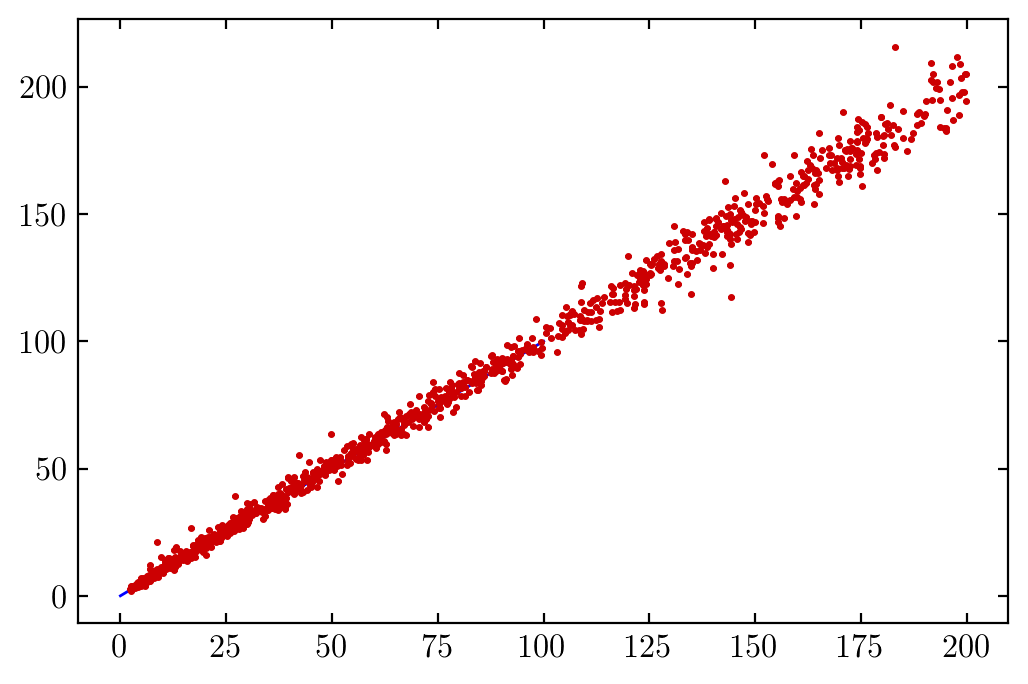

In [322]:
true = test_chi2.flatten()
pred = m.predict(test_samples, kern=m.kern.rbf)
gp = pred[0].flatten()
gp_err = pred[1].flatten()

#gp, gp_err = [-lnprob(i) for i in test_samples], 0

lim = 1e2
_, ax = plt.subplots()
ax.errorbar(true, gp+np.sqrt(gp_err), yerr=0, ls="", marker=".")
ax.plot([0, lim], [0, lim])
#ax.set(xlim=(0, lim), ylim=(0, lim))

## MCMC

In [323]:
# Return the lnprob that we have better than 1sigma confidence in
# We do this rather than the mean so that far away points are discouraged.
def lnprob(x):
    if np.all(x > ranges[:,0]) and np.all(x < ranges[:,1]):
        pred = m.predict(x.reshape((1, -1)), kern=m.kern.rbf)
        return -(pred[0][0][0] + np.sqrt(pred[1][0][0]))
    else:
        return -1e20

ndim, nwalkers = 5, 20

# Start in good positions
order = np.argsort(test_chi2.flatten())
p0 = test_samples[order][:nwalkers]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [324]:
pos, prob, state = sampler.run_mcmc(p0, 20)
sampler.reset()

In [325]:
sampler.run_mcmc(pos, 100);

In [328]:
sampler.run_mcmc(None, 1000);

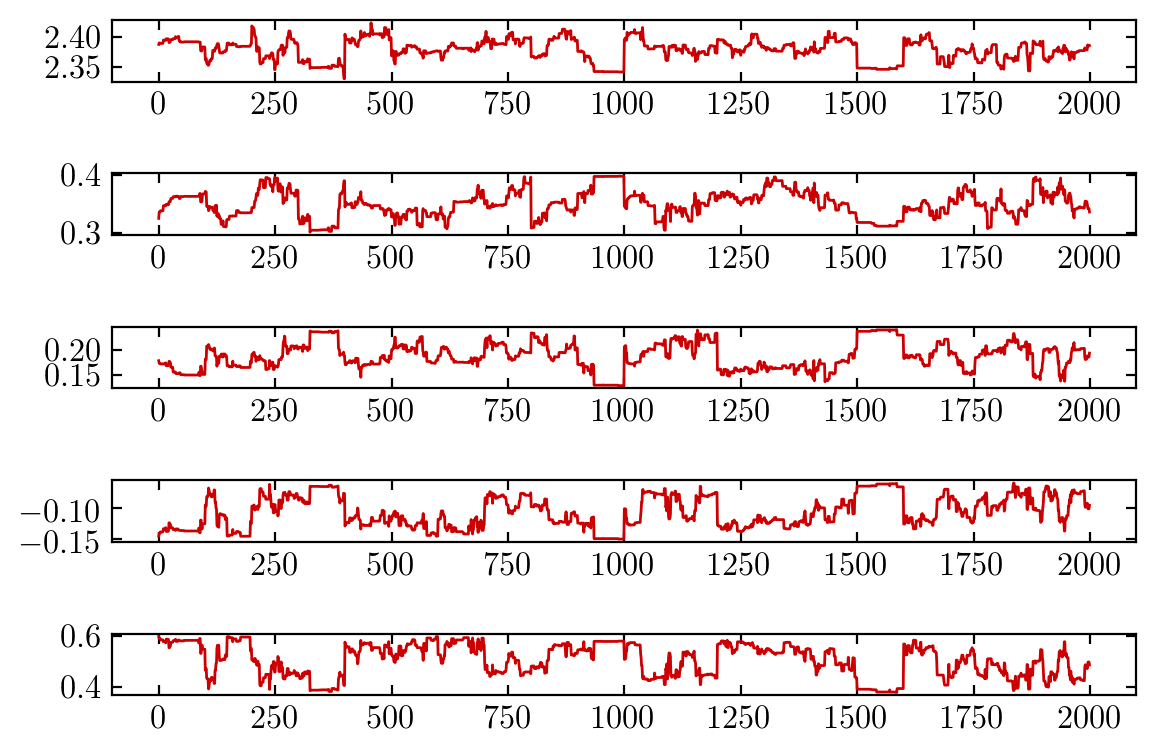

In [326]:
_, axes = plt.subplots(ndim, 1)
for i in range(ndim):
    axes[i].plot(sampler.flatchain[:,i])
plt.tight_layout()

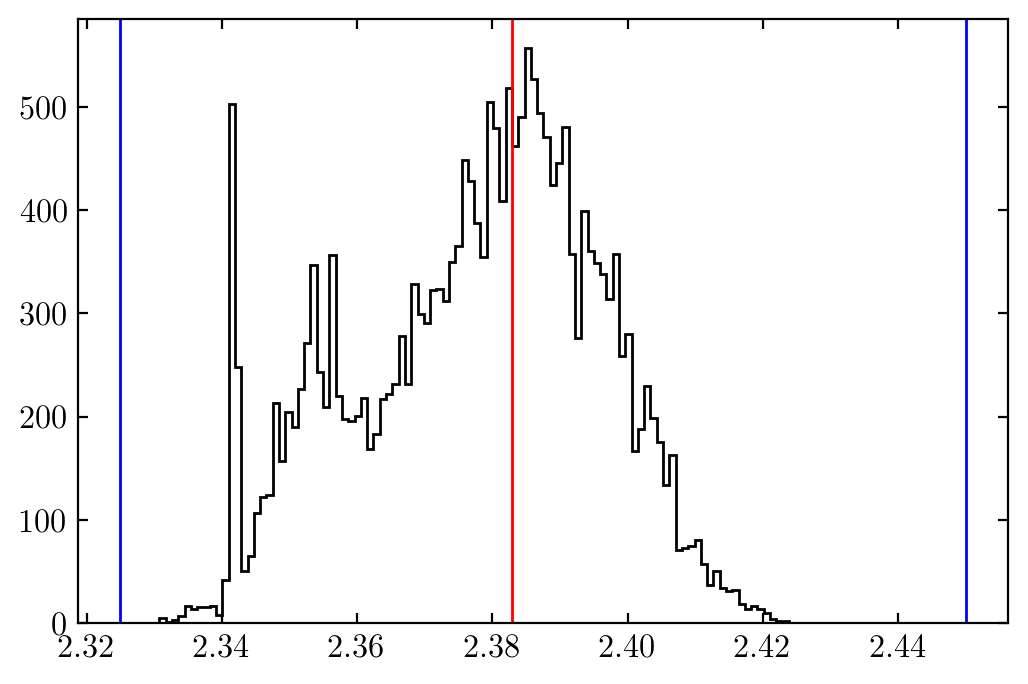

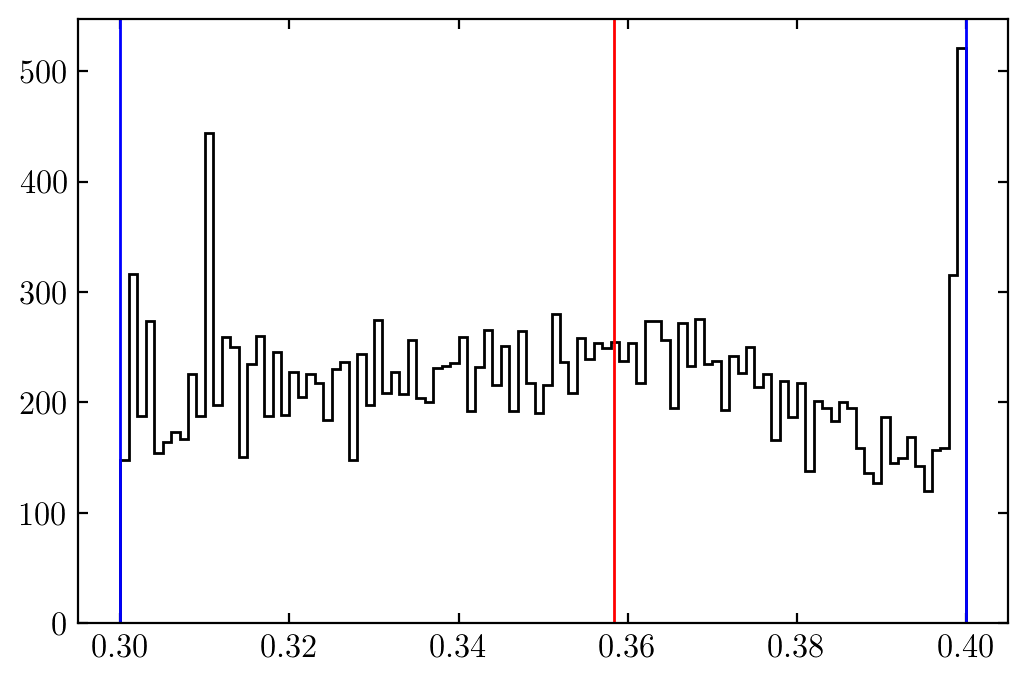

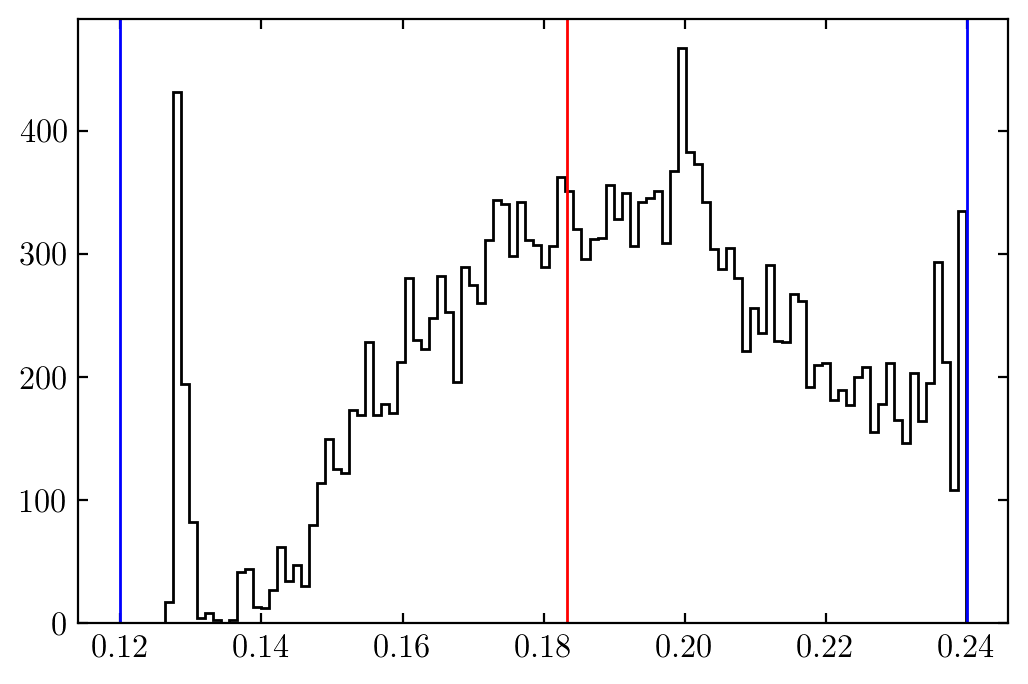

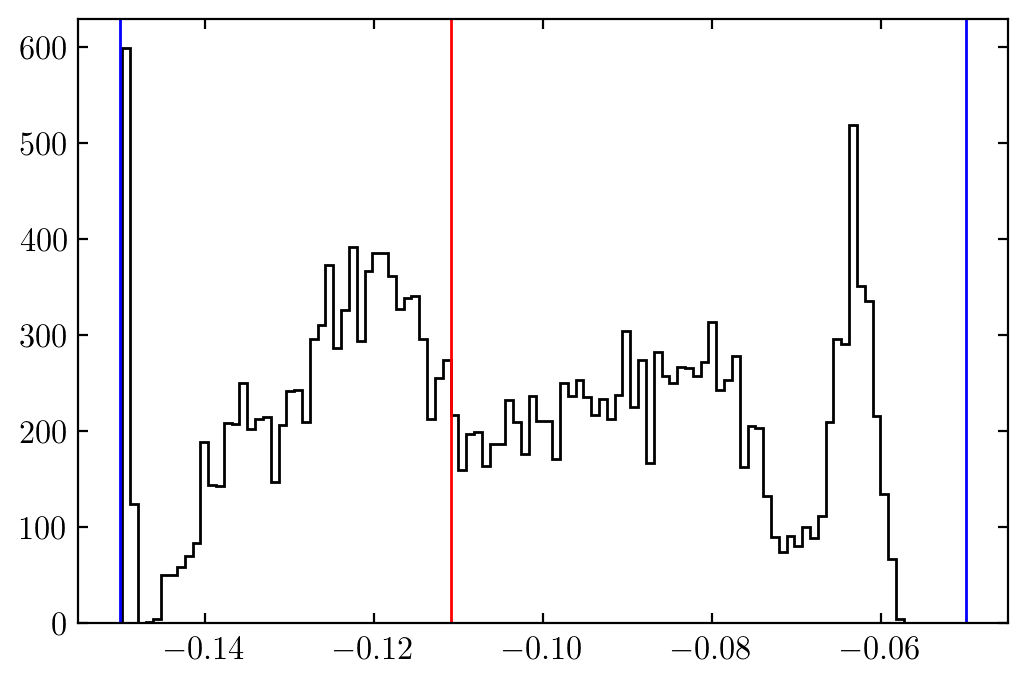

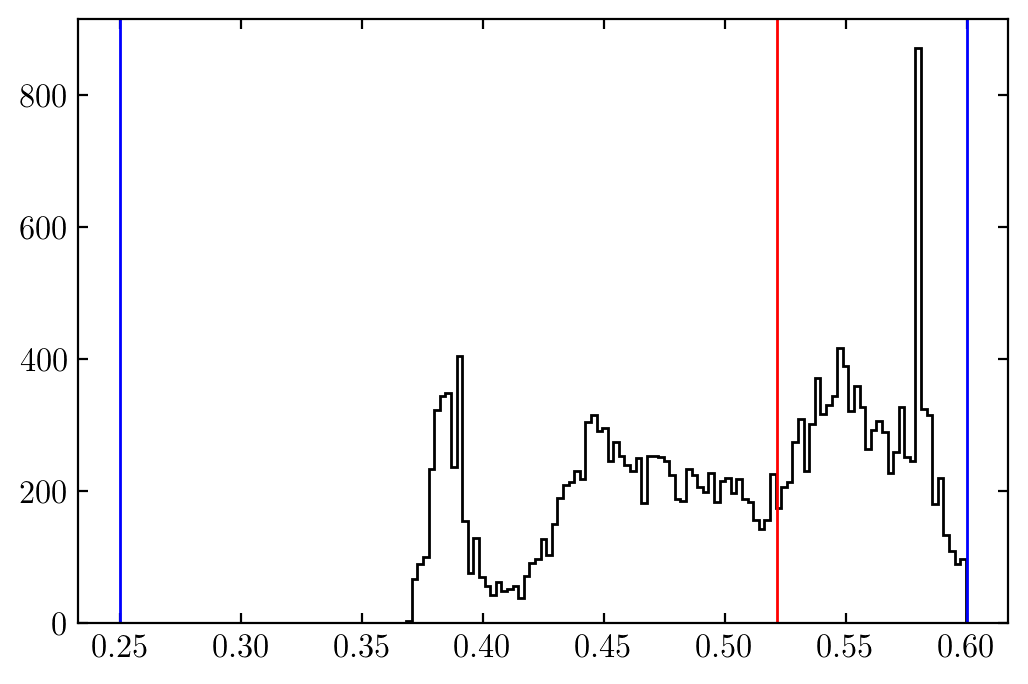

In [329]:
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    ax.axvline(best_fit[i], color="r")
    ax.axvline(ranges[i,0], color="b")
    ax.axvline(ranges[i,1], color="b")
    #ax.set(xlim=(ranges[i,0], ranges[i,1]))

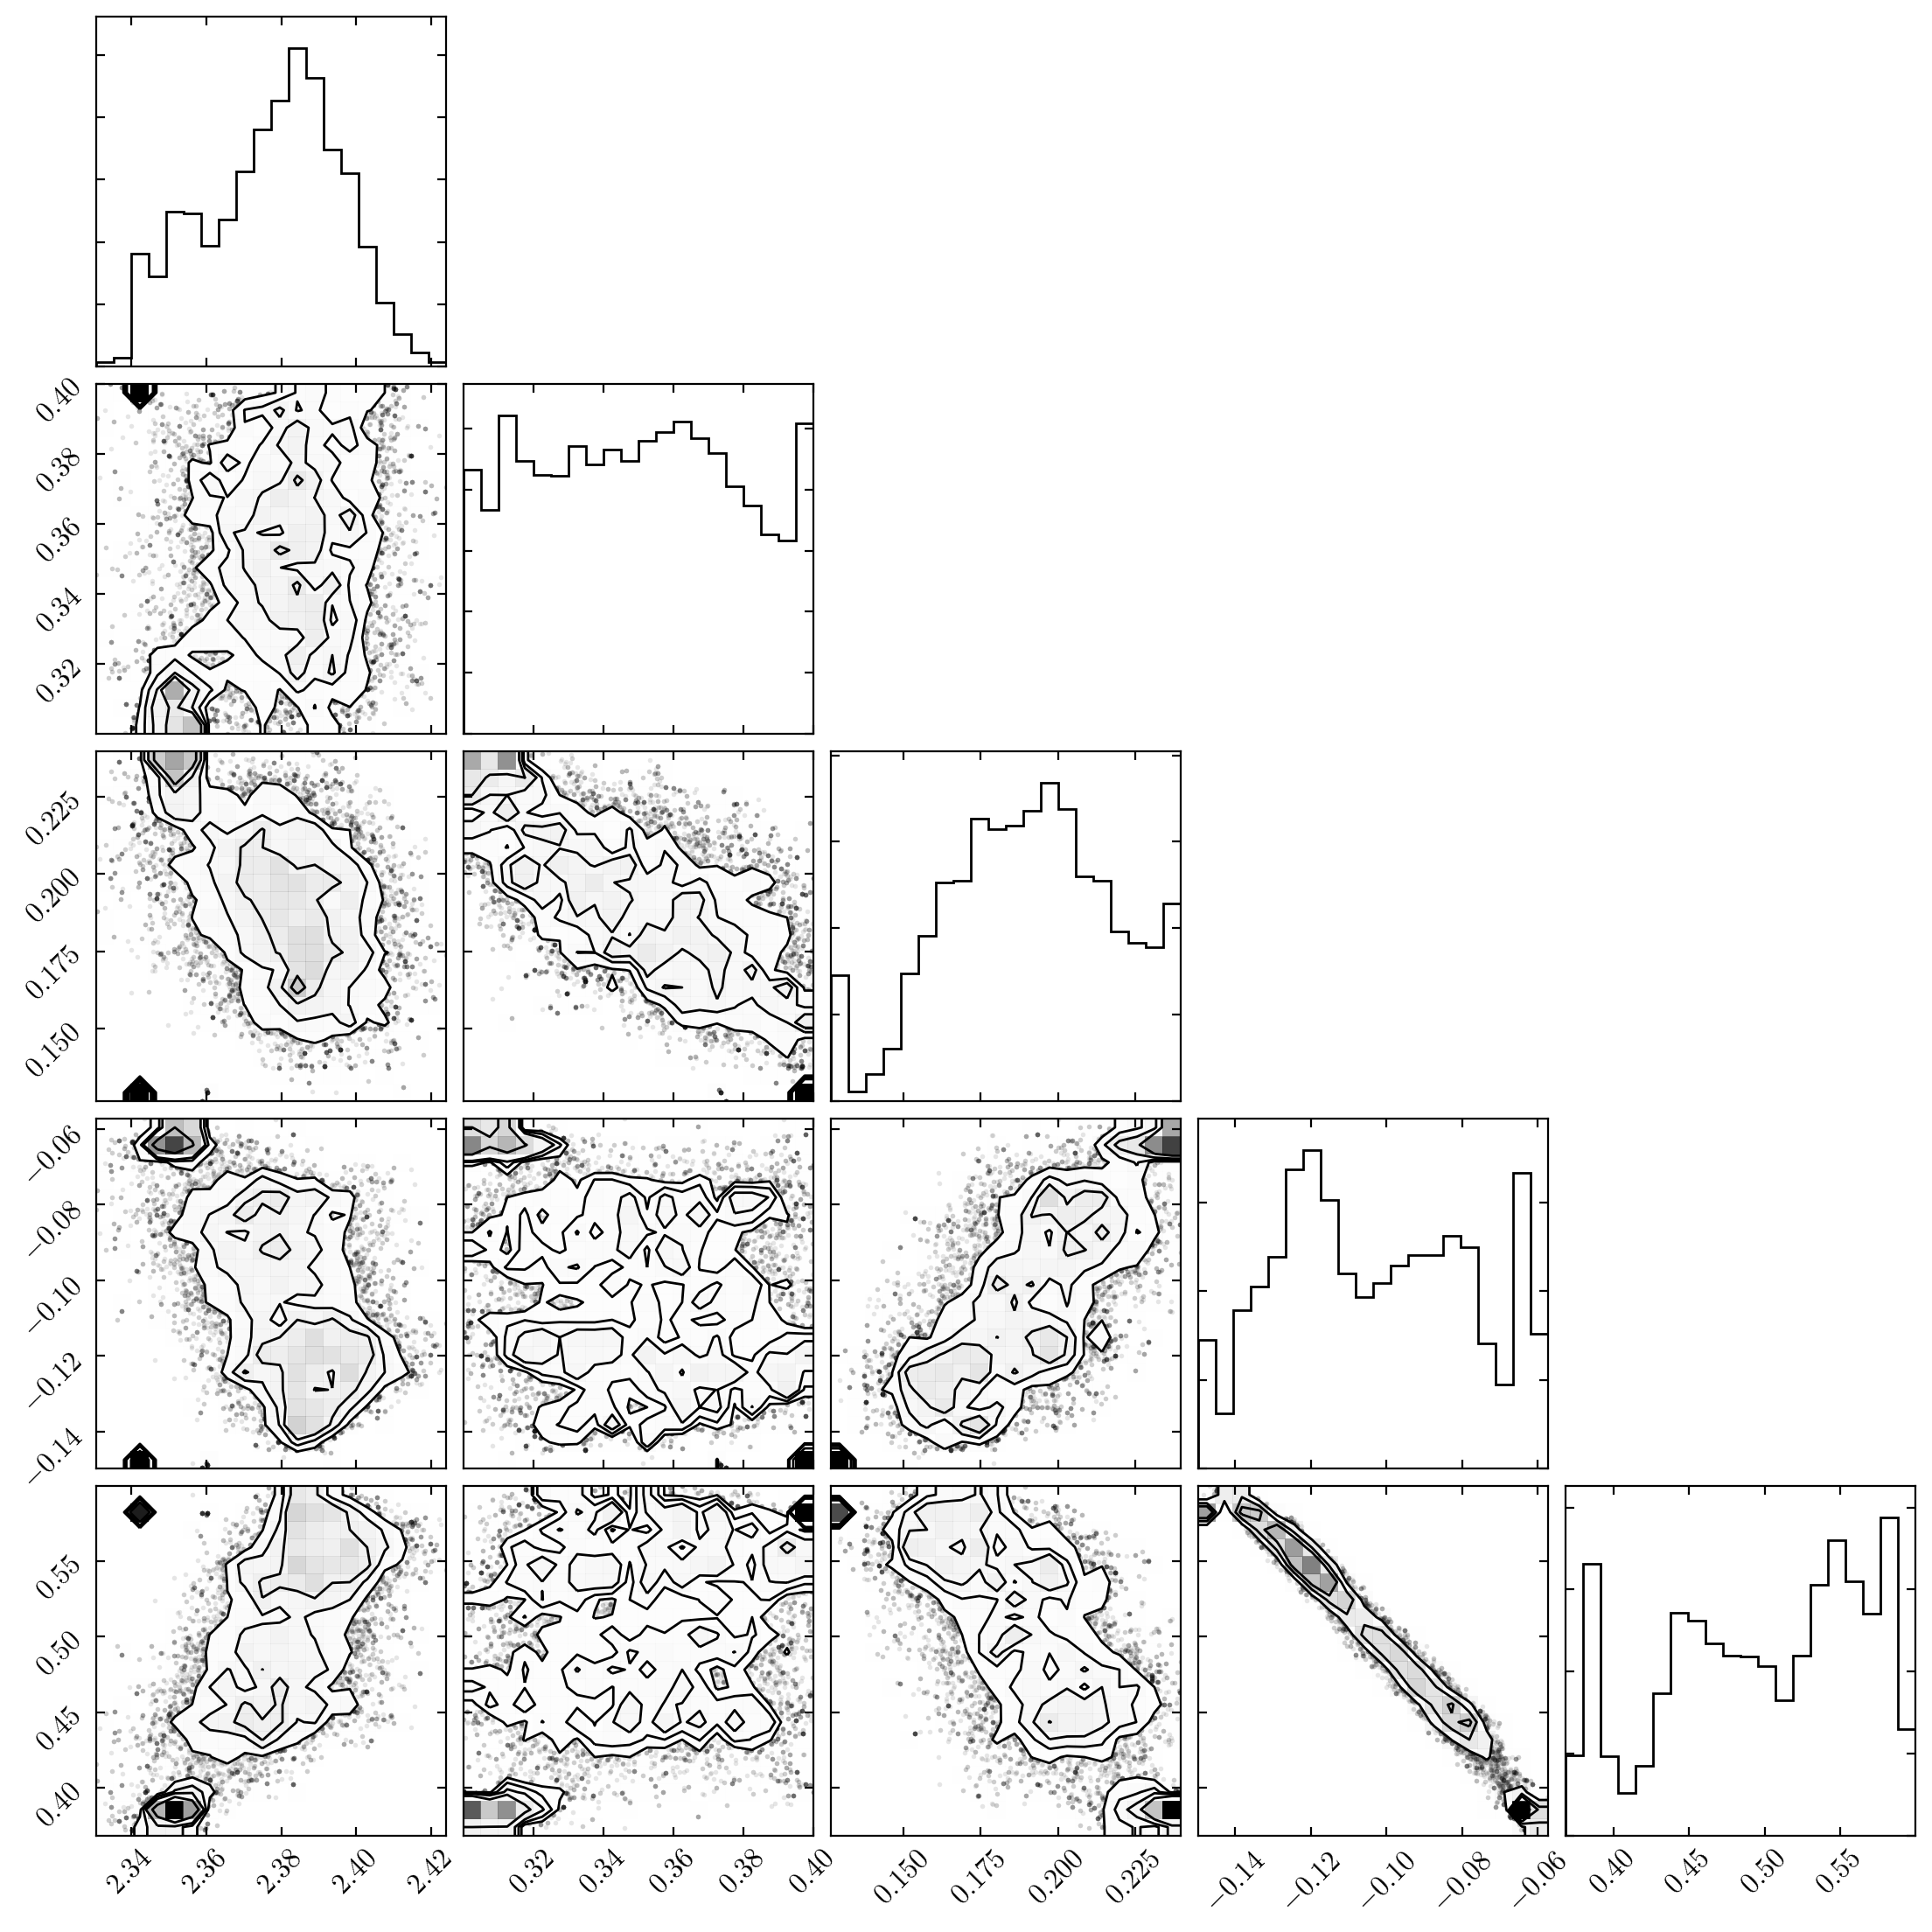

In [332]:
fig = corner.corner(sampler.flatchain)#, labels=labels, truths=[m_true, b_true, np.log(f_true)]);

In [330]:
# Sanity checks
print("Acceptance fraction should be between 0.25 and 0.5: {}".format(sampler.acceptance_fraction))
print("Total chain length: {}".format(sampler.flatchain.shape[0]))
print(sampler.get_autocorr_time(c=2))

Acceptance fraction should be between 0.25 and 0.5: [0.39090909 0.42818182 0.44727273 0.25636364 0.44       0.42909091 0.43272727 0.43181818 0.42       0.18727273 0.31636364 0.45363636 0.39909091 0.41636364 0.38909091 0.33181818 0.36909091 0.42454545 0.42181818 0.42727273]
Total chain length: 22000
[99.95724226 26.9257842  43.90304073 40.84303298 64.14873894]


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:105: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

# Build bestfit model and compare to observations

In [9]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit_w_extra_params[:5], best_fit_w_extra_params[5:], x_field)

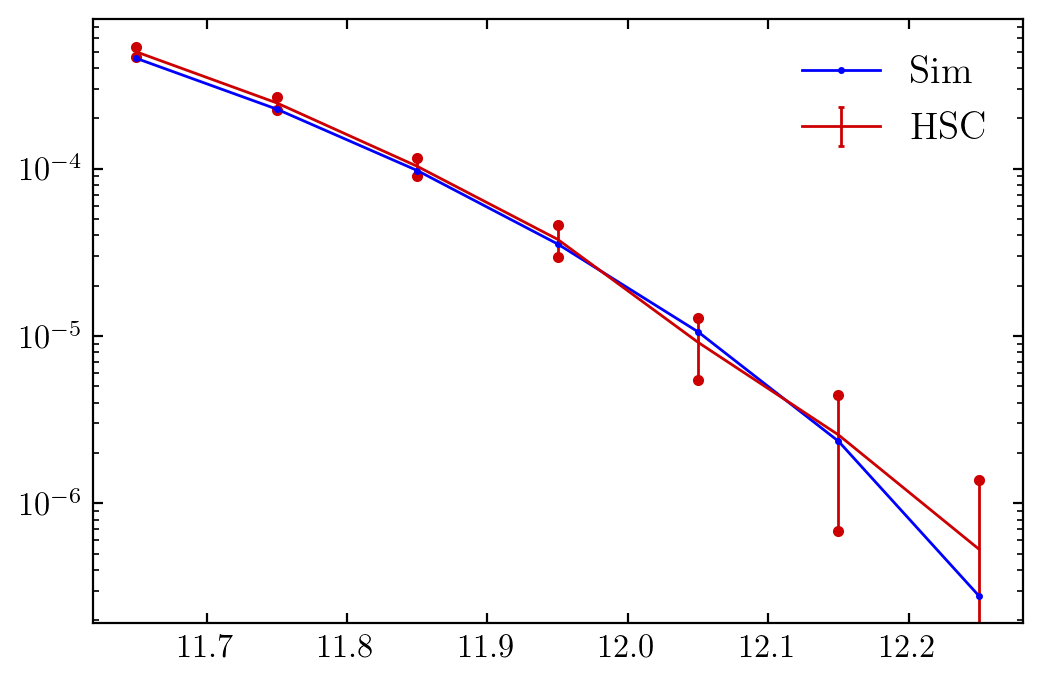

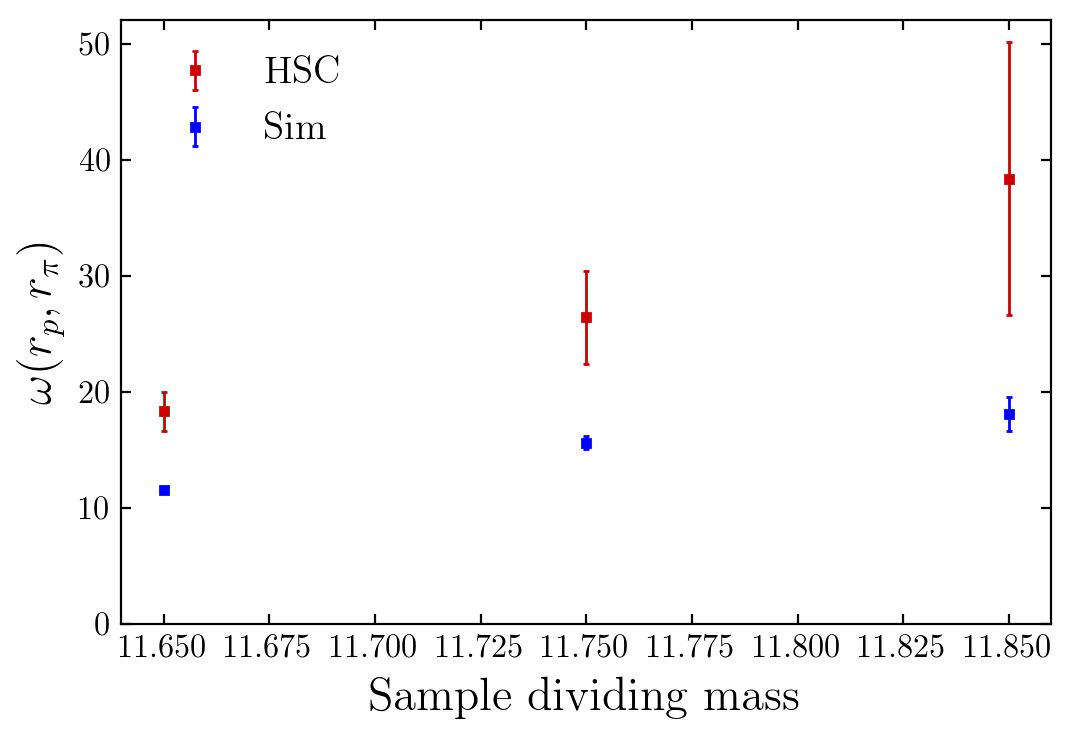

In [12]:
fig, ax = p.plot_smfs(obs_smf, log_stellar_masses, sim_size)

sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
if use == "vmax":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf.png", dpi=300)
elif use == "mpeak":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf_mpeak.png", dpi=300)
elif use == "mhalo":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf_mhalo.png", dpi=300)
else:
    raise Exception("eek")

fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.set(ylim=(0, ax.get_ylim()[1]))
ax.legend()

ax.set(ylabel=r"$\omega(r_p, r_{\pi})$", xlabel="Sample dividing mass")
if use == "vmax":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust.png", dpi=300)
elif use == "mpeak":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust_mpeak.png", dpi=300)
elif use == "mhalo":
    fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust_mhalo.png", dpi=300)
else:
    raise Exception("eek")

# Save out mock

In [ ]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
#sim_data_out = np.lib.recfunctions.rename_fields(sim_data_out, {"halo_mvir": "Mpeak"})
np.save("mocks/mhalo", np.ma.getdata(sim_data_out))

# From meeting

In [1]:
sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

NameError: name 'np' is not defined